# Part 0: Load in Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import localcider
from localcider.sequenceParameters import SequenceParameters
import re
import math
import scipy
from scipy.stats import ks_2samp
from matplotlib.patches import Rectangle
import pathlib
from matplotlib import font_manager
from matplotlib.pyplot import gcf


# Setup the fonts
fonts_path = pathlib.Path.home().joinpath('fonts') # i.e. `~/fonts` (update as needed)
font_filename = 'ARIAL.TTF'
font_path = fonts_path.joinpath(font_filename)
print(font_path)

font_manager.fontManager.addfont(str(font_path))
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42

COLOR_MAP = dict()
COLOR_MAP['A']         = '#8c8c8c'
COLOR_MAP['CHNQST']    = '#077a15'
COLOR_MAP['DE']        = '#e23a36'
COLOR_MAP['FWY']       = '#f58220'
COLOR_MAP['G']         = '#86bd8d'
COLOR_MAP['ILMV']      = '#231f20'
COLOR_MAP['KR']        = '#1725c2'
COLOR_MAP['P']         = '#c25fc9'


# Using the global color map, we convert the colormap of amino acid
# groups, to a map against individual amino acids. This
# serves as our internal color map which is used for styling.
aacolor_map=dict()
for amino_acids in COLOR_MAP:
    for amino_acid in amino_acids:
        aacolor_map[amino_acid] = COLOR_MAP[amino_acids]

/home/research/kiersten.ruff/fonts/ARIAL.TTF


# Part 1: Load in Data and Map to GIN clusters

## 1.1 - Get full lengths of all human proteins

20882
20882


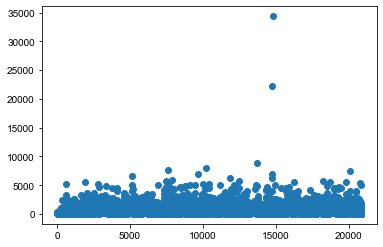

In [2]:
# Proteome was retrieved from the EnsEMBL database on May 18th 2015
myfile = open('data/UP000005640_9606.fasta', 'r')
Lines = myfile.readlines()

tmpfullproteinaccs=[]
tmpfullproteinseqs=[]
tmpfullproteinlens=[]
thisseq = ''
for line in Lines:
    
    # remove pesky newline
    cleanline = line.strip()
    
    
    if cleanline[0]=='>':
        tmp=cleanline.split('|')
        tmpfullproteinaccs.append(tmp[1])
        
        # check that this is not the very first sequence, if not 
        # add the sequence
        if (thisseq is not ''): 
            tmpfullproteinseqs.append(thisseq.upper()) 
            tmpfullproteinlens.append(len(thisseq.upper()))

            # reset the sequence for the coming entry
            thisseq = '' 

    # else append the sequence
    else:
        thisseq += cleanline

# store the final sequence	
tmpfullproteinseqs.append(thisseq.upper()) 
tmpfullproteinlens.append(len(thisseq.upper()))

print(len(tmpfullproteinaccs))
print(len(tmpfullproteinseqs))

plt.plot(tmpfullproteinlens,'o')


## 1.2 - Load in All Sapiens Disordered Stretches >=30

In [3]:
speciesname='sapiens'

# Gene names table
mapdf=pd.read_table('data/sapiens_uniprot_gene_name.tsv')
accsmap=mapdf['Uniprot'].tolist()
genesmap=mapdf['Gene'].tolist()

fullaccswnums=[]
fullaccs=[]
fullgeneswnums=[]
fullseqs=[]
fullseqlens=[]
fullstpos=[]
fullenpos=[]
fulltermini=[]
fullproteinlength=[]
goodidxs=[]
badidxs=[]

myfile = open('data/idrs_min_length_30/'+speciesname, 'r')
Lines = myfile.readlines()

count=0
for line in Lines:
    count=count+1
    fullline=line.split(" ")
    tmpseq=fullline[3]
    tmpacc=fullline[0]
    tmpst=fullline[1]
    tmpen=fullline[2]
    currseq=tmpseq.strip('\n')
    
    if len(currseq)>=30 and "X" not in currseq and "U" not in currseq and "Z" not in currseq and "J" not in currseq and "B" not in currseq and "O" not in currseq:
        fullaccswnums.append(tmpacc)
        fullseqs.append(currseq)
        tmp=tmpacc.split("_")
        fullaccs.append(tmp[0])
        if tmp[0] in accsmap:
            currgidx=accsmap.index(tmp[0])
            fullgeneswnums.append(genesmap[currgidx]+' IDR'+tmp[1])
        else:
            fullgeneswnums.append(tmp[0]+' IDR'+tmp[1])

        fullseqlens.append(len(currseq))
        fullstpos.append(tmpst)
        fullenpos.append(tmpen)  
        
        # Determine if IDR is within 5 residues of the termini and classify it as N- or C- or Non-terminal
        tmpidx=tmpfullproteinaccs.index(tmp[0])
        currfullproteinlen=tmpfullproteinlens[tmpidx]
        fullproteinlength.append(currfullproteinlen)
        coff=10
        if int(tmpst)<coff and int(tmpen)>currfullproteinlen-coff:
            fulltermini.append('IDR')
        elif int(tmpst)<coff and int(tmpen)<=currfullproteinlen-coff:
            fulltermini.append('N-terminal IDR')
        elif int(tmpst)>=coff and int(tmpen)>currfullproteinlen-coff:
            fulltermini.append('C-terminal IDR')
        else:
            fulltermini.append('Linker IDR')  
            
        goodidxs.append(count)
    else:
        badidxs.append(count)
        
print(len(fullseqs))
print(count)
print(len(goodidxs))
print(badidxs)

print(fullgeneswnums[0:5])
print(fullaccs[0:5])
print(fulltermini[0:5])
print(fullproteinlength[0:5])


24508
24535
24508
[337, 338, 5387, 7965, 8270, 8860, 9309, 13434, 18343, 20894, 20895, 20896, 20897, 20898, 20900, 20901, 20902, 20903, 20904, 20905, 20906, 20907, 20908, 20909, 21628, 22016, 23960]
['KRTAP4-16 IDR1', 'TULP4 IDR1', 'TULP4 IDR2', 'TULP4 IDR3', 'TULP4 IDR4']
['G5E9R7', 'Q9NRJ4', 'Q9NRJ4', 'Q9NRJ4', 'Q9NRJ4']
['C-terminal IDR', 'Linker IDR', 'Linker IDR', 'Linker IDR', 'Linker IDR']
[235, 1543, 1543, 1543, 1543]


## 1.3 - Load in all human IDR z-score data

In [5]:
# make sure features match
myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','M Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac']
print(len(myfeat))

# Load in z-scores for all human IDRs
# Made in /project/fava/work/kiersten.ruff/Collaborations/Su/2023/Library_design/map_clusters_for_all_human_IDRs.ipynb
zvecall=np.load('data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')
print(zvecall.shape)

90
(24508, 90)


## 1.4 - Load in clusters from excel file

In [6]:
numkclusts=30

tmpgenelistclust=[]
tmpacclistbyclust=[]
allgenesIDRnum=[]
allaccsIDRnum=[]
allclusters=[]
for c in range(0,numkclusts):
    tmpdf=pd.read_excel('data/IDR_100_300_kmeans_30_clusters_v2.xlsx',sheet_name='cluster_'+str(c))

    tmpgenelistclust.append(tmpdf['Genes'].tolist())
    tmpacclistbyclust.append(tmpdf['Uniprot'].tolist())
    
    tmpgenes=tmpdf['Genes'].tolist()
    tmpaccs=tmpdf['Uniprot'].tolist()
    
    #print('Cluster_'+str(c))
    #print(len(tmpgenes))
    
    for g in range(0,len(tmpgenes)):
        if tmpgenes[g][0]=='*':
            allgenesIDRnum.append(tmpgenes[g][1:])
        else:
            allgenesIDRnum.append(tmpgenes[g])
        allaccsIDRnum.append(tmpaccs[g])
        allclusters.append(c)
        
print(len(allaccsIDRnum))
print(allclusters)
print(allgenesIDRnum)

4529
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

## 1.5 - Get z-score information for just the 100-300 IDRs

In [7]:
zvec100to300=np.zeros((len(allaccsIDRnum),len(myfeat)))
for s in range(0,len(allaccsIDRnum)):
    idx=fullaccswnums.index(allaccsIDRnum[s])
    zvec100to300[s,:]=zvecall[idx,:]
    
print(zvec100to300.shape)
print(zvec100to300[0,:])

(4529, 90)
[-0.60571479 -0.34352611  1.34285166 -0.93274506  0.          0.
  0.          1.51318928  0.25976177 -1.72914594 -0.46087312  0.
  0.          0.          2.10179757  1.5017112   2.39496235  0.
  0.          0.          2.95529999  0.92657083  0.          0.
  0.          0.7735729   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.73996017
 -0.15500192 -0.58236319  0.63335034 -0.18785176 -0.80709857  0.74360068
 -0.21852137  1.70760797 -0.01129441 -0.19920559  1.38599665 -0.15960193
 -0.50327452 -0.44364438  0.57610055 -0.19417333 -0.31673038 -0.05111618
 -0.50769076 -0.60884262  0.37586556  0.15892031 -0.20271006  0.71796095
 -1.12270006  0.29418191 -0.56466322  0.0681122   0.36568661  0.12714819
  0.2232131  -0.15822672 -0.1366381  -0.57784587 -0.26453678 -0.00891408
 -0.17776023 -0.34861861 -0.01188483  0.21820173 -0.07679037 -0.01093911
 -0.25342933 -0.095519   -0.02644574 -0.0763383  -0.44702141 -0.15973391
 -0.247

## 1.6 - Create z-score arrays that set value to cutoff if above or below

In [8]:
cutoff=3

zvec100to300wcutoff=zvec100to300
for z in range(0,len(zvec100to300wcutoff)):
    pos=[i for i, ltr in enumerate(zvec100to300wcutoff[z,:]) if ltr > cutoff]
    zvec100to300wcutoff[z,pos]=cutoff
    pos=[i for i, ltr in enumerate(zvec100to300wcutoff[z,:]) if ltr < -cutoff]
    zvec100to300wcutoff[z,pos]=-cutoff
    
zvecall_wcutoff=zvecall
for z in range(0,len(zvecall_wcutoff)):
    pos=[i for i, ltr in enumerate(zvecall_wcutoff[z,:]) if ltr > cutoff]
    zvecall_wcutoff[z,pos]=cutoff
    pos=[i for i, ltr in enumerate(zvecall_wcutoff[z,:]) if ltr < -cutoff]
    zvecall_wcutoff[z,pos]=-cutoff

## 1.7 - Get centroids of each cluster

Cluster_0
Cluster_1
Cluster_2
Cluster_3
Cluster_4
Cluster_5
Cluster_6
Cluster_7
Cluster_8
Cluster_9
Cluster_10
Cluster_11
Cluster_12
Cluster_13
Cluster_14
Cluster_15
Cluster_16
Cluster_17
Cluster_18
Cluster_19
Cluster_20
Cluster_21
Cluster_22
Cluster_23
Cluster_24
Cluster_25
Cluster_26
Cluster_27
Cluster_28
Cluster_29
(30, 90)


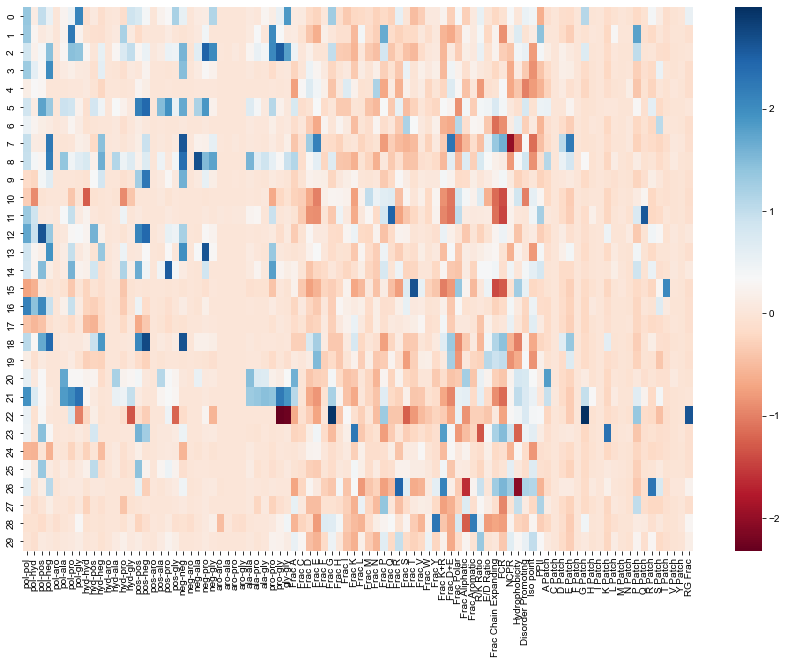

In [9]:
clustcentroids=np.zeros((numkclusts,len(myfeat)))
for c in range(0,numkclusts):
    print('Cluster_'+str(c))
    currclustpos=[x for x, ltr in enumerate(allclusters) if ltr == c]
    
    tmparray=np.zeros((len(currclustpos),len(myfeat)))
    count=-1
    for p in currclustpos:
        count=count+1
        tmparray[count,:]=zvec100to300wcutoff[p,:]
        
    #print(len(np.mean(tmparray, axis=0)))
    clustcentroids[c,:]=np.mean(tmparray, axis=0)

plt.figure(figsize=(15,10))
sbn.heatmap(clustcentroids,cmap='RdBu')
plt.xticks(np.arange(0.5, len(myfeat), 1), myfeat,rotation=90) 

print(clustcentroids.shape)

## 1.8 - Get cluster for all IDRs in human proteome

In [10]:
print(numkclusts)

fullclusternum=[]
fullmininterclustdist=[]
believeclust=[]

count=0
for i in range(0,len(fullseqs)):
    print('Current IDR count: '+str(i))
    
    tmpmeandisttoclust=[]
    for c in range(0,numkclusts):
        azvec=clustcentroids[c,:]
        bzvec=zvecall_wcutoff[i,:]
        tmpdist=np.sum((azvec-bzvec)**2)
        tmpmeandisttoclust.append(tmpdist)
        
    print(fullgeneswnums[i])
    print("Cluster: ", pd.Series(tmpmeandisttoclust).idxmin())
    fullclusternum.append(pd.Series(tmpmeandisttoclust).idxmin())
    
    minval=min(tmpmeandisttoclust)
    tmpdiff=[]
    for m in range(0,len(tmpmeandisttoclust)):
        if tmpmeandisttoclust[m]!=minval:
            tmpdiff.append(tmpmeandisttoclust[m]-minval)
        else:
            tmpdiff.append(100)
    fullmininterclustdist.append(min(tmpdiff))
    print(min(tmpdiff))
  
    if fullaccswnums[i] in allaccsIDRnum:
        count=count+1
        idx=allaccsIDRnum.index(fullaccswnums[i])
        tmpclustnum=allclusters[idx]
        print("K-means Cluster: "+str(tmpclustnum))
        print('Current IDR 100-300 Count: '+str(count))
        if tmpclustnum != fullclusternum[i]:
            print(tmpclustnum)
            print(fullclusternum[i])
            print(tmpmeandisttoclust)
            hi
            
    
    

    

30
Current IDR count: 0
KRTAP4-16 IDR1
Cluster:  27
8.592810642929571
Current IDR count: 1
TULP4 IDR1
Cluster:  17
14.569963791703593
Current IDR count: 2
TULP4 IDR2
Cluster:  1
4.777866904462275
Current IDR count: 3
TULP4 IDR3
Cluster:  27
0.7531034705882647
Current IDR count: 4
TULP4 IDR4
Cluster:  27
3.4911702168867222
Current IDR count: 5
TULP4 IDR5
Cluster:  6
10.70350597255785
Current IDR count: 6
TULP4 IDR6
Cluster:  23
19.366277014389173
Current IDR count: 7
TULP4 IDR7
Cluster:  23
6.154491013685565
Current IDR count: 8
PPP4R3B IDR1
Cluster:  18
15.241590437054075
K-means Cluster: 18
Current IDR 100-300 Count: 1
Current IDR count: 9
CCDC198 IDR1
Cluster:  17
10.98061458390907
Current IDR count: 10
CCDC198 IDR2
Cluster:  4
1.3462489383385154
Current IDR count: 11
CCDC198 IDR3
Cluster:  12
8.001119260601058
Current IDR count: 12
MEPE IDR1
Cluster:  4
3.3224846876312633
K-means Cluster: 4
Current IDR 100-300 Count: 2
Current IDR count: 13
MEPE IDR2
Cluster:  17
3.6875069783712817


Cluster:  29
4.87788561751303
Current IDR count: 190
ATXN3L IDR1
Cluster:  4
1.4134896751287087
K-means Cluster: 4
Current IDR 100-300 Count: 35
Current IDR count: 191
EDA IDR1
Cluster:  8
2.2259976232178076
Current IDR count: 192
EDA IDR2
Cluster:  6
0.5072692114284436
Current IDR count: 193
EDA IDR3
Cluster:  14
19.563866635784272
K-means Cluster: 14
Current IDR 100-300 Count: 36
Current IDR count: 194
KCNF1 IDR1
Cluster:  4
0.8303530784694999
Current IDR count: 195
C9orf43 IDR1
Cluster:  25
4.69968410774058
Current IDR count: 196
C9orf43 IDR2
Cluster:  23
4.14792131744845
Current IDR count: 197
C9orf43 IDR3
Cluster:  17
1.3834553753013061
Current IDR count: 198
TMEM233 IDR1
Cluster:  19
0.24995352859684772
Current IDR count: 199
PHIP IDR1
Cluster:  6
3.9136959485124194
Current IDR count: 200
PHIP IDR2
Cluster:  18
2.0927705729106627
K-means Cluster: 18
Current IDR 100-300 Count: 37
Current IDR count: 201
PHIP IDR3
Cluster:  18
2.164397444606692
Current IDR count: 202
PHIP IDR4
Clust

Cluster:  4
4.54191095106496
Current IDR count: 505
CENPC IDR2
Cluster:  17
10.678718870226042
Current IDR count: 506
CENPC IDR3
Cluster:  9
6.696931916450943
K-means Cluster: 9
Current IDR 100-300 Count: 89
Current IDR count: 507
CENPC IDR4
Cluster:  17
3.700732663431694
Current IDR count: 508
CENPC IDR5
Cluster:  9
11.415334040206062
K-means Cluster: 9
Current IDR 100-300 Count: 90
Current IDR count: 509
NACAD IDR1
Cluster:  27
1.7897202474677307
K-means Cluster: 27
Current IDR 100-300 Count: 91
Current IDR count: 510
NACAD IDR2
Cluster:  6
5.089366330113023
Current IDR count: 511
NACAD IDR3
Cluster:  7
3.146145580439388
Current IDR count: 512
NACAD IDR4
Cluster:  3
2.011526723477008
Current IDR count: 513
NACAD IDR5
Cluster:  24
3.8467410078664273
Current IDR count: 514
NACAD IDR6
Cluster:  7
2.2941300344335005
Current IDR count: 515
MCF2L IDR1
Cluster:  5
0.872402261293459
Current IDR count: 516
MCF2L IDR2
Cluster:  3
1.8026062603566047
K-means Cluster: 3
Current IDR 100-300 Count:

Current IDR count: 689
RYR2 IDR1
Cluster:  19
17.662573906403615
Current IDR count: 690
RYR2 IDR2
Cluster:  7
11.617463913891847
Current IDR count: 691
RYR2 IDR3
Cluster:  19
10.550787795139296
Current IDR count: 692
RYR2 IDR4
Cluster:  7
1.695002116818813
Current IDR count: 693
GDF5 IDR1
Cluster:  1
9.69185378980493
K-means Cluster: 1
Current IDR 100-300 Count: 116
Current IDR count: 694
GDF5 IDR2
Cluster:  29
2.168542432590776
Current IDR count: 695
C2CD3 IDR1
Cluster:  25
0.8421830058761799
Current IDR count: 696
C2CD3 IDR2
Cluster:  9
2.12234701203883
Current IDR count: 697
C2CD3 IDR3
Cluster:  17
0.5235100721012458
Current IDR count: 698
C2CD3 IDR4
Cluster:  24
0.823345723666197
Current IDR count: 699
C2CD3 IDR5
Cluster:  17
4.013737236779885
Current IDR count: 700
C2CD3 IDR6
Cluster:  6
7.3555156459413915
Current IDR count: 701
C2CD3 IDR7
Cluster:  24
2.8277546921583756
K-means Cluster: 24
Current IDR 100-300 Count: 117
Current IDR count: 702
C2CD3 IDR8
Cluster:  24
1.18618929901

CKAP5 IDR4
Cluster:  17
7.439671250129528
Current IDR count: 922
CKAP5 IDR5
Cluster:  17
7.119774394373611
Current IDR count: 923
CKAP5 IDR6
Cluster:  15
12.997855471281852
Current IDR count: 924
CKAP5 IDR7
Cluster:  16
17.303821913321123
Current IDR count: 925
CCDC30 IDR1
Cluster:  19
18.256976403607307
Current IDR count: 926
CCDC30 IDR2
Cluster:  4
2.8260607353577782
K-means Cluster: 4
Current IDR 100-300 Count: 158
Current IDR count: 927
CCDC30 IDR3
Cluster:  4
2.5033299152186466
Current IDR count: 928
DXO IDR1
Cluster:  27
2.119630338488726
Current IDR count: 929
DXO IDR2
Cluster:  28
18.02607716179414
Current IDR count: 930
SORCS1 IDR1
Cluster:  29
8.671652014468371
Current IDR count: 931
SORCS1 IDR2
Cluster:  29
1.658396326040645
Current IDR count: 932
SORCS1 IDR3
Cluster:  29
7.055953636689502
Current IDR count: 933
KREMEN2 IDR1
Cluster:  6
14.660519670017258
Current IDR count: 934
KLKP1 IDR1
Cluster:  27
8.056096295403307
K-means Cluster: 27
Current IDR 100-300 Count: 159
Curre

3.219793953039293
Current IDR count: 1149
TCF23 IDR2
Cluster:  3
6.510022892268161
Current IDR count: 1150
HTR2C IDR1
Cluster:  12
1.4300719772512593
Current IDR count: 1151
KAT2B IDR1
Cluster:  20
0.1701315233627554
Current IDR count: 1152
KAT2B IDR2
Cluster:  16
7.623943264580312
Current IDR count: 1153
USP17L5 IDR1
Cluster:  29
0.7632641243912381
Current IDR count: 1154
USP17L5 IDR2
Cluster:  25
12.845632500288637
Current IDR count: 1155
EHMT2 IDR1
Cluster:  20
8.84235120654769
K-means Cluster: 20
Current IDR 100-300 Count: 195
Current IDR count: 1156
EHMT2 IDR2
Cluster:  18
25.327561674557007
K-means Cluster: 18
Current IDR 100-300 Count: 196
Current IDR count: 1157
EHMT2 IDR3
Cluster:  27
2.0909918029772356
Current IDR count: 1158
RASGEF1A IDR1
Cluster:  0
1.6661539451630318
Current IDR count: 1159
PRSS36 IDR1
Cluster:  3
2.1459667089619074
Current IDR count: 1160
PRSS36 IDR2
Cluster:  27
6.9498637207518215
Current IDR count: 1161
NELFE IDR1
Cluster:  26
16.04528247196174
K-means 

Cluster:  6
5.523624657989696
K-means Cluster: 6
Current IDR 100-300 Count: 218
Current IDR count: 1283
PDLIM5 IDR3
Cluster:  9
3.457920679418777
Current IDR count: 1284
PDLIM5 IDR4
Cluster:  24
3.3420699479649407
Current IDR count: 1285
PDLIM5 IDR5
Cluster:  10
11.253923570908537
Current IDR count: 1286
TACC3 IDR1
Cluster:  24
2.809361974937273
K-means Cluster: 24
Current IDR 100-300 Count: 219
Current IDR count: 1287
TACC3 IDR2
Cluster:  3
4.355183240743255
K-means Cluster: 3
Current IDR 100-300 Count: 220
Current IDR count: 1288
TACC3 IDR3
Cluster:  16
7.313157528730397
Current IDR count: 1289
UBTFL1 IDR1
Cluster:  24
1.4184810082958208
Current IDR count: 1290
UBTFL1 IDR2
Cluster:  12
11.627251126057601
Current IDR count: 1291
SEMA3B IDR1
Cluster:  29
7.853707920697865
Current IDR count: 1292
DNAJC3 IDR1
Cluster:  18
3.0030968859374525
Current IDR count: 1293
SIN3B IDR1
Cluster:  29
5.595934504913686
Current IDR count: 1294
SIN3B IDR2
Cluster:  3
4.122766295594211
Current IDR count:

11.973544270733044
Current IDR count: 1434
GRIK4 IDR1
Cluster:  14
15.00944126154252
Current IDR count: 1435
EMD IDR1
Cluster:  6
9.083480448831182
Current IDR count: 1436
EMD IDR2
Cluster:  9
0.12806658327952647
Current IDR count: 1437
NCKAP1L IDR1
Cluster:  23
14.1900186242014
Current IDR count: 1438
FAM135A IDR1
Cluster:  4
4.21850740391228
Current IDR count: 1439
FAM135A IDR2
Cluster:  4
9.083902340419758
Current IDR count: 1440
FAM135A IDR3
Cluster:  7
15.0454986149578
Current IDR count: 1441
SOWAHB IDR1
Cluster:  20
25.243659154951544
K-means Cluster: 20
Current IDR 100-300 Count: 250
Current IDR count: 1442
SOWAHB IDR2
Cluster:  16
5.512655642810003
K-means Cluster: 16
Current IDR 100-300 Count: 251
Current IDR count: 1443
SOWAHB IDR3
Cluster:  9
10.542339399717413
K-means Cluster: 9
Current IDR 100-300 Count: 252
Current IDR count: 1444
BICDL2 IDR1
Cluster:  3
3.9410509054047864
Current IDR count: 1445
BICDL2 IDR2
Cluster:  5
0.2575394705969316
Current IDR count: 1446
BICDL2 ID

0.8771586248662118
Current IDR count: 1623
hCG_1780467 IDR1
Cluster:  24
5.998103540148264
Current IDR count: 1624
FGD2 IDR1
Cluster:  24
1.7361369117256231
Current IDR count: 1625
FRMD5 IDR1
Cluster:  17
5.8574280302179105
Current IDR count: 1626
FRMD5 IDR2
Cluster:  6
5.377421004609467
Current IDR count: 1627
SH3RF1 IDR1
Cluster:  6
0.04461720992616591
Current IDR count: 1628
SH3RF1 IDR2
Cluster:  25
7.183326214881831
Current IDR count: 1629
SH3RF1 IDR3
Cluster:  10
2.0411573485177357
Current IDR count: 1630
SH3RF1 IDR4
Cluster:  27
5.852442709652202
Current IDR count: 1631
SH3RF1 IDR5
Cluster:  12
2.4359084441180343
K-means Cluster: 12
Current IDR 100-300 Count: 289
Current IDR count: 1632
PTK2 IDR1
Cluster:  6
0.6767979482546451
Current IDR count: 1633
PTK2 IDR2
Cluster:  13
9.349169062112473
Current IDR count: 1634
PTK2 IDR3
Cluster:  13
4.512834190775457
K-means Cluster: 13
Current IDR 100-300 Count: 290
Current IDR count: 1635
TAMALIN IDR1
Cluster:  5
4.368869960629915
Current I

Cluster:  1
1.714199855725397
Current IDR count: 1770
ZFHX2 IDR11
Cluster:  27
0.9838385062371842
Current IDR count: 1771
ZFHX2 IDR12
Cluster:  7
7.948734446609386
Current IDR count: 1772
ZFHX2 IDR13
Cluster:  14
0.03577840473465699
Current IDR count: 1773
ZFHX2 IDR14
Cluster:  29
3.4752960995568714
Current IDR count: 1774
ZFHX2 IDR15
Cluster:  2
17.741066064463745
K-means Cluster: 2
Current IDR 100-300 Count: 309
Current IDR count: 1775
ZFHX2 IDR16
Cluster:  27
21.986604774576783
Current IDR count: 1776
ZFHX2 IDR17
Cluster:  16
2.873751306890867
Current IDR count: 1777
ZFHX2 IDR18
Cluster:  1
0.7203755338150373
Current IDR count: 1778
LNX1 IDR1
Cluster:  25
3.074761799029048
Current IDR count: 1779
LNX1 IDR2
Cluster:  9
5.163675715501256
Current IDR count: 1780
LNX1 IDR3
Cluster:  28
5.696851389310019
Current IDR count: 1781
USP17L18 IDR1
Cluster:  29
0.7536110103522091
Current IDR count: 1782
USP17L18 IDR2
Cluster:  25
12.90867381027521
Current IDR count: 1783
KLHDC4 IDR1
Cluster:  2

Current IDR count: 1910
RUNX1T1 IDR1
Cluster:  15
3.9843175753576148
Current IDR count: 1911
RUNX1T1 IDR2
Cluster:  25
3.0459146831210546
Current IDR count: 1912
RUNX1T1 IDR3
Cluster:  16
6.356764732802567
Current IDR count: 1913
RUNX1T1 IDR4
Cluster:  15
25.950327591740056
Current IDR count: 1914
Q5W150 IDR1
Cluster:  27
1.3240188134157869
Current IDR count: 1915
ODAM IDR1
Cluster:  3
4.386573434316233
Current IDR count: 1916
IVNS1ABP IDR1
Cluster:  16
3.4330179920884127
Current IDR count: 1917
CAMTA1 IDR1
Cluster:  16
1.3016880666335418
K-means Cluster: 16
Current IDR 100-300 Count: 335
Current IDR count: 1918
CAMTA1 IDR2
Cluster:  28
7.522951866634415
Current IDR count: 1919
CAMTA1 IDR3
Cluster:  6
13.230687595704449
Current IDR count: 1920
CAMTA1 IDR4
Cluster:  6
2.060909195304049
Current IDR count: 1921
CAMTA1 IDR5
Cluster:  24
4.820996764871111
Current IDR count: 1922
CAMTA1 IDR6
Cluster:  17
2.1509426038151744
K-means Cluster: 17
Current IDR 100-300 Count: 336
Current IDR count:

Cluster:  3
13.796536848324621
Current IDR count: 2018
CAMSAP1 IDR5
Cluster:  6
1.5534387711985254
Current IDR count: 2019
CAMSAP1 IDR6
Cluster:  17
4.883052585697211
K-means Cluster: 17
Current IDR 100-300 Count: 357
Current IDR count: 2020
CAMSAP1 IDR7
Cluster:  12
9.02528220694882
K-means Cluster: 12
Current IDR 100-300 Count: 358
Current IDR count: 2021
PRSS42P IDR1
Cluster:  27
7.091499722021496
Current IDR count: 2022
ARHGDIB IDR1
Cluster:  7
11.759032312880493
Current IDR count: 2023
MAP2K6 IDR1
Cluster:  16
1.0224069484236011
Current IDR count: 2024
ARHGDIA IDR1
Cluster:  19
8.800170812124989
Current IDR count: 2025
NCAPD3 IDR1
Cluster:  23
2.6423453841434394
Current IDR count: 2026
NCAPD3 IDR2
Cluster:  6
7.95505857490005
Current IDR count: 2027
NCAPD3 IDR3
Cluster:  27
7.3453341136299315
Current IDR count: 2028
NCAPD3 IDR4
Cluster:  25
1.0041649759740956
Current IDR count: 2029
NCAPD3 IDR5
Cluster:  17
3.6193257902582907
Current IDR count: 2030
H3BUI4 IDR1
Cluster:  18
15.863

Cluster:  19
0.8693625578476691
K-means Cluster: 19
Current IDR 100-300 Count: 375
Current IDR count: 2144
HECW1 IDR2
Cluster:  3
15.487700477468401
K-means Cluster: 3
Current IDR 100-300 Count: 376
Current IDR count: 2145
HECW1 IDR3
Cluster:  24
4.561169015196274
K-means Cluster: 24
Current IDR 100-300 Count: 377
Current IDR count: 2146
HECW1 IDR4
Cluster:  0
29.898254906096767
Current IDR count: 2147
Q8N3U1 IDR1
Cluster:  29
2.3012651569706293
Current IDR count: 2148
RINL IDR1
Cluster:  7
14.010833422547119
Current IDR count: 2149
RINL IDR2
Cluster:  29
12.85806311966946
Current IDR count: 2150
RINL IDR3
Cluster:  29
4.706555446645268
Current IDR count: 2151
STAG2 IDR1
Cluster:  12
6.581160364587767
Current IDR count: 2152
STAG2 IDR2
Cluster:  25
6.717938323021876
Current IDR count: 2153
STAG2 IDR3
Cluster:  3
12.896190269416643
Current IDR count: 2154
METTL14 IDR1
Cluster:  19
6.169986744713032
Current IDR count: 2155
METTL14 IDR2
Cluster:  0
9.892309020967431
Current IDR count: 215

Cluster:  16
14.707355753278932
K-means Cluster: 16
Current IDR 100-300 Count: 410
Current IDR count: 2295
UBQLN1 IDR1
Cluster:  20
11.459695026136714
Current IDR count: 2296
UBQLN1 IDR2
Cluster:  6
7.102734917033544
Current IDR count: 2297
UBQLN1 IDR3
Cluster:  6
18.973859553338343
Current IDR count: 2298
UBQLN1 IDR4
Cluster:  15
15.99169656742005
Current IDR count: 2299
REL IDR1
Cluster:  10
1.8157821303491382
Current IDR count: 2300
REL IDR2
Cluster:  6
0.7177077647594317
Current IDR count: 2301
REL IDR3
Cluster:  6
2.7561819290315697
Current IDR count: 2302
FAM161B IDR1
Cluster:  24
8.687798994194917
Current IDR count: 2303
FAM161B IDR2
Cluster:  29
0.9590808533655526
Current IDR count: 2304
FAM161B IDR3
Cluster:  19
7.643896944434658
Current IDR count: 2305
FAM161B IDR4
Cluster:  29
13.850459593559535
Current IDR count: 2306
FAM161B IDR5
Cluster:  17
1.4766095489413544
Current IDR count: 2307
FAM161B IDR6
Cluster:  24
0.23416697072114268
Current IDR count: 2308
CDYL2 IDR1
Cluster:

12.391243628543002
Current IDR count: 2440
SH3GL2 IDR2
Cluster:  25
4.607281706982487
Current IDR count: 2441
SH3GL3 IDR1
Cluster:  25
2.950330111952834
Current IDR count: 2442
CMKLR1 IDR1
Cluster:  6
5.060433498862473
Current IDR count: 2443
CITED1 IDR1
Cluster:  15
9.59942737424818
Current IDR count: 2444
CITED1 IDR2
Cluster:  10
1.8814589938634185
Current IDR count: 2445
CITED2 IDR1
Cluster:  11
14.068497040321802
Current IDR count: 2446
CITED2 IDR2
Cluster:  10
20.541038043984514
Current IDR count: 2447
CITED2 IDR3
Cluster:  28
6.335016411346622
Current IDR count: 2448
INO80B-WBP1 IDR1
Cluster:  23
12.674313508135
Current IDR count: 2449
INO80B-WBP1 IDR2
Cluster:  13
5.851698692088874
Current IDR count: 2450
INO80B-WBP1 IDR3
Cluster:  0
17.270523101721963
Current IDR count: 2451
INO80B-WBP1 IDR4
Cluster:  27
7.661797173700812
Current IDR count: 2452
TCF20 IDR1
Cluster:  11
1.315707646677648
Current IDR count: 2453
TCF20 IDR2
Cluster:  25
3.7528214446801726
Current IDR count: 2454
T

8.44235016765979
Current IDR count: 2599
XRRA1 IDR1
Cluster:  3
9.200628157155407
Current IDR count: 2600
XRRA1 IDR2
Cluster:  24
7.787702359929195
Current IDR count: 2601
XRRA1 IDR3
Cluster:  23
14.158255641023814
Current IDR count: 2602
MRPL49 IDR1
Cluster:  27
5.710016198112619
Current IDR count: 2603
PAGE2 IDR1
Cluster:  24
2.530377126973285
Current IDR count: 2604
DYNC1I2 IDR1
Cluster:  25
4.946069895656699
K-means Cluster: 25
Current IDR 100-300 Count: 475
Current IDR count: 2605
DYNC1I2 IDR2
Cluster:  7
15.995842064905858
Current IDR count: 2606
KRT8 IDR1
Cluster:  28
8.790828580724394
Current IDR count: 2607
KRT8 IDR2
Cluster:  6
8.231865484602245
Current IDR count: 2608
EBF2 IDR1
Cluster:  6
1.6440039574869516
Current IDR count: 2609
TEX44 IDR1
Cluster:  24
5.484687157362732
Current IDR count: 2610
TEX44 IDR2
Cluster:  24
0.9647857252856724
Current IDR count: 2611
TEX44 IDR3
Cluster:  24
1.0144927550194787
Current IDR count: 2612
PTPRQ IDR1
Cluster:  6
15.018034116991814
Curre

Cluster:  0
15.22500954592816
Current IDR count: 2767
FOXF1 IDR2
Cluster:  10
1.7525349261651684
Current IDR count: 2768
VSIG1 IDR1
Cluster:  19
16.54814000567789
K-means Cluster: 19
Current IDR 100-300 Count: 500
Current IDR count: 2769
FAM83B IDR1
Cluster:  6
6.0949377653884405
Current IDR count: 2770
FAM83B IDR2
Cluster:  4
1.6993547686611734
Current IDR count: 2771
FAM83B IDR3
Cluster:  9
3.3960332502110298
Current IDR count: 2772
FAM83B IDR4
Cluster:  17
16.902566665728543
Current IDR count: 2773
FAM83B IDR5
Cluster:  25
2.7674113673717624
K-means Cluster: 25
Current IDR 100-300 Count: 501
Current IDR count: 2774
MTDH IDR1
Cluster:  23
20.59360745451546
K-means Cluster: 23
Current IDR 100-300 Count: 502
Current IDR count: 2775
MTDH IDR2
Cluster:  6
0.6678507941322778
Current IDR count: 2776
MTDH IDR3
Cluster:  12
13.607507892251117
K-means Cluster: 12
Current IDR 100-300 Count: 503
Current IDR count: 2777
IFNAR2 IDR1
Cluster:  3
7.502559180538441
K-means Cluster: 3
Current IDR 100

Cluster:  6
7.866795786434725
Current IDR count: 2954
SMG7 IDR7
Cluster:  6
12.625310358888633
Current IDR count: 2955
SMG7 IDR8
Cluster:  11
0.6334356327402375
Current IDR count: 2956
TOPBP1 IDR1
Cluster:  4
5.610098107589376
Current IDR count: 2957
TOPBP1 IDR2
Cluster:  4
10.600847200218812
Current IDR count: 2958
TOPBP1 IDR3
Cluster:  6
3.0666690026084744
Current IDR count: 2959
TOPBP1 IDR4
Cluster:  24
6.612449748012438
Current IDR count: 2960
C10orf67 IDR1
Cluster:  19
2.3710503295519345
Current IDR count: 2961
PCNX4 IDR1
Cluster:  4
11.448868242543249
Current IDR count: 2962
WEE2 IDR1
Cluster:  17
4.393631247043459
K-means Cluster: 17
Current IDR 100-300 Count: 532
Current IDR count: 2963
WEE2 IDR2
Cluster:  6
4.896929480583822
Current IDR count: 2964
C1QTNF12 IDR1
Cluster:  29
5.60187164756308
Current IDR count: 2965
MACO1 IDR1
Cluster:  12
1.4097331387271765
Current IDR count: 2966
MACO1 IDR2
Cluster:  6
2.099245005622066
Current IDR count: 2967
MACO1 IDR3
Cluster:  10
6.003929

HINFP IDR1
Cluster:  3
4.857906105016411
Current IDR count: 3079
HINFP IDR2
Cluster:  1
9.436891557844248
Current IDR count: 3080
RRP1B IDR1
Cluster:  19
0.7815273390819826
Current IDR count: 3081
RRP1B IDR2
Cluster:  12
1.4867140559201033
K-means Cluster: 12
Current IDR 100-300 Count: 552
Current IDR count: 3082
RRP1B IDR3
Cluster:  25
4.320557112130707
Current IDR count: 3083
ZNF644 IDR1
Cluster:  4
10.304282842761669
Current IDR count: 3084
ZNF644 IDR2
Cluster:  15
5.4412483221734576
Current IDR count: 3085
ZNF644 IDR3
Cluster:  16
4.123598059412355
Current IDR count: 3086
NSMF IDR1
Cluster:  24
2.873719592239908
Current IDR count: 3087
NSMF IDR2
Cluster:  27
0.39172777795345226
Current IDR count: 3088
NSMF IDR3
Cluster:  29
2.997619864092677
Current IDR count: 3089
NSMF IDR4
Cluster:  6
1.8959051717888116
Current IDR count: 3090
USP25 IDR1
Cluster:  6
0.2999366722095971
Current IDR count: 3091
USP25 IDR2
Cluster:  24
1.2353797407744267
Current IDR count: 3092
CMYA5 IDR1
Cluster:  1

MAGEL2 IDR1
Cluster:  20
4.870687209806981
Current IDR count: 3217
ISM1 IDR1
Cluster:  20
3.997896779254262
Current IDR count: 3218
ISM1 IDR2
Cluster:  28
13.850334502791362
Current IDR count: 3219
ISM1 IDR3
Cluster:  4
1.4774246352718237
Current IDR count: 3220
DOCK3 IDR1
Cluster:  6
13.879667483682198
Current IDR count: 3221
DOCK3 IDR2
Cluster:  6
16.144124348862913
Current IDR count: 3222
DOCK3 IDR3
Cluster:  6
6.7407010024896366
Current IDR count: 3223
DOCK3 IDR4
Cluster:  27
0.6759732467350048
Current IDR count: 3224
IQCJ IDR1
Cluster:  6
12.1131122377064
Current IDR count: 3225
ZNF396 IDR1
Cluster:  3
5.544106213455862
Current IDR count: 3226
ZNF396 IDR2
Cluster:  28
22.58143971074312
Current IDR count: 3227
SIX1 IDR1
Cluster:  3
10.448179438256929
K-means Cluster: 3
Current IDR 100-300 Count: 581
Current IDR count: 3228
RMDN3 IDR1
Cluster:  9
0.0667311371742656
Current IDR count: 3229
ARSJ IDR1
Cluster:  23
19.21238222456899
Current IDR count: 3230
NEO1 IDR1
Cluster:  10
0.82728

3.8551107473549706
Current IDR count: 3353
SPAG5 IDR3
Cluster:  24
4.677793723156903
Current IDR count: 3354
SPAG5 IDR4
Cluster:  19
19.797710798586692
Current IDR count: 3355
SPAG5 IDR5
Cluster:  6
9.25236141190608
Current IDR count: 3356
RPS6 IDR1
Cluster:  17
1.4880955137999337
Current IDR count: 3357
RPS6 IDR2
Cluster:  23
6.772306691084651
Current IDR count: 3358
CHTF18 IDR1
Cluster:  5
12.713994275692656
K-means Cluster: 5
Current IDR 100-300 Count: 608
Current IDR count: 3359
CHTF18 IDR2
Cluster:  3
1.6604402500834965
Current IDR count: 3360
CHTF18 IDR3
Cluster:  29
1.0855924855769175
Current IDR count: 3361
BRPF3 IDR1
Cluster:  4
2.6669224566847802
Current IDR count: 3362
BRPF3 IDR2
Cluster:  18
7.822872584751721
Current IDR count: 3363
BRPF3 IDR3
Cluster:  9
4.8590433132513695
K-means Cluster: 9
Current IDR 100-300 Count: 609
Current IDR count: 3364
YBX2 IDR1
Cluster:  29
1.693359741481764
Current IDR count: 3365
YBX2 IDR2
Cluster:  29
1.6672523173610543
K-means Cluster: 29
Cu

Cluster:  29
0.020699606549392513
Current IDR count: 3524
RSPH3 IDR2
Cluster:  29
6.733107533337645
Current IDR count: 3525
RSPH3 IDR3
Cluster:  19
3.190986188618197
Current IDR count: 3526
RSPH3 IDR4
Cluster:  7
3.4234737532463555
Current IDR count: 3527
RSPH3 IDR5
Cluster:  19
7.379474648689715
Current IDR count: 3528
VIPAS39 IDR1
Cluster:  3
7.586046071557064
Current IDR count: 3529
VIPAS39 IDR2
Cluster:  28
11.300453982378002
Current IDR count: 3530
IGF2BP2 IDR1
Cluster:  29
8.317015194476255
Current IDR count: 3531
BMT2 IDR1
Cluster:  29
0.6499454547526611
Current IDR count: 3532
ASPM IDR1
Cluster:  29
6.580783695930009
Current IDR count: 3533
ASPM IDR2
Cluster:  24
0.8127793048098475
Current IDR count: 3534
ASPM IDR3
Cluster:  25
5.125036543879837
Current IDR count: 3535
ASPM IDR4
Cluster:  12
1.285871472797119
Current IDR count: 3536
PPP1R2B IDR1
Cluster:  3
0.5083139434409887
Current IDR count: 3537
PPP1R2B IDR2
Cluster:  3
5.107599150633206
Current IDR count: 3538
PPP1R2B IDR3

PLPPR3 IDR3
Cluster:  6
9.154079745298269
Current IDR count: 3690
PLPPR3 IDR4
Cluster:  0
0.20797574149453624
Current IDR count: 3691
PTDSS1 IDR1
Cluster:  9
11.774516326117464
Current IDR count: 3692
SSX9P IDR1
Cluster:  17
13.717528681181445
Current IDR count: 3693
PINX1 IDR1
Cluster:  23
21.303728255726224
Current IDR count: 3694
PINX1 IDR2
Cluster:  12
0.833480362262037
Current IDR count: 3695
PINX1 IDR3
Cluster:  23
28.00950792151506
K-means Cluster: 23
Current IDR 100-300 Count: 666
Current IDR count: 3696
CLCN2 IDR1
Cluster:  14
4.377467649014058
Current IDR count: 3697
CLCN2 IDR2
Cluster:  17
4.737921852394525
Current IDR count: 3698
CLCN2 IDR3
Cluster:  6
0.01913652853241743
Current IDR count: 3699
CFAP157 IDR1
Cluster:  25
0.7803421985457248
Current IDR count: 3700
COL19A1 IDR1
Cluster:  22
86.12974931954955
Current IDR count: 3701
COL19A1 IDR2
Cluster:  22
73.43044640490898
Current IDR count: 3702
COL19A1 IDR3
Cluster:  22
32.693273418239855
Current IDR count: 3703
KCNQ1 IDR

9.538938991002802
Current IDR count: 3849
SELENOV IDR1
Cluster:  15
12.43454563789193
Current IDR count: 3850
SELENOV IDR2
Cluster:  27
11.40330103895208
Current IDR count: 3851
TRRAP IDR1
Cluster:  1
17.980068250785777
Current IDR count: 3852
TRRAP IDR2
Cluster:  4
6.618819747722725
Current IDR count: 3853
TRRAP IDR3
Cluster:  19
7.295669587379251
Current IDR count: 3854
DRP2 IDR1
Cluster:  19
1.022458625050355
Current IDR count: 3855
DRP2 IDR2
Cluster:  6
2.1019251430498613
Current IDR count: 3856
PRRG3 IDR1
Cluster:  29
2.093640241466325
Current IDR count: 3857
PRRG3 IDR2
Cluster:  13
1.81715223858685
Current IDR count: 3858
EEF1D IDR1
Cluster:  8
1.0136725518032748
Current IDR count: 3859
ECD IDR1
Cluster:  7
12.139455553245028
Current IDR count: 3860
ECD IDR2
Cluster:  4
6.678735109870786
Current IDR count: 3861
ECD IDR3
Cluster:  6
0.07540494446488921
Current IDR count: 3862
SLC16A8 IDR1
Cluster:  29
9.503308246649361
Current IDR count: 3863
SLC16A8 IDR2
Cluster:  19
3.3289570928

PHC2 IDR1
Cluster:  6
18.620870653612453
Current IDR count: 4056
PHC2 IDR2
Cluster:  27
3.953794466800236
Current IDR count: 4057
PHC2 IDR3
Cluster:  4
0.2944445240278455
Current IDR count: 4058
PHC2 IDR4
Cluster:  25
2.9666945919065917
Current IDR count: 4059
CLIP3 IDR1
Cluster:  13
3.6988361766282765
Current IDR count: 4060
CLIP3 IDR2
Cluster:  25
6.395022321322301
Current IDR count: 4061
CLIP3 IDR3
Cluster:  25
4.833920712079816
Current IDR count: 4062
ANP32E IDR1
Cluster:  7
41.463545353917844
K-means Cluster: 7
Current IDR 100-300 Count: 732
Current IDR count: 4063
SCLY IDR1
Cluster:  20
19.052755160936798
Current IDR count: 4064
SAMD15 IDR1
Cluster:  19
6.386505142250989
Current IDR count: 4065
CD6 IDR1
Cluster:  1
3.107686282763524
Current IDR count: 4066
CD6 IDR2
Cluster:  13
8.931322315668954
K-means Cluster: 13
Current IDR 100-300 Count: 733
Current IDR count: 4067
ODF2 IDR1
Cluster:  17
6.140546521419019
Current IDR count: 4068
ODF2 IDR2
Cluster:  26
14.995988236969012
Curre

5.716380267079572
Current IDR count: 4189
FGF14 IDR2
Cluster:  17
1.7349674084224844
Current IDR count: 4190
LDB1 IDR1
Cluster:  25
1.874938733578837
Current IDR count: 4191
LDB1 IDR2
Cluster:  4
1.3131274332578187
Current IDR count: 4192
PNPLA7 IDR1
Cluster:  0
5.487587376649891
Current IDR count: 4193
PNPLA7 IDR2
Cluster:  3
14.607239490980717
Current IDR count: 4194
HNRNPA3 IDR1
Cluster:  26
12.245089728305267
Current IDR count: 4195
HNRNPA3 IDR2
Cluster:  28
30.623249113234728
Current IDR count: 4196
MAP4K1 IDR1
Cluster:  13
1.4899493342823362
Current IDR count: 4197
MAP4K1 IDR2
Cluster:  13
5.361640493958134
K-means Cluster: 13
Current IDR 100-300 Count: 761
Current IDR count: 4198
MUC3B IDR1
Cluster:  15
22.150422477519964
Current IDR count: 4199
MUC3B IDR2
Cluster:  15
22.905064918103548
K-means Cluster: 15
Current IDR 100-300 Count: 762
Current IDR count: 4200
MUC3B IDR3
Cluster:  15
17.066091134090435
Current IDR count: 4201
MUC3B IDR4
Cluster:  15
23.22895151620287
Current ID

0.43202951934791045
Current IDR count: 4412
NCOA2 IDR5
Cluster:  10
11.331838254646346
Current IDR count: 4413
NCOA2 IDR6
Cluster:  10
5.193754665801613
K-means Cluster: 10
Current IDR 100-300 Count: 800
Current IDR count: 4414
NCOA2 IDR7
Cluster:  10
9.89140237209391
Current IDR count: 4415
NCOA2 IDR8
Cluster:  10
15.001966394047908
K-means Cluster: 10
Current IDR 100-300 Count: 801
Current IDR count: 4416
NCOA2 IDR9
Cluster:  10
14.038196323825414
Current IDR count: 4417
SLC9A3R2 IDR1
Cluster:  16
10.967856658968245
Current IDR count: 4418
SLC9A3R2 IDR2
Cluster:  28
15.69530242906788
Current IDR count: 4419
SLC9A3R2 IDR3
Cluster:  25
2.0810875657016137
K-means Cluster: 25
Current IDR 100-300 Count: 802
Current IDR count: 4420
IFNAR1 IDR1
Cluster:  4
12.520344178795213
Current IDR count: 4421
ART3 IDR1
Cluster:  13
5.644400910004798
Current IDR count: 4422
TUBB3 IDR1
Cluster:  7
20.068886051774783
Current IDR count: 4423
TES IDR1
Cluster:  17
4.278957634681042
Current IDR count: 4424


CRNN IDR1
Cluster:  15
0.5632392411515426
Current IDR count: 4539
CRNN IDR2
Cluster:  24
0.24561003064032505
Current IDR count: 4540
RPL36AL IDR1
Cluster:  28
0.07467489218094414
Current IDR count: 4541
TRIM63 IDR1
Cluster:  7
13.591963422448039
Current IDR count: 4542
FAM153B IDR1
Cluster:  19
1.027183236512336
Current IDR count: 4543
FAM153B IDR2
Cluster:  3
3.795618250814684
Current IDR count: 4544
FAM153B IDR3
Cluster:  23
13.933173639547217
Current IDR count: 4545
RNASEH2B IDR1
Cluster:  23
6.102400651193776
Current IDR count: 4546
APOOL IDR1
Cluster:  25
0.82365812651895
Current IDR count: 4547
CBLC IDR1
Cluster:  5
2.843902731169031
Current IDR count: 4548
LINC00242 IDR1
Cluster:  29
5.066743792703331
K-means Cluster: 29
Current IDR 100-300 Count: 826
Current IDR count: 4549
TMPRSS12 IDR1
Cluster:  12
1.9152496899216658
Current IDR count: 4550
CEP89 IDR1
Cluster:  20
8.49421659305709
Current IDR count: 4551
CEP89 IDR2
Cluster:  9
4.494219268741219
K-means Cluster: 9
Current IDR 

3.548516991457241
Current IDR count: 4863
ZMIZ2 IDR3
Cluster:  10
25.649008958555346
Current IDR count: 4864
ZMIZ2 IDR4
Cluster:  10
9.466501097926951
K-means Cluster: 10
Current IDR 100-300 Count: 888
Current IDR count: 4865
ZMIZ2 IDR5
Cluster:  27
1.0977738330019662
K-means Cluster: 27
Current IDR 100-300 Count: 889
Current IDR count: 4866
ZNF385A IDR1
Cluster:  14
3.629235466910931
K-means Cluster: 14
Current IDR 100-300 Count: 890
Current IDR count: 4867
ZNF385A IDR2
Cluster:  25
1.2496104032325661
Current IDR count: 4868
C1QTNF4 IDR1
Cluster:  29
0.7812217113800273
Current IDR count: 4869
EPPK1 IDR1
Cluster:  1
5.396372566853486
Current IDR count: 4870
EPPK1 IDR2
Cluster:  27
5.62143251707618
Current IDR count: 4871
EPPK1 IDR3
Cluster:  20
19.10734888919574
Current IDR count: 4872
EPPK1 IDR4
Cluster:  20
16.612486939405564
Current IDR count: 4873
EPPK1 IDR5
Cluster:  20
16.57990178671328
Current IDR count: 4874
EPPK1 IDR6
Cluster:  20
14.224240646744946
Current IDR count: 4875
EPP

KHDC4 IDR2
Cluster:  28
0.18633930666462106
Current IDR count: 4984
KHDC4 IDR3
Cluster:  28
2.064064992563189
K-means Cluster: 28
Current IDR 100-300 Count: 910
Current IDR count: 4985
SPINDOC IDR1
Cluster:  1
5.395137136474155
Current IDR count: 4986
SPINDOC IDR2
Cluster:  12
3.0781392725756618
K-means Cluster: 12
Current IDR 100-300 Count: 911
Current IDR count: 4987
SPINDOC IDR3
Cluster:  1
6.918450847465383
Current IDR count: 4988
SPINDOC IDR4
Cluster:  25
2.6838435986017544
Current IDR count: 4989
ESPN IDR1
Cluster:  6
14.85747406770647
Current IDR count: 4990
ESPN IDR2
Cluster:  1
5.430010908499565
K-means Cluster: 1
Current IDR 100-300 Count: 912
Current IDR count: 4991
ESPN IDR3
Cluster:  1
16.100056984860736
K-means Cluster: 1
Current IDR 100-300 Count: 913
Current IDR count: 4992
ESPN IDR4
Cluster:  19
1.2201661580324412
Current IDR count: 4993
GKAP1 IDR1
Cluster:  25
3.2663516076186987
K-means Cluster: 25
Current IDR 100-300 Count: 914
Current IDR count: 4994
GKAP1 IDR2
Clus

Current IDR count: 5102
SASS6 IDR2
Cluster:  6
1.0080893777972726
Current IDR count: 5103
TDRD1 IDR1
Cluster:  17
10.923377410939196
Current IDR count: 5104
TDRD1 IDR2
Cluster:  25
7.154330987697769
Current IDR count: 5105
CFAP206 IDR1
Cluster:  16
6.232108772572559
Current IDR count: 5106
SYT16 IDR1
Cluster:  6
11.039793422291652
Current IDR count: 5107
SYT16 IDR2
Cluster:  4
2.4709683113885177
Current IDR count: 5108
SYT16 IDR3
Cluster:  9
2.475761544803113
K-means Cluster: 9
Current IDR 100-300 Count: 941
Current IDR count: 5109
SYT16 IDR4
Cluster:  6
19.990090623689944
Current IDR count: 5110
SRGAP1 IDR1
Cluster:  28
2.2436398939368374
Current IDR count: 5111
SRGAP1 IDR2
Cluster:  25
6.3820973802842005
K-means Cluster: 25
Current IDR 100-300 Count: 942
Current IDR count: 5112
SRGAP1 IDR3
Cluster:  16
1.6565373239265533
K-means Cluster: 16
Current IDR 100-300 Count: 943
Current IDR count: 5113
CCDC91 IDR1
Cluster:  3
12.70445477273421
Current IDR count: 5114
STMN1 IDR1
Cluster:  19


CRYBG3 IDR1
Cluster:  4
10.764577496287053
Current IDR count: 5325
CRYBG3 IDR2
Cluster:  4
8.471848372868639
Current IDR count: 5326
ANKIB1 IDR1
Cluster:  29
3.625002651543916
Current IDR count: 5327
ANKIB1 IDR2
Cluster:  9
6.284089874601435
Current IDR count: 5328
ANKIB1 IDR3
Cluster:  6
1.396993416516004
Current IDR count: 5329
ANKIB1 IDR4
Cluster:  24
1.6247630961013186
Current IDR count: 5330
ANKIB1 IDR5
Cluster:  24
7.081823486983723
Current IDR count: 5331
PRDM11 IDR1
Cluster:  19
2.034668583025013
Current IDR count: 5332
PRDM9 IDR1
Cluster:  9
2.9658444757328617
Current IDR count: 5333
PRDM9 IDR2
Cluster:  17
3.7365597471043124
K-means Cluster: 17
Current IDR 100-300 Count: 983
Current IDR count: 5334
UNQ9165/PRO28630 IDR1
Cluster:  10
4.775877118149534
Current IDR count: 5335
UNQ9165/PRO28630 IDR2
Cluster:  17
2.404658436161622
Current IDR count: 5336
TMEM92 IDR1
Cluster:  1
1.386568193502029
Current IDR count: 5337
RFXAP IDR1
Cluster:  27
10.048118083520968
Current IDR count: 

Current IDR 100-300 Count: 1011
Current IDR count: 5511
ANAPC2 IDR1
Cluster:  24
0.36043160062902047
Current IDR count: 5512
ANAPC2 IDR2
Cluster:  4
5.811084953764379
Current IDR count: 5513
KLHL40 IDR1
Cluster:  23
3.7305936276804488
Current IDR count: 5514
PCNP IDR1
Cluster:  9
3.571876821067562
K-means Cluster: 9
Current IDR 100-300 Count: 1012
Current IDR count: 5515
CNGA4 IDR1
Cluster:  19
5.581624188122049
Current IDR count: 5516
PASD1 IDR1
Cluster:  24
7.3780105527636834
Current IDR count: 5517
PASD1 IDR2
Cluster:  25
3.414836849656126
Current IDR count: 5518
PASD1 IDR3
Cluster:  23
9.490497112927983
Current IDR count: 5519
PASD1 IDR4
Cluster:  28
10.143732307527777
Current IDR count: 5520
PASD1 IDR5
Cluster:  24
4.950670590169111
Current IDR count: 5521
ASIP IDR1
Cluster:  17
5.362800571717052
Current IDR count: 5522
NDEL1 IDR1
Cluster:  1
7.277884224907197
Current IDR count: 5523
SPATA31A1 IDR1
Cluster:  1
5.46992819730286
K-means Cluster: 1
Current IDR 100-300 Count: 1013
Cur

K-means Cluster: 23
Current IDR 100-300 Count: 1045
Current IDR count: 5721
MAP7D3 IDR2
Cluster:  25
1.6851924396716562
Current IDR count: 5722
MAP7D3 IDR3
Cluster:  17
4.775078006420337
Current IDR count: 5723
MAP7D3 IDR4
Cluster:  24
8.94459993892606
K-means Cluster: 24
Current IDR 100-300 Count: 1046
Current IDR count: 5724
MAP7D3 IDR5
Cluster:  10
2.160544414829694
Current IDR count: 5725
MAP7D3 IDR6
Cluster:  23
5.844173691306018
K-means Cluster: 23
Current IDR 100-300 Count: 1047
Current IDR count: 5726
MAP7D3 IDR7
Cluster:  17
4.231745285138281
Current IDR count: 5727
MDN1 IDR1
Cluster:  18
3.4127248690655847
Current IDR count: 5728
MDN1 IDR2
Cluster:  7
10.599058173921652
Current IDR count: 5729
CCDC115 IDR1
Cluster:  19
5.169382596949092
Current IDR count: 5730
NAP1L5 IDR1
Cluster:  20
0.3508972599395861
Current IDR count: 5731
NAP1L5 IDR2
Cluster:  7
17.39293731905296
Current IDR count: 5732
APOA4 IDR1
Cluster:  19
3.208471087556987
Current IDR count: 5733
CD2 IDR1
Cluster:  

Cluster:  16
0.532058588298888
Current IDR count: 5840
ZNF318 IDR15
Cluster:  24
5.348074408508939
Current IDR count: 5841
ZNF318 IDR16
Cluster:  24
7.603992812236282
Current IDR count: 5842
MYBL2 IDR1
Cluster:  19
5.804113720455941
Current IDR count: 5843
MYBL2 IDR2
Cluster:  25
3.8041019727503453
Current IDR count: 5844
MYBL2 IDR3
Cluster:  17
5.663414819027871
Current IDR count: 5845
Q5T2P9 IDR1
Cluster:  6
3.455423781072721
Current IDR count: 5846
INPP5F IDR1
Cluster:  4
9.05933764494553
Current IDR count: 5847
INPP5F IDR2
Cluster:  6
11.830857770710757
Current IDR count: 5848
INPP5F IDR3
Cluster:  6
0.19806735325498792
K-means Cluster: 6
Current IDR 100-300 Count: 1066
Current IDR count: 5849
TEAD2 IDR1
Cluster:  24
0.3691216081791353
Current IDR count: 5850
TEAD2 IDR2
Cluster:  27
15.190268039952358
Current IDR count: 5851
NFE2L3 IDR1
Cluster:  0
3.7776914513015996
K-means Cluster: 0
Current IDR 100-300 Count: 1067
Current IDR count: 5852
GSDMD IDR1
Cluster:  17
2.326086840219389

Cluster:  9
4.535543388571817
Current IDR count: 6009
ST18 IDR2
Cluster:  4
12.026400547939051
Current IDR count: 6010
ST18 IDR3
Cluster:  4
0.9120632326690767
Current IDR count: 6011
ST18 IDR4
Cluster:  28
17.715542118415264
Current IDR count: 6012
ST18 IDR5
Cluster:  13
3.9269010829905255
Current IDR count: 6013
KIF5C IDR1
Cluster:  16
0.06719965319321375
Current IDR count: 6014
ZNF292 IDR1
Cluster:  16
10.420452305743751
Current IDR count: 6015
ZNF292 IDR2
Cluster:  24
6.148933675702992
K-means Cluster: 24
Current IDR 100-300 Count: 1094
Current IDR count: 6016
ZNF292 IDR3
Cluster:  12
2.0953326686631186
K-means Cluster: 12
Current IDR 100-300 Count: 1095
Current IDR count: 6017
ZNF292 IDR4
Cluster:  16
0.07944231271419255
Current IDR count: 6018
ZNF292 IDR5
Cluster:  25
0.020334941921909433
Current IDR count: 6019
ZNF292 IDR6
Cluster:  23
10.288283312802434
Current IDR count: 6020
ZNF292 IDR7
Cluster:  23
17.424612246830797
Current IDR count: 6021
ZNF292 IDR8
Cluster:  4
1.08292407

GPR155 IDR1
Cluster:  6
0.8309947787220224
Current IDR count: 6171
SCX IDR1
Cluster:  0
21.861083562932343
Current IDR count: 6172
SCX IDR2
Cluster:  14
5.854246850930913
Current IDR count: 6173
CDYL IDR1
Cluster:  25
13.088056888533739
Current IDR count: 6174
CDYL IDR2
Cluster:  17
4.9351262874283535
Current IDR count: 6175
CDYL IDR3
Cluster:  24
0.37844603826859924
Current IDR count: 6176
NOLC1 IDR1
Cluster:  5
7.889142310912192
Current IDR count: 6177
PPP6R3 IDR1
Cluster:  24
4.626644565422087
K-means Cluster: 24
Current IDR 100-300 Count: 1119
Current IDR count: 6178
ASCL5 IDR1
Cluster:  29
0.8914292616704245
Current IDR count: 6179
ASCL5 IDR2
Cluster:  27
4.067399031998157
Current IDR count: 6180
BRAF IDR1
Cluster:  20
2.851727384488001
Current IDR count: 6181
BRAF IDR2
Cluster:  13
1.137271491208132
K-means Cluster: 13
Current IDR 100-300 Count: 1120
Current IDR count: 6182
GRWD1 IDR1
Cluster:  12
0.8214249881509943
Current IDR count: 6183
GRWD1 IDR2
Cluster:  7
12.47216048319334

2.8129675776270275
Current IDR count: 6405
FAM47C IDR1
Cluster:  1
7.067690354884348
Current IDR count: 6406
HTN3 IDR1
Cluster:  28
18.95801868545346
Current IDR count: 6407
AREG IDR1
Cluster:  12
3.9184982788409144
K-means Cluster: 12
Current IDR 100-300 Count: 1161
Current IDR count: 6408
RAD17 IDR1
Cluster:  23
22.14305763566423
Current IDR count: 6409
RAD17 IDR2
Cluster:  24
2.6192933389017306
Current IDR count: 6410
SMNDC1 IDR1
Cluster:  19
5.217415299992531
Current IDR count: 6411
JAZF1 IDR1
Cluster:  13
10.898934272397103
Current IDR count: 6412
DNTTIP1 IDR1
Cluster:  5
0.0916240954272709
Current IDR count: 6413
NALF2 IDR1
Cluster:  1
10.041549821438576
Current IDR count: 6414
ANKRD18B IDR1
Cluster:  23
28.321910101465416
Current IDR count: 6415
ANKRD18B IDR2
Cluster:  17
1.6001003175168051
Current IDR count: 6416
WAPL IDR1
Cluster:  9
6.785355187749509
Current IDR count: 6417
WAPL IDR2
Cluster:  4
10.736131088888726
Current IDR count: 6418
WAPL IDR3
Cluster:  17
0.3461373130857

ANKRD11 IDR8
Cluster:  27
2.441360890929552
Current IDR count: 6567
ANKRD11 IDR9
Cluster:  27
19.892042611953144
Current IDR count: 6568
ANKRD11 IDR10
Cluster:  20
1.772851369583357
K-means Cluster: 20
Current IDR 100-300 Count: 1199
Current IDR count: 6569
TGM2 IDR1
Cluster:  3
8.047922561123556
Current IDR count: 6570
ZBTB37 IDR1
Cluster:  17
6.8742286174705995
Current IDR count: 6571
ZBTB37 IDR2
Cluster:  24
9.374319917996484
Current IDR count: 6572
ZBTB37 IDR3
Cluster:  24
1.822429396456286
Current IDR count: 6573
ERVK-24 IDR1
Cluster:  17
0.36133874924193066
K-means Cluster: 17
Current IDR 100-300 Count: 1200
Current IDR count: 6574
ERVK-24 IDR2
Cluster:  11
4.694321485746826
Current IDR count: 6575
HMCN2 IDR1
Cluster:  29
2.6477579681956733
Current IDR count: 6576
FGFRL1 IDR1
Cluster:  25
2.1095312103345876
Current IDR count: 6577
FGFRL1 IDR2
Cluster:  29
1.6538469127273885
Current IDR count: 6578
MSH3 IDR1
Cluster:  20
13.569297849984295
K-means Cluster: 20
Current IDR 100-300 C

USP9X IDR1
Cluster:  3
4.161614463507249
Current IDR count: 6727
USP9X IDR2
Cluster:  6
9.599707195980805
Current IDR count: 6728
USP9X IDR3
Cluster:  4
9.785793924411891
Current IDR count: 6729
USP9X IDR4
Cluster:  3
2.6025204564976434
Current IDR count: 6730
WDCP IDR1
Cluster:  17
4.7101177377267085
Current IDR count: 6731
PALMD IDR1
Cluster:  28
11.105474831757768
Current IDR count: 6732
PALMD IDR2
Cluster:  13
8.631919220821505
Current IDR count: 6733
PALMD IDR3
Cluster:  13
8.16863076904269
Current IDR count: 6734
SSTR4 IDR1
Cluster:  8
7.476414821893691
Current IDR count: 6735
SFMBT2 IDR1
Cluster:  24
1.4490936082168275
Current IDR count: 6736
SFMBT2 IDR2
Cluster:  5
14.362779680592858
K-means Cluster: 5
Current IDR 100-300 Count: 1228
Current IDR count: 6737
TPM1 IDR1
Cluster:  19
12.561979936454478
Current IDR count: 6738
TPM1 IDR2
Cluster:  19
28.157755603674126
Current IDR count: 6739
CLTA IDR1
Cluster:  20
2.8315990220774268
Current IDR count: 6740
CLTB IDR1
Cluster:  3
0.54

Cluster:  15
15.83951828050408
Current IDR count: 6873
LILRB1 IDR2
Cluster:  24
7.165015396768638
K-means Cluster: 24
Current IDR 100-300 Count: 1250
Current IDR count: 6874
Q5VZV4 IDR1
Cluster:  19
3.0593648085553866
Current IDR count: 6875
Q5VZV4 IDR2
Cluster:  27
4.759915433158955
Current IDR count: 6876
HELT IDR1
Cluster:  17
6.931142961621958
Current IDR count: 6877
MBD1 IDR1
Cluster:  23
5.124904875324624
Current IDR count: 6878
MBD1 IDR2
Cluster:  14
16.739578227449883
Current IDR count: 6879
MBD1 IDR3
Cluster:  0
0.7682019687925283
Current IDR count: 6880
MBD1 IDR4
Cluster:  13
3.787130973920867
Current IDR count: 6881
PRKD3 IDR1
Cluster:  4
15.163446167374808
Current IDR count: 6882
CD2BP2 IDR1
Cluster:  18
11.431692240258037
Current IDR count: 6883
CD2BP2 IDR2
Cluster:  0
10.086892041005846
Current IDR count: 6884
CD2BP2 IDR3
Cluster:  13
15.172514106150821
Current IDR count: 6885
STK10 IDR1
Cluster:  3
7.185897863240211
K-means Cluster: 3
Current IDR 100-300 Count: 1251
Curr

SCAP IDR5
Cluster:  27
12.843637238065988
Current IDR count: 7011
FAM222B IDR1
Cluster:  10
16.26632380788798
K-means Cluster: 10
Current IDR 100-300 Count: 1276
Current IDR count: 7012
SREBF2 IDR1
Cluster:  6
4.286087110542191
K-means Cluster: 6
Current IDR 100-300 Count: 1277
Current IDR count: 7013
SREBF2 IDR2
Cluster:  24
2.4274342879265483
Current IDR count: 7014
TRPM2 IDR1
Cluster:  9
2.388518890327468
Current IDR count: 7015
GSX1 IDR1
Cluster:  0
26.37430730635154
Current IDR count: 7016
SDK2 IDR1
Cluster:  6
0.40307517634356316
Current IDR count: 7017
SDK2 IDR2
Cluster:  28
3.1671115281862647
Current IDR count: 7018
SDK2 IDR3
Cluster:  6
0.6165499082410193
Current IDR count: 7019
FOXO1 IDR1
Cluster:  20
12.754540069500962
Current IDR count: 7020
FOXO1 IDR2
Cluster:  1
8.811183464031483
Current IDR count: 7021
FOXO1 IDR3
Cluster:  9
8.039476034722469
K-means Cluster: 9
Current IDR 100-300 Count: 1278
Current IDR count: 7022
FOXO1 IDR4
Cluster:  28
2.0718801564730356
Current IDR 

Cluster:  6
3.455099903339189
Current IDR count: 7243
BANP IDR2
Cluster:  14
5.734447267225335
Current IDR count: 7244
EIF1AD IDR1
Cluster:  7
4.439020853916986
Current IDR count: 7245
KIF2C IDR1
Cluster:  17
13.59914139604922
Current IDR count: 7246
IL12RB2 IDR1
Cluster:  1
1.7226479452116337
Current IDR count: 7247
DNAH10OS IDR1
Cluster:  29
1.6353006147242262
Current IDR count: 7248
DNAH10OS IDR2
Cluster:  29
10.067454215132258
Current IDR count: 7249
SGK3 IDR1
Cluster:  13
0.01787785798619268
Current IDR count: 7250
SWAP70 IDR1
Cluster:  19
9.68974638957308
Current IDR count: 7251
P0CZ20 IDR1
Cluster:  20
11.385914301596827
Current IDR count: 7252
NECAB3 IDR1
Cluster:  29
7.775646768387823
Current IDR count: 7253
IPO9 IDR1
Cluster:  7
9.213932085994607
Current IDR count: 7254
WDR53 IDR1
Cluster:  9
2.561435730787956
Current IDR count: 7255
SYT4 IDR1
Cluster:  17
2.8281001172672617
Current IDR count: 7256
LAPTM4B IDR1
Cluster:  26
3.639122330856196
Current IDR count: 7257
IQGAP3 IDR

Cluster:  9
6.5886208054891995
K-means Cluster: 9
Current IDR 100-300 Count: 1357
Current IDR count: 7451
RAPGEF6 IDR1
Cluster:  3
10.151505449346047
Current IDR count: 7452
RAPGEF6 IDR2
Cluster:  23
6.172653345181729
Current IDR count: 7453
RAPGEF6 IDR3
Cluster:  25
8.883397796075428
Current IDR count: 7454
RAPGEF6 IDR4
Cluster:  17
1.1472934972573121
K-means Cluster: 17
Current IDR 100-300 Count: 1358
Current IDR count: 7455
RAPGEF6 IDR5
Cluster:  3
6.663618831089778
Current IDR count: 7456
RAPGEF6 IDR6
Cluster:  24
0.24193845657597635
Current IDR count: 7457
GJA9 IDR1
Cluster:  4
13.160244115921635
Current IDR count: 7458
GJA9 IDR2
Cluster:  17
0.16127823996164636
Current IDR count: 7459
MSC IDR1
Cluster:  0
15.1703164238846
K-means Cluster: 0
Current IDR 100-300 Count: 1359
Current IDR count: 7460
IFT122 IDR1
Cluster:  7
33.99054744862089
Current IDR count: 7461
DACH2 IDR1
Cluster:  0
3.4015050441951686
Current IDR count: 7462
DACH2 IDR2
Cluster:  8
3.517296812588775
Current IDR co

9.055652975558402
Current IDR count: 7623
CC2D1B IDR1
Cluster:  7
1.1441743712714896
Current IDR count: 7624
CC2D1B IDR2
Cluster:  5
2.1604372164712657
K-means Cluster: 5
Current IDR 100-300 Count: 1398
Current IDR count: 7625
CC2D1B IDR3
Cluster:  27
18.376300606126314
Current IDR count: 7626
CC2D1B IDR4
Cluster:  20
5.6376220570015505
Current IDR count: 7627
MAK IDR1
Cluster:  11
5.934429625927031
K-means Cluster: 11
Current IDR 100-300 Count: 1399
Current IDR count: 7628
MAK IDR2
Cluster:  16
0.1719662578046588
Current IDR count: 7629
GNAS IDR1
Cluster:  24
1.9474040724678119
K-means Cluster: 24
Current IDR 100-300 Count: 1400
Current IDR count: 7630
GNAS IDR2
Cluster:  28
3.091054497482105
Current IDR count: 7631
GNAS IDR3
Cluster:  2
1.095808704490608
Current IDR count: 7632
GNAS IDR4
Cluster:  20
17.835207504625828
Current IDR count: 7633
GNAS IDR5
Cluster:  23
3.963923338195549
Current IDR count: 7634
NUDC IDR1
Cluster:  18
18.337196458879873
K-means Cluster: 18
Current IDR 100-

Current IDR 100-300 Count: 1426
Current IDR count: 7752
PLEKHG5 IDR4
Cluster:  29
2.7532891207880894
Current IDR count: 7753
SVIL IDR1
Cluster:  24
5.4404313568081974
Current IDR count: 7754
SVIL IDR2
Cluster:  26
8.322678332887534
Current IDR count: 7755
SVIL IDR3
Cluster:  9
0.8961635971369191
Current IDR count: 7756
SVIL IDR4
Cluster:  27
1.104621637263751
Current IDR count: 7757
SVIL IDR5
Cluster:  24
3.3095345243378063
Current IDR count: 7758
SVIL IDR6
Cluster:  17
6.538344863922145
Current IDR count: 7759
SVIL IDR7
Cluster:  24
5.580785588537186
Current IDR count: 7760
SVIL IDR8
Cluster:  17
0.6218525967187105
Current IDR count: 7761
SVIL IDR9
Cluster:  27
5.780130004408782
Current IDR count: 7762
CCHCR1 IDR1
Cluster:  29
2.1745483314565917
Current IDR count: 7763
CCHCR1 IDR2
Cluster:  19
5.067896321987689
Current IDR count: 7764
PRRC2B IDR1
Cluster:  17
2.0229718326510344
K-means Cluster: 17
Current IDR 100-300 Count: 1427
Current IDR count: 7765
PRRC2B IDR2
Cluster:  17
7.04709

Cluster:  29
1.6683144224873416
Current IDR count: 7944
BNC2 IDR5
Cluster:  13
4.301727577326762
K-means Cluster: 13
Current IDR 100-300 Count: 1467
Current IDR count: 7945
BNC2 IDR6
Cluster:  3
7.2987125893692735
Current IDR count: 7946
G3BP2 IDR1
Cluster:  13
6.89875356765387
K-means Cluster: 13
Current IDR 100-300 Count: 1468
Current IDR count: 7947
G3BP2 IDR2
Cluster:  26
9.24502798943412
Current IDR count: 7948
TEDC2 IDR1
Cluster:  29
7.542083143076688
K-means Cluster: 29
Current IDR 100-300 Count: 1469
Current IDR count: 7949
GTDC1 IDR1
Cluster:  6
2.148133506639887
Current IDR count: 7950
NEIL3 IDR1
Cluster:  17
8.837470320620362
Current IDR count: 7951
HOXA1 IDR1
Cluster:  6
3.4924515713808972
Current IDR count: 7952
HOXA1 IDR2
Cluster:  12
0.6499971794529813
Current IDR count: 7953
SATL1 IDR1
Cluster:  10
18.4232243776574
Current IDR count: 7954
SATL1 IDR2
Cluster:  10
24.26928931328421
K-means Cluster: 10
Current IDR 100-300 Count: 1470
Current IDR count: 7955
UBE2M IDR1
Clus

1.9687108170864462
Current IDR count: 8164
ITSN1 IDR2
Cluster:  19
25.013217968443882
Current IDR count: 8165
ITSN1 IDR3
Cluster:  19
11.663797481881595
K-means Cluster: 19
Current IDR 100-300 Count: 1511
Current IDR count: 8166
ITSN1 IDR4
Cluster:  27
5.31711074148123
K-means Cluster: 27
Current IDR 100-300 Count: 1512
Current IDR count: 8167
TBCC IDR1
Cluster:  24
11.659749295738237
Current IDR count: 8168
TBCC IDR2
Cluster:  25
2.537302176866014
Current IDR count: 8169
SYNGR1 IDR1
Cluster:  28
21.119405903484875
Current IDR count: 8170
NPTX1 IDR1
Cluster:  29
1.8289042297689733
Current IDR count: 8171
USP26 IDR1
Cluster:  17
10.957294798917488
Current IDR count: 8172
USP26 IDR2
Cluster:  23
7.077123062926219
Current IDR count: 8173
ALPK1 IDR1
Cluster:  10
0.6001218969128388
Current IDR count: 8174
ALPK1 IDR2
Cluster:  6
4.273479937209938
Current IDR count: 8175
ALPK1 IDR3
Cluster:  19
9.865041659829892
Current IDR count: 8176
ALPK1 IDR4
Cluster:  24
6.0666315875922585
Current IDR co

Cluster:  17
2.5278989244874346
Current IDR count: 8289
PCNX2 IDR3
Cluster:  24
4.534967381665666
K-means Cluster: 24
Current IDR 100-300 Count: 1529
Current IDR count: 8290
PCNX2 IDR4
Cluster:  4
5.5413907247977185
Current IDR count: 8291
PCNX2 IDR5
Cluster:  6
6.81154660820053
Current IDR count: 8292
PCNX2 IDR6
Cluster:  6
6.778941175915417
K-means Cluster: 6
Current IDR 100-300 Count: 1530
Current IDR count: 8293
PCNX2 IDR7
Cluster:  10
4.459012878023081
Current IDR count: 8294
PCNX2 IDR8
Cluster:  20
13.394497068983668
Current IDR count: 8295
PDXDC2P IDR1
Cluster:  4
2.9773250366833146
Current IDR count: 8296
PCDH18 IDR1
Cluster:  6
13.522946989296457
Current IDR count: 8297
PCDH18 IDR2
Cluster:  3
7.658923696890049
Current IDR count: 8298
PCDH18 IDR3
Cluster:  25
0.010457996533851599
Current IDR count: 8299
TFAP2C IDR1
Cluster:  13
8.31817099327872
Current IDR count: 8300
TFAP2C IDR2
Cluster:  20
4.786038558087803
Current IDR count: 8301
FNDC5 IDR1
Cluster:  4
7.214830829361638
Cu

Cluster:  23
17.423983224146482
Current IDR count: 8440
DYNC1I1 IDR2
Cluster:  6
4.64030169699933
Current IDR count: 8441
DYNC1I1 IDR3
Cluster:  7
14.875308296383384
Current IDR count: 8442
EIF2AK4 IDR1
Cluster:  25
0.7867188116079511
K-means Cluster: 25
Current IDR 100-300 Count: 1559
Current IDR count: 8443
EIF2AK4 IDR2
Cluster:  13
9.47972245463897
K-means Cluster: 13
Current IDR 100-300 Count: 1560
Current IDR count: 8444
LINC02693 IDR1
Cluster:  29
4.6015986269202855
Current IDR count: 8445
LINC02693 IDR2
Cluster:  19
3.7711255267346004
Current IDR count: 8446
FXYD7 IDR1
Cluster:  0
18.508432219333677
Current IDR count: 8447
GSK3B IDR1
Cluster:  17
4.974725663862671
Current IDR count: 8448
GSK3B IDR2
Cluster:  6
2.0538194322524745
Current IDR count: 8449
GSK3A IDR1
Cluster:  0
6.210175168167112
Current IDR count: 8450
GSK3A IDR2
Cluster:  15
23.04680055455574
Current IDR count: 8451
STK19 IDR1
Cluster:  0
7.280477185505973
Current IDR count: 8452
TAF6 IDR1
Cluster:  14
0.330813507

LRATD2 IDR1
Cluster:  2
6.837143085496052
Current IDR count: 8679
LRATD2 IDR2
Cluster:  13
22.37784357147406
Current IDR count: 8680
SMTNL2 IDR1
Cluster:  1
6.804140090401196
K-means Cluster: 1
Current IDR 100-300 Count: 1596
Current IDR count: 8681
DIP2A IDR1
Cluster:  29
0.09054248015532806
Current IDR count: 8682
DIP2A IDR2
Cluster:  20
8.023396892873002
K-means Cluster: 20
Current IDR 100-300 Count: 1597
Current IDR count: 8683
DIP2A IDR3
Cluster:  27
3.8897622985800453
Current IDR count: 8684
NCOA6 IDR1
Cluster:  11
17.994428500223528
Current IDR count: 8685
NCOA6 IDR2
Cluster:  11
8.650959861823964
Current IDR count: 8686
NCOA6 IDR3
Cluster:  10
14.809272801902537
Current IDR count: 8687
NCOA6 IDR4
Cluster:  11
17.15789337645777
Current IDR count: 8688
NCOA6 IDR5
Cluster:  6
3.4334999555428247
Current IDR count: 8689
NCOA6 IDR6
Cluster:  10
12.765663703898106
Current IDR count: 8690
NCOA6 IDR7
Cluster:  4
21.728633969087063
Current IDR count: 8691
NCOA6 IDR8
Cluster:  24
3.526828

Cluster:  19
12.61861227544916
Current IDR count: 8820
ZKSCAN7 IDR1
Cluster:  10
0.6667837127558371
Current IDR count: 8821
ZNFX1 IDR1
Cluster:  29
3.6663448119364475
K-means Cluster: 29
Current IDR 100-300 Count: 1623
Current IDR count: 8822
CHPF2 IDR1
Cluster:  27
5.397201902574828
Current IDR count: 8823
ADAR IDR1
Cluster:  3
7.025582715716251
Current IDR count: 8824
ADAR IDR2
Cluster:  3
5.765622514241969
Current IDR count: 8825
ADAR IDR3
Cluster:  25
3.1771606759559745
Current IDR count: 8826
ADAR IDR4
Cluster:  16
4.677371689296699
Current IDR count: 8827
ADAR IDR5
Cluster:  3
0.2389272736641317
Current IDR count: 8828
PCDH10 IDR1
Cluster:  0
10.748590669390921
Current IDR count: 8829
PCDH10 IDR2
Cluster:  4
0.8002074849733454
Current IDR count: 8830
HAPSTR1 IDR1
Cluster:  25
0.9468154153279471
Current IDR count: 8831
LAMB2 IDR1
Cluster:  6
0.22117306731530562
Current IDR count: 8832
LAMB2 IDR2
Cluster:  17
1.3793640316887021
Current IDR count: 8833
MARCHF4 IDR1
Cluster:  13
1.50

Current IDR count: 9062
ARHGEF33 IDR2
Cluster:  24
1.680004078859362
Current IDR count: 9063
ARHGEF33 IDR3
Cluster:  17
2.247258357063025
Current IDR count: 9064
ARHGEF33 IDR4
Cluster:  24
0.6662901849388341
Current IDR count: 9065
ARHGEF33 IDR5
Cluster:  20
20.446421792213158
K-means Cluster: 20
Current IDR 100-300 Count: 1662
Current IDR count: 9066
ARHGEF33 IDR6
Cluster:  9
1.1723210995768056
Current IDR count: 9067
LMNTD2 IDR1
Cluster:  20
10.170526901110485
Current IDR count: 9068
LMNTD2 IDR2
Cluster:  24
1.4978469660491456
K-means Cluster: 24
Current IDR 100-300 Count: 1663
Current IDR count: 9069
LMNTD2 IDR3
Cluster:  29
8.233304269956683
K-means Cluster: 29
Current IDR 100-300 Count: 1664
Current IDR count: 9070
H2BC17 IDR1
Cluster:  23
28.375207529107854
Current IDR count: 9071
GRB10 IDR1
Cluster:  24
2.072902975630374
Current IDR count: 9072
GRB10 IDR2
Cluster:  29
0.8848138906895429
Current IDR count: 9073
GRB10 IDR3
Cluster:  27
4.872274841750539
Current IDR count: 9074
C2o

CCDC85C IDR1
Cluster:  21
30.929864474864253
K-means Cluster: 21
Current IDR 100-300 Count: 1683
Current IDR count: 9183
CCDC85C IDR2
Cluster:  28
0.5562624292989682
Current IDR count: 9184
PRRT1 IDR1
Cluster:  1
11.153148165357358
K-means Cluster: 1
Current IDR 100-300 Count: 1684
Current IDR count: 9185
SLC25A46 IDR1
Cluster:  28
13.08966561003679
Current IDR count: 9186
SLC25A46 IDR2
Cluster:  28
11.264654383305185
Current IDR count: 9187
ARFGEF1 IDR1
Cluster:  24
3.480147396933205
K-means Cluster: 24
Current IDR 100-300 Count: 1685
Current IDR count: 9188
ARFGEF1 IDR2
Cluster:  6
0.8072444883346783
Current IDR count: 9189
ARFGEF1 IDR3
Cluster:  4
8.928307785217047
Current IDR count: 9190
CCNB3 IDR1
Cluster:  25
3.955232320028383
Current IDR count: 9191
CCNB3 IDR2
Cluster:  17
1.5824863885057638
Current IDR count: 9192
CCNB3 IDR3
Cluster:  4
3.133581603171411
Current IDR count: 9193
ZNG1A IDR1
Cluster:  7
11.468750903383786
Current IDR count: 9194
SPIRE2 IDR1
Cluster:  7
21.20305784

BICRA IDR6
Cluster:  6
6.90487628866823
Current IDR count: 9313
BICRA IDR7
Cluster:  1
14.080930115744788
K-means Cluster: 1
Current IDR 100-300 Count: 1707
Current IDR count: 9314
UBE2C IDR1
Cluster:  20
2.911563408472553
Current IDR count: 9315
CARF IDR1
Cluster:  6
6.484834864160398
Current IDR count: 9316
TSC1 IDR1
Cluster:  10
2.078480628593887
Current IDR count: 9317
TSC1 IDR2
Cluster:  24
1.2425294915492877
K-means Cluster: 24
Current IDR 100-300 Count: 1708
Current IDR count: 9318
TSC1 IDR3
Cluster:  6
12.9362382850778
Current IDR count: 9319
TSC1 IDR4
Cluster:  4
0.9197605745809838
Current IDR count: 9320
CLVS1 IDR1
Cluster:  4
0.6470599436169486
Current IDR count: 9321
TMEM108 IDR1
Cluster:  20
11.424436500785305
K-means Cluster: 20
Current IDR 100-300 Count: 1709
Current IDR count: 9322
TMEM108 IDR2
Cluster:  15
3.2820351314927905
K-means Cluster: 15
Current IDR 100-300 Count: 1710
Current IDR count: 9323
PPP1R12C IDR1
Cluster:  20
13.962735383670008
Current IDR count: 9324


11.369843696566129
Current IDR count: 9442
TNXB IDR10
Cluster:  19
11.565679840923423
Current IDR count: 9443
TNXB IDR11
Cluster:  27
10.007278962889373
Current IDR count: 9444
TNXB IDR12
Cluster:  19
4.754941577466113
Current IDR count: 9445
TNXB IDR13
Cluster:  19
3.7997602681957403
Current IDR count: 9446
MYL4 IDR1
Cluster:  27
2.4453802039657404
Current IDR count: 9447
RBMY1F IDR1
Cluster:  28
11.89435149288445
K-means Cluster: 28
Current IDR 100-300 Count: 1723
Current IDR count: 9448
RBMY1F IDR2
Cluster:  28
10.05895810855376
Current IDR count: 9449
RBMY1F IDR3
Cluster:  28
6.931907358219689
Current IDR count: 9450
ATP6V0A4 IDR1
Cluster:  3
2.4997999728412594
Current IDR count: 9451
PRR12 IDR1
Cluster:  1
21.534178106934988
K-means Cluster: 1
Current IDR 100-300 Count: 1724
Current IDR count: 9452
PRR12 IDR2
Cluster:  2
7.95388953544272
K-means Cluster: 2
Current IDR 100-300 Count: 1725
Current IDR count: 9453
PRR12 IDR3
Cluster:  12
11.593640514422361
K-means Cluster: 12
Current

Cluster:  23
16.09908617514784
Current IDR count: 9642
KIF21A IDR1
Cluster:  18
9.221956020883006
K-means Cluster: 18
Current IDR 100-300 Count: 1760
Current IDR count: 9643
KIF21A IDR2
Cluster:  17
4.931753251445002
Current IDR count: 9644
KIF21A IDR3
Cluster:  17
1.0010523729281182
Current IDR count: 9645
KIF21A IDR4
Cluster:  25
7.1845230999542515
K-means Cluster: 25
Current IDR 100-300 Count: 1761
Current IDR count: 9646
XRN2 IDR1
Cluster:  12
10.431107139512882
K-means Cluster: 12
Current IDR 100-300 Count: 1762
Current IDR count: 9647
XRN2 IDR2
Cluster:  28
17.17729491262557
Current IDR count: 9648
PDZD2 IDR1
Cluster:  25
3.832762435380481
K-means Cluster: 25
Current IDR 100-300 Count: 1763
Current IDR count: 9649
PDZD2 IDR2
Cluster:  9
9.044154575671286
Current IDR count: 9650
PDZD2 IDR3
Cluster:  6
13.372937088619288
Current IDR count: 9651
PDZD2 IDR4
Cluster:  17
6.109594261380103
Current IDR count: 9652
PDZD2 IDR5
Cluster:  13
5.2592341022573486
Current IDR count: 9653
PDZD2 

4.819732830729528
Current IDR count: 9824
SEC16B IDR2
Cluster:  6
1.9865363837355865
K-means Cluster: 6
Current IDR 100-300 Count: 1790
Current IDR count: 9825
SEC16B IDR3
Cluster:  2
8.72128473720943
K-means Cluster: 2
Current IDR 100-300 Count: 1791
Current IDR count: 9826
ZNF219 IDR1
Cluster:  29
15.612792167118144
Current IDR count: 9827
ZNF219 IDR2
Cluster:  27
0.573933367696263
Current IDR count: 9828
ZNF219 IDR3
Cluster:  8
24.16541044838757
K-means Cluster: 8
Current IDR 100-300 Count: 1792
Current IDR count: 9829
ZNF219 IDR4
Cluster:  29
5.645026251436704
K-means Cluster: 29
Current IDR 100-300 Count: 1793
Current IDR count: 9830
ZNF219 IDR5
Cluster:  29
0.3319488574360463
Current IDR count: 9831
ZNF395 IDR1
Cluster:  25
1.3268117894644789
Current IDR count: 9832
ZNF395 IDR2
Cluster:  3
8.326085315543082
Current IDR count: 9833
ZNF395 IDR3
Cluster:  20
22.50158480573802
Current IDR count: 9834
ZNF395 IDR4
Cluster:  25
3.0106567463116214
Current IDR count: 9835
TOM1L1 IDR1
Clus

Current IDR count: 10034
GBX2 IDR2
Cluster:  20
6.89156403790944
Current IDR count: 10035
GBX2 IDR3
Cluster:  9
6.198523977988742
Current IDR count: 10036
LBX1 IDR1
Cluster:  25
2.5378434297186168
Current IDR count: 10037
LBX1 IDR2
Cluster:  2
0.10698288305023596
Current IDR count: 10038
SCARF2 IDR1
Cluster:  20
3.3175908787425072
Current IDR count: 10039
GABRA5 IDR1
Cluster:  17
6.049854109026402
Current IDR count: 10040
SLC6A4 IDR1
Cluster:  6
4.080285457306051
Current IDR count: 10041
RGS7 IDR1
Cluster:  9
7.135860564928002
Current IDR count: 10042
SLC6A6 IDR1
Cluster:  17
3.59930020358172
Current IDR count: 10043
ANKRD30B IDR1
Cluster:  19
0.8236140785822528
Current IDR count: 10044
ANKRD30B IDR2
Cluster:  17
3.3684432160260442
Current IDR count: 10045
ANKRD30B IDR3
Cluster:  4
2.236576242745187
Current IDR count: 10046
ANKRD30B IDR4
Cluster:  17
5.462404150032874
Current IDR count: 10047
ANKRD30B IDR5
Cluster:  4
6.446917726742001
Current IDR count: 10048
ANKRD30B IDR6
Cluster:  4

Cluster:  14
0.18291374177753994
Current IDR count: 10184
FAM90A15P IDR2
Cluster:  25
4.621756212746005
K-means Cluster: 25
Current IDR 100-300 Count: 1850
Current IDR count: 10185
FAM90A15P IDR3
Cluster:  10
0.9381830262356594
Current IDR count: 10186
FAM90A15P IDR4
Cluster:  27
5.88995547112642
Current IDR count: 10187
ATOSA IDR1
Cluster:  25
3.6939923040000693
Current IDR count: 10188
ATOSA IDR2
Cluster:  6
11.815930231159918
Current IDR count: 10189
ATOSA IDR3
Cluster:  4
9.260841877271368
Current IDR count: 10190
ATOSA IDR4
Cluster:  4
3.413245926888969
Current IDR count: 10191
DCAF8L2 IDR1
Cluster:  24
8.023625581913759
Current IDR count: 10192
DCAF8L2 IDR2
Cluster:  7
29.20863385427188
Current IDR count: 10193
DCAF8L2 IDR3
Cluster:  19
4.142212868867624
Current IDR count: 10194
RSC1A1 IDR1
Cluster:  24
7.433790670674563
K-means Cluster: 24
Current IDR 100-300 Count: 1851
Current IDR count: 10195
RSC1A1 IDR2
Cluster:  17
2.7289436467798787
Current IDR count: 10196
SMC4 IDR1
Clust

Current IDR count: 10353
FAM186A IDR4
Cluster:  23
3.7113726979541326
Current IDR count: 10354
FAM186A IDR5
Cluster:  19
13.897301381246947
K-means Cluster: 19
Current IDR 100-300 Count: 1878
Current IDR count: 10355
FAM186A IDR6
Cluster:  27
2.5245668450634646
Current IDR count: 10356
FAM186A IDR7
Cluster:  27
1.320697357174133
Current IDR count: 10357
VGLL3 IDR1
Cluster:  27
6.441899034247399
Current IDR count: 10358
VGLL3 IDR2
Cluster:  28
12.76264539516896
Current IDR count: 10359
DBF4 IDR1
Cluster:  17
12.817188008325129
Current IDR count: 10360
DBF4 IDR2
Cluster:  24
1.2011251309863056
Current IDR count: 10361
A6NE09 IDR1
Cluster:  24
10.541609384703065
Current IDR count: 10362
MORF4L1 IDR1
Cluster:  23
12.070259356406012
Current IDR count: 10363
SPEN IDR1
Cluster:  4
3.693562218801098
Current IDR count: 10364
SPEN IDR2
Cluster:  28
6.241209888803596
Current IDR count: 10365
SPEN IDR3
Cluster:  16
10.092239127100079
K-means Cluster: 16
Current IDR 100-300 Count: 1879
Current IDR 

7.150198940341639
K-means Cluster: 2
Current IDR 100-300 Count: 1911
Current IDR count: 10492
KRT79 IDR1
Cluster:  6
6.977816265523842
Current IDR count: 10493
MRM3 IDR1
Cluster:  19
7.42446059254609
Current IDR count: 10494
APLP1 IDR1
Cluster:  13
14.557159204648116
Current IDR count: 10495
APLP1 IDR2
Cluster:  24
9.421729129935462
Current IDR count: 10496
GJC2 IDR1
Cluster:  5
24.17336608841267
K-means Cluster: 5
Current IDR 100-300 Count: 1912
Current IDR count: 10497
GJC2 IDR2
Cluster:  29
10.748887047676313
Current IDR count: 10498
PLXNB2 IDR1
Cluster:  15
3.6594907676667177
Current IDR count: 10499
AREL1 IDR1
Cluster:  18
2.534682281291694
Current IDR count: 10500
HEATR3 IDR1
Cluster:  5
5.145072161309429
Current IDR count: 10501
KHNYN IDR1
Cluster:  29
0.2184794241828527
Current IDR count: 10502
KHNYN IDR2
Cluster:  29
5.168573300812952
Current IDR count: 10503
KHNYN IDR3
Cluster:  17
4.025272706228989
Current IDR count: 10504
ZNF229 IDR1
Cluster:  17
11.452886676957064
Current 

Cluster:  20
2.6450715544179033
Current IDR count: 10618
BRWD3 IDR1
Cluster:  12
4.490890643557993
K-means Cluster: 12
Current IDR 100-300 Count: 1927
Current IDR count: 10619
BRWD3 IDR2
Cluster:  9
8.643225863735005
Current IDR count: 10620
BRWD3 IDR3
Cluster:  24
3.290463320994597
Current IDR count: 10621
BRWD3 IDR4
Cluster:  25
5.0553960885964315
Current IDR count: 10622
BRWD3 IDR5
Cluster:  0
13.485190640050703
K-means Cluster: 0
Current IDR 100-300 Count: 1928
Current IDR count: 10623
GPR152 IDR1
Cluster:  27
6.9770275341259165
K-means Cluster: 27
Current IDR 100-300 Count: 1929
Current IDR count: 10624
FHOD1 IDR1
Cluster:  5
5.259953955463814
K-means Cluster: 5
Current IDR 100-300 Count: 1930
Current IDR count: 10625
FHOD1 IDR2
Cluster:  27
12.285868080480672
Current IDR count: 10626
FHOD1 IDR3
Cluster:  1
14.711575004674259
Current IDR count: 10627
FHOD1 IDR4
Cluster:  9
5.041675940384934
K-means Cluster: 9
Current IDR 100-300 Count: 1931
Current IDR count: 10628
RPL27A IDR1
Clu

H2BC15 IDR1
Cluster:  23
27.2431088630064
Current IDR count: 10780
ZNF467 IDR1
Cluster:  24
5.895124677220021
Current IDR count: 10781
ZNF467 IDR2
Cluster:  27
1.27445047829341
Current IDR count: 10782
BRD1 IDR1
Cluster:  25
5.8984351251326
Current IDR count: 10783
BRD1 IDR2
Cluster:  12
10.87722373522125
K-means Cluster: 12
Current IDR 100-300 Count: 1960
Current IDR count: 10784
NCKAP5L IDR1
Cluster:  24
4.095323151102235
Current IDR count: 10785
NCKAP5L IDR2
Cluster:  27
15.6909319507552
Current IDR count: 10786
NCKAP5L IDR3
Cluster:  3
3.8482247776752594
Current IDR count: 10787
NCKAP5L IDR4
Cluster:  27
1.9157091858767519
Current IDR count: 10788
NCKAP5L IDR5
Cluster:  27
6.674642637640044
K-means Cluster: 27
Current IDR 100-300 Count: 1961
Current IDR count: 10789
NCKAP5L IDR6
Cluster:  17
0.7774695873291293
Current IDR count: 10790
NCKAP5L IDR7
Cluster:  1
0.5616560612514654
K-means Cluster: 1
Current IDR 100-300 Count: 1962
Current IDR count: 10791
NCKAP5L IDR8
Cluster:  27
1.6

Cluster:  21
4.728967076008388
K-means Cluster: 21
Current IDR 100-300 Count: 1988
Current IDR count: 10955
NCKAP5 IDR1
Cluster:  28
1.327034631616705
Current IDR count: 10956
NCKAP5 IDR2
Cluster:  24
3.721755025456126
Current IDR count: 10957
NCKAP5 IDR3
Cluster:  17
2.905794929924408
Current IDR count: 10958
NCKAP5 IDR4
Cluster:  17
9.940599381556183
Current IDR count: 10959
NCKAP5 IDR5
Cluster:  23
8.776407832243343
Current IDR count: 10960
NCKAP5 IDR6
Cluster:  3
0.37075339137763663
K-means Cluster: 3
Current IDR 100-300 Count: 1989
Current IDR count: 10961
TAF7 IDR1
Cluster:  4
11.548754950614324
K-means Cluster: 4
Current IDR 100-300 Count: 1990
Current IDR count: 10962
TAF5 IDR1
Cluster:  21
7.638890833667659
Current IDR count: 10963
TAF5 IDR2
Cluster:  1
5.605867931014316
Current IDR count: 10964
TAF5 IDR3
Cluster:  18
11.122564385500958
Current IDR count: 10965
TAF13 IDR1
Cluster:  7
10.724308494424179
Current IDR count: 10966
NAV2 IDR1
Cluster:  16
7.68345450646375
Current ID

Cluster:  24
4.7285086972008195
Current IDR count: 11088
IFT74 IDR1
Cluster:  10
1.67357637307461
Current IDR count: 11089
KISS1R IDR1
Cluster:  29
7.517053507138115
Current IDR count: 11090
SHANK1 IDR1
Cluster:  0
14.390131930500651
Current IDR count: 11091
SHANK1 IDR2
Cluster:  29
3.6475558792366343
K-means Cluster: 29
Current IDR 100-300 Count: 2014
Current IDR count: 11092
SHANK1 IDR3
Cluster:  9
1.266278374520489
Current IDR count: 11093
SHANK1 IDR4
Cluster:  21
14.345217469536472
Current IDR count: 11094
SHANK1 IDR5
Cluster:  1
15.223252344864001
Current IDR count: 11095
SHANK1 IDR6
Cluster:  10
0.8984302747782742
Current IDR count: 11096
SHANK1 IDR7
Cluster:  1
2.9363005689129267
Current IDR count: 11097
SHANK1 IDR8
Cluster:  21
16.894290981448492
K-means Cluster: 21
Current IDR 100-300 Count: 2015
Current IDR count: 11098
TMEM253 IDR1
Cluster:  27
0.2687445769586603
Current IDR count: 11099
PPP1R37 IDR1
Cluster:  27
9.38298504563899
Current IDR count: 11100
PPP1R37 IDR2
Cluster

4.297658695353128
Current IDR count: 11247
DGKD IDR3
Cluster:  9
0.40030789583072846
Current IDR count: 11248
NUP210 IDR1
Cluster:  28
5.432021949305245
Current IDR count: 11249
NUPR1 IDR1
Cluster:  0
4.706947978784992
Current IDR count: 11250
COPS7A IDR1
Cluster:  20
13.36841454312415
Current IDR count: 11251
BIN2 IDR1
Cluster:  13
9.559883079703493
Current IDR count: 11252
ZMYM2 IDR1
Cluster:  3
8.64475574807662
Current IDR count: 11253
ZMYM2 IDR2
Cluster:  4
10.998522004138081
Current IDR count: 11254
ZMYM2 IDR3
Cluster:  6
3.675979541307669
Current IDR count: 11255
ZMYM2 IDR4
Cluster:  12
0.2205160046173802
Current IDR count: 11256
ZNF211 IDR1
Cluster:  19
1.2850904029943209
Current IDR count: 11257
GON4L IDR1
Cluster:  4
0.5342479379251017
Current IDR count: 11258
GON4L IDR2
Cluster:  12
4.339073669612866
K-means Cluster: 12
Current IDR 100-300 Count: 2037
Current IDR count: 11259
GON4L IDR3
Cluster:  13
5.603467515015083
K-means Cluster: 13
Current IDR 100-300 Count: 2038
Current

13.301096425903427
Current IDR count: 11395
SYNJ2 IDR3
Cluster:  5
9.687255121200408
K-means Cluster: 5
Current IDR 100-300 Count: 2061
Current IDR count: 11396
SYNJ2 IDR4
Cluster:  24
0.7725214092913362
Current IDR count: 11397
P59089 IDR1
Cluster:  26
5.85469576232375
Current IDR count: 11398
P59089 IDR2
Cluster:  29
3.149188279684708
Current IDR count: 11399
KDM6B IDR1
Cluster:  1
6.4027762896562095
Current IDR count: 11400
KDM6B IDR2
Cluster:  1
17.661122739846085
Current IDR count: 11401
KDM6B IDR3
Cluster:  1
29.62084042499268
K-means Cluster: 1
Current IDR 100-300 Count: 2062
Current IDR count: 11402
KDM6B IDR4
Cluster:  1
22.780894975469607
K-means Cluster: 1
Current IDR 100-300 Count: 2063
Current IDR count: 11403
KDM6B IDR5
Cluster:  14
13.886075172359565
K-means Cluster: 14
Current IDR 100-300 Count: 2064
Current IDR count: 11404
KDM6B IDR6
Cluster:  7
4.505401559301575
Current IDR count: 11405
PER2 IDR1
Cluster:  4
2.088690332132913
K-means Cluster: 4
Current IDR 100-300 Co

Cluster:  29
8.023045299280707
Current IDR count: 11529
BIRC7 IDR2
Cluster:  27
5.792767690076232
Current IDR count: 11530
CREBL2 IDR1
Cluster:  23
23.106823851776916
Current IDR count: 11531
CREBL2 IDR2
Cluster:  3
1.6578466237962104
Current IDR count: 11532
EIF4EBP3 IDR1
Cluster:  19
5.967813516951686
Current IDR count: 11533
B4GALT3 IDR1
Cluster:  1
2.520696714381458
Current IDR count: 11534
SLC7A5P2 IDR1
Cluster:  20
3.462877060431751
Current IDR count: 11535
VCP IDR1
Cluster:  28
24.48993358197066
Current IDR count: 11536
GOLGA6C IDR1
Cluster:  25
1.8585400647266894
Current IDR count: 11537
GOLGA6C IDR2
Cluster:  19
4.653798405956124
Current IDR count: 11538
GOLGA6C IDR3
Cluster:  4
0.20392259184353634
Current IDR count: 11539
GOLGA6C IDR4
Cluster:  3
1.5171631329095625
Current IDR count: 11540
GOLGA6C IDR5
Cluster:  24
3.0060838531158467
Current IDR count: 11541
AMFR IDR1
Cluster:  27
8.024574381777455
Current IDR count: 11542
AMFR IDR2
Cluster:  19
6.087127960796721
Current IDR 

TET1 IDR3
Cluster:  4
5.073478065786723
Current IDR count: 11737
TET1 IDR4
Cluster:  19
8.687641812223788
Current IDR count: 11738
TET1 IDR5
Cluster:  25
4.736610743472699
Current IDR count: 11739
TET1 IDR6
Cluster:  16
10.50360857006685
K-means Cluster: 16
Current IDR 100-300 Count: 2126
Current IDR count: 11740
TET1 IDR7
Cluster:  24
0.25375465825143806
Current IDR count: 11741
TET1 IDR8
Cluster:  23
3.111262561231726
Current IDR count: 11742
VPS18 IDR1
Cluster:  29
7.904286190839088
Current IDR count: 11743
KNOP1 IDR1
Cluster:  23
14.577181773425288
K-means Cluster: 23
Current IDR 100-300 Count: 2127
Current IDR count: 11744
KNOP1 IDR2
Cluster:  23
26.036009472310784
K-means Cluster: 23
Current IDR 100-300 Count: 2128
Current IDR count: 11745
KNOP1 IDR3
Cluster:  19
0.495204673122295
Current IDR count: 11746
Q8NAS9 IDR1
Cluster:  29
3.0540103967723766
Current IDR count: 11747
GPAM IDR1
Cluster:  7
11.907571787103493
Current IDR count: 11748
IPMK IDR1
Cluster:  27
5.596734979561994
C

Cluster:  4
2.779208839108449
Current IDR count: 11858
FAM120AOS IDR1
Cluster:  9
5.742732228958836
Current IDR count: 11859
FAM120AOS IDR2
Cluster:  29
18.69999555494082
Current IDR count: 11860
GDNF IDR1
Cluster:  5
2.8530496539630192
Current IDR count: 11861
GDNF IDR2
Cluster:  26
11.351028843879334
Current IDR count: 11862
MED4 IDR1
Cluster:  4
1.7346125923094817
Current IDR count: 11863
CLIP1 IDR1
Cluster:  6
1.1471395275659404
Current IDR count: 11864
CLIP1 IDR2
Cluster:  15
0.05849559058540166
Current IDR count: 11865
CLIP1 IDR3
Cluster:  19
2.2331702937009936
Current IDR count: 11866
CLIP1 IDR4
Cluster:  20
1.1261729556199782
Current IDR count: 11867
CLIP1 IDR5
Cluster:  4
2.077781347144896
Current IDR count: 11868
CLIP1 IDR6
Cluster:  23
0.5759928185455081
Current IDR count: 11869
COL5A1 IDR1
Cluster:  0
4.0262399703418055
K-means Cluster: 0
Current IDR 100-300 Count: 2148
Current IDR count: 11870
COL5A1 IDR2
Cluster:  22
62.44871746271999
Current IDR count: 11871
Q2T9F4 IDR1


4.7886605964468245
Current IDR count: 12082
PRR30 IDR2
Cluster:  28
2.8621084303228415
Current IDR count: 12083
PRR30 IDR3
Cluster:  1
1.2560417895158302
K-means Cluster: 1
Current IDR 100-300 Count: 2197
Current IDR count: 12084
AATK IDR1
Cluster:  29
1.6616566949408735
Current IDR count: 12085
AATK IDR2
Cluster:  13
4.998457260652486
Current IDR count: 12086
AATK IDR3
Cluster:  13
3.7261404648617216
Current IDR count: 12087
AATK IDR4
Cluster:  3
5.507672102964335
Current IDR count: 12088
AATK IDR5
Cluster:  20
0.8365459056187134
Current IDR count: 12089
CSNK1G2 IDR1
Cluster:  3
4.237162265035579
Current IDR count: 12090
CSNK1G2 IDR2
Cluster:  24
1.0216165515947537
Current IDR count: 12091
TNFRSF1B IDR1
Cluster:  27
3.7436786557923583
Current IDR count: 12092
TNFRSF1B IDR2
Cluster:  20
0.5214592608505733
Current IDR count: 12093
TNFRSF1B IDR3
Cluster:  16
0.9277947400138231
Current IDR count: 12094
KIF9 IDR1
Cluster:  17
1.4495433991761928
K-means Cluster: 17
Current IDR 100-300 Count

Current IDR 100-300 Count: 2222
Current IDR count: 12188
SETD1B IDR1
Cluster:  29
1.433744380087802
Current IDR count: 12189
SETD1B IDR2
Cluster:  28
10.665541401174274
Current IDR count: 12190
SETD1B IDR3
Cluster:  1
11.598963885839275
Current IDR count: 12191
SETD1B IDR4
Cluster:  28
5.832513797376414
Current IDR count: 12192
SETD1B IDR5
Cluster:  13
23.236500047463593
Current IDR count: 12193
SETD1B IDR6
Cluster:  27
4.536619442334761
Current IDR count: 12194
SETD1B IDR7
Cluster:  14
10.315077212854249
K-means Cluster: 14
Current IDR 100-300 Count: 2223
Current IDR count: 12195
SETD1B IDR8
Cluster:  29
8.622253683332712
Current IDR count: 12196
EYA3 IDR1
Cluster:  24
2.49121664935938
Current IDR count: 12197
EYA3 IDR2
Cluster:  6
0.5526231900743213
Current IDR count: 12198
HYOU1 IDR1
Cluster:  19
18.864697016470462
K-means Cluster: 19
Current IDR 100-300 Count: 2224
Current IDR count: 12199
HYOU1 IDR2
Cluster:  19
6.3472027248690885
Current IDR count: 12200
MYH3 IDR1
Cluster:  19
0.

Current IDR 100-300 Count: 2242
Current IDR count: 12311
RBM20 IDR4
Cluster:  26
5.5702071051455775
K-means Cluster: 26
Current IDR 100-300 Count: 2243
Current IDR count: 12312
RBM20 IDR5
Cluster:  24
3.9815890039907327
K-means Cluster: 24
Current IDR 100-300 Count: 2244
Current IDR count: 12313
CENPJ IDR1
Cluster:  23
0.29038371931020635
Current IDR count: 12314
CENPJ IDR2
Cluster:  17
10.145967281598573
Current IDR count: 12315
CENPJ IDR3
Cluster:  17
2.109652348050588
Current IDR count: 12316
CENPJ IDR4
Cluster:  4
1.5624856303005714
K-means Cluster: 4
Current IDR 100-300 Count: 2245
Current IDR count: 12317
CENPJ IDR5
Cluster:  25
4.517377167094757
Current IDR count: 12318
CENPJ IDR6
Cluster:  13
1.6328450782009334
Current IDR count: 12319
HELZ IDR1
Cluster:  1
0.1826573463756489
Current IDR count: 12320
HELZ IDR2
Cluster:  11
10.67880913203982
K-means Cluster: 11
Current IDR 100-300 Count: 2246
Current IDR count: 12321
HELZ IDR3
Cluster:  10
3.040786669519818
Current IDR count: 12

Cluster:  29
0.7300956221963304
Current IDR count: 12549
SCRT1 IDR1
Cluster:  20
12.692095375898745
Current IDR count: 12550
SCRT1 IDR2
Cluster:  0
2.560966328048657
Current IDR count: 12551
HERPUD2 IDR1
Cluster:  6
7.829311645304777
Current IDR count: 12552
HERPUD2 IDR2
Cluster:  10
0.3799199407154532
Current IDR count: 12553
HERPUD2 IDR3
Cluster:  3
6.007410586156176
Current IDR count: 12554
AGMAT IDR1
Cluster:  29
12.020053282018388
Current IDR count: 12555
TMEM79 IDR1
Cluster:  24
0.6815456140554907
K-means Cluster: 24
Current IDR 100-300 Count: 2293
Current IDR count: 12556
PRPF6 IDR1
Cluster:  9
3.0976395788513855
Current IDR count: 12557
PRPF6 IDR2
Cluster:  26
18.483065978885122
Current IDR count: 12558
PRPF6 IDR3
Cluster:  9
8.52554024257649
Current IDR count: 12559
SUN1 IDR1
Cluster:  6
6.536790259089713
Current IDR count: 12560
TOX IDR1
Cluster:  25
10.515283615649079
K-means Cluster: 25
Current IDR 100-300 Count: 2294
Current IDR count: 12561
TOX IDR2
Cluster:  10
8.9531316

2.2839787789114823
K-means Cluster: 14
Current IDR 100-300 Count: 2320
Current IDR count: 12723
INTS13 IDR1
Cluster:  23
9.277259847257074
Current IDR count: 12724
MRPS26 IDR1
Cluster:  29
9.906297609439953
Current IDR count: 12725
ZNF341 IDR1
Cluster:  1
30.984992374893178
Current IDR count: 12726
ZNF341 IDR2
Cluster:  25
2.096854090246161
Current IDR count: 12727
ZNF341 IDR3
Cluster:  13
16.033964029180723
Current IDR count: 12728
ZNF341 IDR4
Cluster:  29
10.002510525109493
Current IDR count: 12729
ZNF496 IDR1
Cluster:  19
0.4361066981905708
Current IDR count: 12730
ZNF496 IDR2
Cluster:  24
9.999980051867707
K-means Cluster: 24
Current IDR 100-300 Count: 2321
Current IDR count: 12731
ZNF496 IDR3
Cluster:  19
10.65059997568759
Current IDR count: 12732
PLCB1 IDR1
Cluster:  18
5.480624784015561
Current IDR count: 12733
PLCB1 IDR2
Cluster:  13
8.095509450257858
Current IDR count: 12734
PLCB1 IDR3
Cluster:  23
11.057208398643109
Current IDR count: 12735
PLCB1 IDR4
Cluster:  4
3.5047944603

SYNPO IDR6
Cluster:  17
3.206638600513269
K-means Cluster: 17
Current IDR 100-300 Count: 2385
Current IDR count: 13082
CAMKK2 IDR1
Cluster:  6
7.056868154746795
Current IDR count: 13083
CAMKK2 IDR2
Cluster:  24
6.560725938157429
Current IDR count: 13084
CAMKK2 IDR3
Cluster:  29
6.2285468922946166
Current IDR count: 13085
BCL7A IDR1
Cluster:  4
7.6628763067547965
K-means Cluster: 4
Current IDR 100-300 Count: 2386
Current IDR count: 13086
DGKK IDR1
Cluster:  27
11.02418875519382
K-means Cluster: 27
Current IDR 100-300 Count: 2387
Current IDR count: 13087
DGKK IDR2
Cluster:  18
8.084195854185808
Current IDR count: 13088
RAPGEF1 IDR1
Cluster:  16
3.0721545483349573
Current IDR count: 13089
RAPGEF1 IDR2
Cluster:  1
1.277401202889621
K-means Cluster: 1
Current IDR 100-300 Count: 2388
Current IDR count: 13090
RAPGEF1 IDR3
Cluster:  6
5.81969159651441
Current IDR count: 13091
RAPGEF1 IDR4
Cluster:  24
5.720605777458147
K-means Cluster: 24
Current IDR 100-300 Count: 2389
Current IDR count: 1309

0.9303990001837015
K-means Cluster: 25
Current IDR 100-300 Count: 2413
Current IDR count: 13217
GLI1 IDR4
Cluster:  6
0.13525695708626273
Current IDR count: 13218
GLI1 IDR5
Cluster:  29
14.04331665329483
Current IDR count: 13219
GLI1 IDR6
Cluster:  10
10.85053739227169
Current IDR count: 13220
GLI1 IDR7
Cluster:  28
10.16480209014006
Current IDR count: 13221
GLI1 IDR8
Cluster:  28
6.376436431739339
Current IDR count: 13222
GLI1 IDR9
Cluster:  28
17.47143430203347
Current IDR count: 13223
GLI1 IDR10
Cluster:  27
0.28710413370138355
Current IDR count: 13224
GLI1 IDR11
Cluster:  1
1.8625055818796454
Current IDR count: 13225
UBR4 IDR1
Cluster:  13
5.118934708571132
Current IDR count: 13226
UBR4 IDR2
Cluster:  17
0.4748871840508251
Current IDR count: 13227
UBR4 IDR3
Cluster:  3
13.281167978359214
Current IDR count: 13228
UBR4 IDR4
Cluster:  3
6.83296921740731
Current IDR count: 13229
UBR4 IDR5
Cluster:  6
4.261028976475679
K-means Cluster: 6
Current IDR 100-300 Count: 2414
Current IDR count

Current IDR count: 13336
C5orf24 IDR1
Cluster:  17
7.694072862135197
K-means Cluster: 17
Current IDR 100-300 Count: 2436
Current IDR count: 13337
GARIN5A IDR1
Cluster:  29
6.773899058432491
Current IDR count: 13338
SP1 IDR1
Cluster:  6
14.9376614385475
K-means Cluster: 6
Current IDR 100-300 Count: 2437
Current IDR count: 13339
SP1 IDR2
Cluster:  15
1.5172884541878346
Current IDR count: 13340
SP1 IDR3
Cluster:  11
4.41669005455352
Current IDR count: 13341
SP1 IDR4
Cluster:  29
1.5942523013789227
Current IDR count: 13342
REM2 IDR1
Cluster:  5
9.409454204118532
K-means Cluster: 5
Current IDR 100-300 Count: 2438
Current IDR count: 13343
REM2 IDR2
Cluster:  14
8.086461889517928
Current IDR count: 13344
C18orf32 IDR1
Cluster:  4
13.364414585519349
Current IDR count: 13345
ESF1 IDR1
Cluster:  23
23.798227814864138
Current IDR count: 13346
ESF1 IDR2
Cluster:  18
2.50409326706594
K-means Cluster: 18
Current IDR 100-300 Count: 2439
Current IDR count: 13347
ESF1 IDR3
Cluster:  7
11.75007385638486

Current IDR count: 13473
BCOR IDR11
Cluster:  16
3.196886564070031
Current IDR count: 13474
BLNK IDR1
Cluster:  13
14.00239318873712
Current IDR count: 13475
PHLDA1 IDR1
Cluster:  29
4.446409365957969
Current IDR count: 13476
PHLDA1 IDR2
Cluster:  11
28.82072957542192
Current IDR count: 13477
PHLDA1 IDR3
Cluster:  11
27.39126933292563
K-means Cluster: 11
Current IDR 100-300 Count: 2466
Current IDR count: 13478
SPIN2A IDR1
Cluster:  17
1.893766282966844
Current IDR count: 13479
ZSCAN29 IDR1
Cluster:  17
3.550050475082326
Current IDR count: 13480
ZSCAN29 IDR2
Cluster:  19
0.04880163245242386
Current IDR count: 13481
ZSCAN29 IDR3
Cluster:  7
9.915775509956575
Current IDR count: 13482
ZSCAN29 IDR4
Cluster:  26
4.2317170263004655
Current IDR count: 13483
CDAN1 IDR1
Cluster:  0
6.60663025519527
K-means Cluster: 0
Current IDR 100-300 Count: 2467
Current IDR count: 13484
AGBL3 IDR1
Cluster:  16
0.9925227616133974
Current IDR count: 13485
AGBL3 IDR2
Cluster:  4
2.590941427735011
Current IDR cou

TNFRSF10D IDR1
Cluster:  17
0.915318082058107
Current IDR count: 13659
DZIP1 IDR1
Cluster:  7
4.769201382055229
Current IDR count: 13660
DZIP1 IDR2
Cluster:  9
0.21777752503530934
K-means Cluster: 9
Current IDR 100-300 Count: 2502
Current IDR count: 13661
DZIP1 IDR3
Cluster:  23
6.407030242913322
Current IDR count: 13662
DZIP1 IDR4
Cluster:  4
2.6680855558037564
Current IDR count: 13663
FAM149B1 IDR1
Cluster:  6
1.810545547488946
Current IDR count: 13664
FAM149B1 IDR2
Cluster:  25
1.7516768465230506
Current IDR count: 13665
FAM149B1 IDR3
Cluster:  10
2.396644091371856
Current IDR count: 13666
FAM149B1 IDR4
Cluster:  29
6.624881697589366
Current IDR count: 13667
ZNF835 IDR1
Cluster:  19
1.7626347919531398
K-means Cluster: 19
Current IDR 100-300 Count: 2503
Current IDR count: 13668
ZNF835 IDR2
Cluster:  29
5.015480816654382
Current IDR count: 13669
APBB1 IDR1
Cluster:  0
4.054006645019996
Current IDR count: 13670
APBB1 IDR2
Cluster:  8
3.5211266018499288
K-means Cluster: 8
Current IDR 10

Cluster:  3
11.729569578443638
Current IDR count: 13811
KLC1 IDR2
Cluster:  25
0.6624569782799625
Current IDR count: 13812
DDIT3 IDR1
Cluster:  18
15.533763618998409
K-means Cluster: 18
Current IDR 100-300 Count: 2532
Current IDR count: 13813
POLE IDR1
Cluster:  0
1.7752324639597319
Current IDR count: 13814
POLE IDR2
Cluster:  7
38.89755450654424
Current IDR count: 13815
ZNF343 IDR1
Cluster:  17
4.215628461540451
Current IDR count: 13816
FAM117B IDR1
Cluster:  21
8.936247088579591
Current IDR count: 13817
FAM117B IDR2
Cluster:  3
5.712319738685256
K-means Cluster: 3
Current IDR 100-300 Count: 2533
Current IDR count: 13818
FAM117B IDR3
Cluster:  13
8.095777254098099
Current IDR count: 13819
LMOD3 IDR1
Cluster:  4
7.766497374523922
Current IDR count: 13820
LMOD3 IDR2
Cluster:  7
0.4333466626566356
K-means Cluster: 7
Current IDR 100-300 Count: 2534
Current IDR count: 13821
LMOD3 IDR3
Cluster:  1
2.0836263100235115
Current IDR count: 13822
LMOD3 IDR4
Cluster:  17
14.411305828731571
Current

2.4273913188101233
Current IDR count: 13981
HERC1 IDR9
Cluster:  3
2.1371548654649715
Current IDR count: 13982
TAB1 IDR1
Cluster:  6
3.612334296289763
K-means Cluster: 6
Current IDR 100-300 Count: 2557
Current IDR count: 13983
PLEKHD1 IDR1
Cluster:  19
1.720789867850499
Current IDR count: 13984
ANTKMT IDR1
Cluster:  27
5.023274356484514
Current IDR count: 13985
HIRA IDR1
Cluster:  6
2.1804261805092935
Current IDR count: 13986
HIRA IDR2
Cluster:  16
0.29512619798153494
Current IDR count: 13987
GATA3 IDR1
Cluster:  10
5.1126910532370395
Current IDR count: 13988
GATA3 IDR2
Cluster:  6
6.294101463813785
K-means Cluster: 6
Current IDR 100-300 Count: 2558
Current IDR count: 13989
GATA3 IDR3
Cluster:  25
0.6093283725350602
Current IDR count: 13990
GATA3 IDR4
Cluster:  23
17.78533687534876
Current IDR count: 13991
GATA3 IDR5
Cluster:  6
0.7367649971325818
Current IDR count: 13992
PIN1P1 IDR1
Cluster:  16
13.24477508897855
Current IDR count: 13993
PIN1P1 IDR2
Cluster:  24
0.766987617457012
Curr

RUNDC1 IDR1
Cluster:  8
15.419422600032632
Current IDR count: 14149
RUNDC1 IDR2
Cluster:  5
11.237544016074942
Current IDR count: 14150
RUNDC1 IDR3
Cluster:  19
20.60757217225858
Current IDR count: 14151
RUNDC1 IDR4
Cluster:  17
6.905378145221306
Current IDR count: 14152
LIMD1 IDR1
Cluster:  27
0.011221307552840898
Current IDR count: 14153
LIMD1 IDR2
Cluster:  10
8.32925718927725
K-means Cluster: 10
Current IDR 100-300 Count: 2589
Current IDR count: 14154
FRMD4A IDR1
Cluster:  6
6.234311594250109
Current IDR count: 14155
FRMD4A IDR2
Cluster:  16
15.1370256335587
K-means Cluster: 16
Current IDR 100-300 Count: 2590
Current IDR count: 14156
FRMD4A IDR3
Cluster:  0
2.175881892062023
K-means Cluster: 0
Current IDR 100-300 Count: 2591
Current IDR count: 14157
FRMD4A IDR4
Cluster:  3
1.5301909051042415
K-means Cluster: 3
Current IDR 100-300 Count: 2592
Current IDR count: 14158
MTMR1 IDR1
Cluster:  20
6.2662722339628445
Current IDR count: 14159
MTMR2 IDR1
Cluster:  6
11.631928076571203
Current

Cluster:  26
6.5441496270856625
Current IDR count: 14357
CBX2 IDR1
Cluster:  12
9.14002000544923
K-means Cluster: 12
Current IDR 100-300 Count: 2636
Current IDR count: 14358
CBX2 IDR2
Cluster:  27
3.242952346754045
Current IDR count: 14359
CBX2 IDR3
Cluster:  25
1.118244021382317
K-means Cluster: 25
Current IDR 100-300 Count: 2637
Current IDR count: 14360
CRTC1 IDR1
Cluster:  29
2.3446119027902483
Current IDR count: 14361
CRTC1 IDR2
Cluster:  6
9.411605790051897
Current IDR count: 14362
CRTC1 IDR3
Cluster:  25
3.0400287356739923
Current IDR count: 14363
CRTC1 IDR4
Cluster:  10
1.6270840130873232
K-means Cluster: 10
Current IDR 100-300 Count: 2638
Current IDR count: 14364
CRTC1 IDR5
Cluster:  1
18.222872533624535
K-means Cluster: 1
Current IDR 100-300 Count: 2639
Current IDR count: 14365
NRP1 IDR1
Cluster:  4
2.9185567435113597
Current IDR count: 14366
KIF4B IDR1
Cluster:  20
3.8007869724037064
Current IDR count: 14367
KIF4B IDR2
Cluster:  25
2.6265343877259326
Current IDR count: 14368


GOLGA5 IDR1
Cluster:  16
2.5385731935743188
K-means Cluster: 16
Current IDR 100-300 Count: 2663
Current IDR count: 14531
GOLGA5 IDR2
Cluster:  17
0.6941028815626638
Current IDR count: 14532
PIWIL2 IDR1
Cluster:  29
5.501400081999741
Current IDR count: 14533
PIWIL2 IDR2
Cluster:  27
3.351376293900543
Current IDR count: 14534
SBNO2 IDR1
Cluster:  7
14.277704737878501
Current IDR count: 14535
SBNO2 IDR2
Cluster:  12
10.640104418575874
Current IDR count: 14536
SBNO2 IDR3
Cluster:  21
5.997680161048812
Current IDR count: 14537
ZMAT1 IDR1
Cluster:  23
11.201396279844506
K-means Cluster: 23
Current IDR 100-300 Count: 2664
Current IDR count: 14538
ESAM IDR1
Cluster:  27
3.629248280874318
K-means Cluster: 27
Current IDR 100-300 Count: 2665
Current IDR count: 14539
SYT17 IDR1
Cluster:  6
3.99033947561891
Current IDR count: 14540
TOM1L2 IDR1
Cluster:  27
3.775700910470885
Current IDR count: 14541
TOM1L2 IDR2
Cluster:  20
0.41106245639813466
Current IDR count: 14542
IPO7 IDR1
Cluster:  7
11.783196

Cluster:  10
21.275021249041544
Current IDR count: 14696
ZMIZ1 IDR3
Cluster:  28
10.388328037052773
Current IDR count: 14697
ZMIZ1 IDR4
Cluster:  10
2.4087444547953325
K-means Cluster: 10
Current IDR 100-300 Count: 2691
Current IDR count: 14698
ZMIZ1 IDR5
Cluster:  1
5.543987428710576
K-means Cluster: 1
Current IDR 100-300 Count: 2692
Current IDR count: 14699
WASF1 IDR1
Cluster:  23
20.923837201475514
Current IDR count: 14700
WASF1 IDR2
Cluster:  1
22.985484663146327
K-means Cluster: 1
Current IDR 100-300 Count: 2693
Current IDR count: 14701
Q5T7N7 IDR1
Cluster:  16
11.020719427682863
K-means Cluster: 16
Current IDR 100-300 Count: 2694
Current IDR count: 14702
HRC IDR1
Cluster:  7
23.95142499196964
Current IDR count: 14703
PRCD IDR1
Cluster:  19
1.9357780160386255
Current IDR count: 14704
COQ9 IDR1
Cluster:  3
2.0921001438281905
Current IDR count: 14705
KANK4 IDR1
Cluster:  29
0.5029219236279836
K-means Cluster: 29
Current IDR 100-300 Count: 2695
Current IDR count: 14706
KANK4 IDR2
Clu

Current IDR count: 14948
TTLL8 IDR1
Cluster:  3
4.651938114283702
Current IDR count: 14949
TTLL8 IDR2
Cluster:  3
1.3738403819462306
Current IDR count: 14950
TTLL8 IDR3
Cluster:  27
4.607054833943572
Current IDR count: 14951
C5orf63 IDR1
Cluster:  26
9.252790260639102
Current IDR count: 14952
SHFL IDR1
Cluster:  6
0.1106593783082701
Current IDR count: 14953
RTN4RL2 IDR1
Cluster:  29
8.42481888391029
K-means Cluster: 29
Current IDR 100-300 Count: 2727
Current IDR count: 14954
STAU2 IDR1
Cluster:  4
0.7653713916278804
Current IDR count: 14955
STAU2 IDR2
Cluster:  17
1.4517807963674585
Current IDR count: 14956
SYT7 IDR1
Cluster:  25
3.7466634566503725
Current IDR count: 14957
ARTN IDR1
Cluster:  29
15.9588589917754
Current IDR count: 14958
PCDHAC1 IDR1
Cluster:  3
11.179989142145864
Current IDR count: 14959
PCDHAC1 IDR2
Cluster:  23
26.42252461948513
Current IDR count: 14960
ZNF337 IDR1
Cluster:  9
0.8692586680962435
Current IDR count: 14961
POTEG IDR1
Cluster:  4
12.08929095025706
K-mean

Cluster:  14
9.793993567589133
K-means Cluster: 14
Current IDR 100-300 Count: 2754
Current IDR count: 15084
DNAAF11 IDR1
Cluster:  4
1.6954578903335715
Current IDR count: 15085
MCCD1 IDR1
Cluster:  29
0.2750334694927119
Current IDR count: 15086
RSPO2 IDR1
Cluster:  23
24.930082098035644
Current IDR count: 15087
SMN1 IDR1
Cluster:  0
2.1772908799293447
Current IDR count: 15088
SMN1 IDR2
Cluster:  23
19.299123072565237
Current IDR count: 15089
SMN1 IDR3
Cluster:  1
21.2784305843507
Current IDR count: 15090
BRMS1 IDR1
Cluster:  7
5.910120190053405
Current IDR count: 15091
EVX2 IDR1
Cluster:  20
5.79637682617075
Current IDR count: 15092
EVX2 IDR2
Cluster:  6
10.181377463404019
Current IDR count: 15093
EVX2 IDR3
Cluster:  21
1.4544472882105453
Current IDR count: 15094
SYDE1 IDR1
Cluster:  14
9.282051333599519
K-means Cluster: 14
Current IDR 100-300 Count: 2755
Current IDR count: 15095
SYDE1 IDR2
Cluster:  29
6.3067426236360475
Current IDR count: 15096
SYDE1 IDR3
Cluster:  7
27.7395431662600

Cluster:  4
5.707443048296618
Current IDR count: 15275
KLHL5 IDR1
Cluster:  3
20.121174718011844
Current IDR count: 15276
SORCS2 IDR1
Cluster:  29
13.72023059759222
K-means Cluster: 29
Current IDR 100-300 Count: 2791
Current IDR count: 15277
PPDPFL IDR1
Cluster:  6
1.8874998907545333
Current IDR count: 15278
AUTS2 IDR1
Cluster:  0
20.20445465104065
Current IDR count: 15279
AUTS2 IDR2
Cluster:  9
3.833164524776304
K-means Cluster: 9
Current IDR 100-300 Count: 2792
Current IDR count: 15280
AUTS2 IDR3
Cluster:  27
8.925821201226166
K-means Cluster: 27
Current IDR 100-300 Count: 2793
Current IDR count: 15281
AUTS2 IDR4
Cluster:  11
24.863434190466975
Current IDR count: 15282
AUTS2 IDR5
Cluster:  13
8.823367117219462
K-means Cluster: 13
Current IDR 100-300 Count: 2794
Current IDR count: 15283
AUTS2 IDR6
Cluster:  16
2.1142302126230277
Current IDR count: 15284
AUTS2 IDR7
Cluster:  29
0.6694134028087326
Current IDR count: 15285
DNAH7 IDR1
Cluster:  25
2.7918917658278204
K-means Cluster: 25
Cu

10.90416600578402
Current IDR count: 15474
TTN IDR12
Cluster:  19
8.967149231965607
K-means Cluster: 19
Current IDR 100-300 Count: 2833
Current IDR count: 15475
TTN IDR13
Cluster:  7
10.484802047577517
K-means Cluster: 7
Current IDR 100-300 Count: 2834
Current IDR count: 15476
TTN IDR14
Cluster:  19
26.23329390380067
Current IDR count: 15477
TTN IDR15
Cluster:  19
7.279189737079889
K-means Cluster: 19
Current IDR 100-300 Count: 2835
Current IDR count: 15478
TTN IDR16
Cluster:  19
18.204381829893435
K-means Cluster: 19
Current IDR 100-300 Count: 2836
Current IDR count: 15479
TTN IDR17
Cluster:  19
10.27962117763542
Current IDR count: 15480
TTN IDR18
Cluster:  23
5.533990010786141
Current IDR count: 15481
TTN IDR19
Cluster:  1
9.830592395468742
Current IDR count: 15482
TTN IDR20
Cluster:  24
2.1422002032141663
Current IDR count: 15483
TTN IDR21
Cluster:  1
13.25811897350782
Current IDR count: 15484
TTN IDR22
Cluster:  1
4.750693568281626
Current IDR count: 15485
TTN IDR23
Cluster:  27
9.

5.48476635458535
Current IDR count: 15699
CCDC168 IDR3
Cluster:  14
12.757651846913589
Current IDR count: 15700
CCDC168 IDR4
Cluster:  9
3.0526341876250527
Current IDR count: 15701
CCDC168 IDR5
Cluster:  4
0.3039694217941715
Current IDR count: 15702
CCDC168 IDR6
Cluster:  17
4.55932688781731
Current IDR count: 15703
CCDC168 IDR7
Cluster:  4
2.4175132982488847
Current IDR count: 15704
CCDC168 IDR8
Cluster:  17
2.2090660593299845
Current IDR count: 15705
CCDC168 IDR9
Cluster:  17
5.737787262488862
Current IDR count: 15706
CCDC168 IDR10
Cluster:  11
0.2846076064164933
Current IDR count: 15707
CCDC168 IDR11
Cluster:  16
2.780939446493928
Current IDR count: 15708
SIRT2 IDR1
Cluster:  24
2.454376451325821
Current IDR count: 15709
SIRT2 IDR2
Cluster:  25
1.5378196495529295
Current IDR count: 15710
WBP2 IDR1
Cluster:  1
14.17916000697197
Current IDR count: 15711
DRD4 IDR1
Cluster:  20
10.567469513929836
Current IDR count: 15712
DRD4 IDR2
Cluster:  27
6.505407388622444
K-means Cluster: 27
Curre

0.2852994566700602
K-means Cluster: 3
Current IDR 100-300 Count: 2901
Current IDR count: 15834
ADRA2A IDR1
Cluster:  29
5.41412935360006
K-means Cluster: 29
Current IDR 100-300 Count: 2902
Current IDR count: 15835
TLN2 IDR1
Cluster:  10
10.731485250218284
Current IDR count: 15836
MYO9B IDR1
Cluster:  19
2.7943691413545366
Current IDR count: 15837
MYO9B IDR2
Cluster:  19
0.9982804512561678
K-means Cluster: 19
Current IDR 100-300 Count: 2903
Current IDR count: 15838
MYO9B IDR3
Cluster:  20
0.4831375292526232
K-means Cluster: 20
Current IDR 100-300 Count: 2904
Current IDR count: 15839
MYO9B IDR4
Cluster:  23
5.562173142751256
Current IDR count: 15840
MYO9B IDR5
Cluster:  7
8.016408199041415
Current IDR count: 15841
MYO9B IDR6
Cluster:  5
20.64429492278103
K-means Cluster: 5
Current IDR 100-300 Count: 2905
Current IDR count: 15842
SSH2 IDR1
Cluster:  13
5.909363400881617
Current IDR count: 15843
SSH2 IDR2
Cluster:  27
3.0233543626024755
Current IDR count: 15844
SSH2 IDR3
Cluster:  24
0.773

7.600785150965475
Current IDR count: 16024
RGPD3 IDR6
Cluster:  15
2.8648483867083243
Current IDR count: 16025
RGPD3 IDR7
Cluster:  4
1.876351365261641
Current IDR count: 16026
PEG3 IDR1
Cluster:  3
0.41745698149949817
K-means Cluster: 3
Current IDR 100-300 Count: 2935
Current IDR count: 16027
PEG3 IDR2
Cluster:  9
12.042983808825795
Current IDR count: 16028
PEG3 IDR3
Cluster:  26
12.01453115708383
Current IDR count: 16029
PEG3 IDR4
Cluster:  26
10.54377269581446
Current IDR count: 16030
PEG3 IDR5
Cluster:  4
4.474281197096772
Current IDR count: 16031
PEG3 IDR6
Cluster:  25
1.833114570855443
Current IDR count: 16032
PEG3 IDR7
Cluster:  28
1.3311929456158254
Current IDR count: 16033
PEG3 IDR8
Cluster:  4
8.20075097206714
Current IDR count: 16034
PEG3 IDR9
Cluster:  19
21.5925084629243
K-means Cluster: 19
Current IDR 100-300 Count: 2936
Current IDR count: 16035
RGS7BP IDR1
Cluster:  26
10.339286338217683
Current IDR count: 16036
RGS7BP IDR2
Cluster:  4
3.431275097569472
Current IDR count

Cluster:  7
31.218585515782156
Current IDR count: 16202
RYR3 IDR4
Cluster:  19
12.333800670694373
Current IDR count: 16203
MRGBP IDR1
Cluster:  12
0.4810649553693018
Current IDR count: 16204
RSPO4 IDR1
Cluster:  26
27.287134806431595
Current IDR count: 16205
LRRC26 IDR1
Cluster:  20
5.744805977294064
Current IDR count: 16206
NUMA1 IDR1
Cluster:  19
3.363918146752056
Current IDR count: 16207
NUMA1 IDR2
Cluster:  19
12.64825926083168
Current IDR count: 16208
NUMA1 IDR3
Cluster:  19
11.638061398025698
Current IDR count: 16209
NUMA1 IDR4
Cluster:  19
19.151109615209293
Current IDR count: 16210
NUMA1 IDR5
Cluster:  19
3.7853700367778806
K-means Cluster: 19
Current IDR 100-300 Count: 2967
Current IDR count: 16211
NUMA1 IDR6
Cluster:  19
11.957778718494552
Current IDR count: 16212
NUMA1 IDR7
Cluster:  17
1.6779628659331607
Current IDR count: 16213
NUMA1 IDR8
Cluster:  19
5.158605012268531
Current IDR count: 16214
NUMA1 IDR9
Cluster:  27
2.4237910568335614
Current IDR count: 16215
NUMA1 IDR10


0.7214749447586826
Current IDR count: 16452
SIK3 IDR6
Cluster:  6
2.1668182502542024
Current IDR count: 16453
SIK3 IDR7
Cluster:  11
10.486253006239643
K-means Cluster: 11
Current IDR 100-300 Count: 3007
Current IDR count: 16454
SIK3 IDR8
Cluster:  24
0.3916758657802646
Current IDR count: 16455
SIK3 IDR9
Cluster:  6
0.36746137671910617
Current IDR count: 16456
MAGEB4 IDR1
Cluster:  25
2.0215543591413763
K-means Cluster: 25
Current IDR 100-300 Count: 3008
Current IDR count: 16457
MAGEB4 IDR2
Cluster:  16
6.941204277082512
Current IDR count: 16458
MAGEB3 IDR1
Cluster:  25
1.3380732791205219
Current IDR count: 16459
MAGEB3 IDR2
Cluster:  25
2.7522982860722216
Current IDR count: 16460
MED13L IDR1
Cluster:  10
3.9130179281190394
Current IDR count: 16461
MED13L IDR2
Cluster:  9
8.623609183144758
Current IDR count: 16462
MED13L IDR3
Cluster:  27
1.1979028619905598
K-means Cluster: 27
Current IDR 100-300 Count: 3009
Current IDR count: 16463
MED13L IDR4
Cluster:  17
8.068311005961295
Current ID

HDAC7 IDR3
Cluster:  29
1.4518269532276733
K-means Cluster: 29
Current IDR 100-300 Count: 3028
Current IDR count: 16579
HDAC7 IDR4
Cluster:  27
0.23399966643259162
Current IDR count: 16580
HERPUD1 IDR1
Cluster:  24
1.8731878529522135
Current IDR count: 16581
HERPUD1 IDR2
Cluster:  4
9.838272441168442
Current IDR count: 16582
PPP1R1B IDR1
Cluster:  13
5.523812016838722
K-means Cluster: 13
Current IDR 100-300 Count: 3029
Current IDR count: 16583
FAM120A IDR1
Cluster:  6
7.657777125784364
K-means Cluster: 6
Current IDR 100-300 Count: 3030
Current IDR count: 16584
FAM120A IDR2
Cluster:  16
6.899569369769935
K-means Cluster: 16
Current IDR 100-300 Count: 3031
Current IDR count: 16585
FATE1 IDR1
Cluster:  4
0.06958022605835623
Current IDR count: 16586
FATE1 IDR2
Cluster:  17
4.324347107994576
Current IDR count: 16587
MORF4L2 IDR1
Cluster:  25
5.394486718053113
K-means Cluster: 25
Current IDR 100-300 Count: 3032
Current IDR count: 16588
NSD3 IDR1
Cluster:  4
1.1949545667848014
Current IDR cou

Cluster:  7
25.48646376689772
Current IDR count: 16799
FTSJ3 IDR2
Cluster:  23
20.685149453061115
Current IDR count: 16800
FTSJ3 IDR3
Cluster:  7
10.155974723909331
Current IDR count: 16801
FTSJ3 IDR4
Cluster:  12
5.250400139630312
K-means Cluster: 12
Current IDR 100-300 Count: 3065
Current IDR count: 16802
FTSJ3 IDR5
Cluster:  23
9.666094029074657
Current IDR count: 16803
PBRM1 IDR1
Cluster:  25
5.351455681016688
Current IDR count: 16804
PBRM1 IDR2
Cluster:  28
0.010181497905509929
Current IDR count: 16805
PBRM1 IDR3
Cluster:  12
10.526480498977577
Current IDR count: 16806
PBRM1 IDR4
Cluster:  9
11.81859047073874
Current IDR count: 16807
PBRM1 IDR5
Cluster:  23
6.041794874195126
Current IDR count: 16808
PBRM1 IDR6
Cluster:  4
11.013799345568906
Current IDR count: 16809
PBRM1 IDR7
Cluster:  18
3.9099222198284664
Current IDR count: 16810
PBRM1 IDR8
Cluster:  13
8.745899870745248
Current IDR count: 16811
PBRM1 IDR9
Cluster:  27
1.8638514464355111
K-means Cluster: 27
Current IDR 100-300 C

Cluster:  4
4.18527773100454
Current IDR count: 16975
PARN IDR1
Cluster:  12
5.302570362200591
Current IDR count: 16976
ADAMTS2 IDR1
Cluster:  3
2.2194581613600874
Current IDR count: 16977
TBCB IDR1
Cluster:  19
12.971748336992754
Current IDR count: 16978
TMEM131 IDR1
Cluster:  20
11.104458580858122
Current IDR count: 16979
TMEM131 IDR2
Cluster:  12
5.4217145148153705
Current IDR count: 16980
TMEM131 IDR3
Cluster:  6
8.774139456167092
K-means Cluster: 6
Current IDR 100-300 Count: 3103
Current IDR count: 16981
TMEM131 IDR4
Cluster:  28
2.7321421352390765
Current IDR count: 16982
TMEM131 IDR5
Cluster:  28
6.273017794258113
Current IDR count: 16983
HTT IDR1
Cluster:  11
5.254934609896694
Current IDR count: 16984
HTT IDR2
Cluster:  3
18.257344924350342
K-means Cluster: 3
Current IDR 100-300 Count: 3104
Current IDR count: 16985
HTT IDR3
Cluster:  4
11.970622859665994
Current IDR count: 16986
HTT IDR4
Cluster:  25
7.303817793252588
Current IDR count: 16987
HTT IDR5
Cluster:  7
1.127705434651

Current IDR 100-300 Count: 3131
Current IDR count: 17109
TOP1MT IDR1
Cluster:  26
8.275917985803432
Current IDR count: 17110
SPACA1 IDR1
Cluster:  19
4.454678700381436
Current IDR count: 17111
SPACA1 IDR2
Cluster:  24
5.014545909882944
Current IDR count: 17112
ZNF579 IDR1
Cluster:  0
1.3137188637774102
Current IDR count: 17113
ZNF579 IDR2
Cluster:  19
3.4020854739876683
Current IDR count: 17114
ZNF579 IDR3
Cluster:  29
1.811899942063178
Current IDR count: 17115
ZNF579 IDR4
Cluster:  13
10.792207054846152
Current IDR count: 17116
SLX9 IDR1
Cluster:  14
8.168179505545346
Current IDR count: 17117
SLX9 IDR2
Cluster:  17
2.50020376633033
Current IDR count: 17118
SLX9 IDR3
Cluster:  29
9.530715286729446
Current IDR count: 17119
TRIM8 IDR1
Cluster:  28
6.291356776178432
Current IDR count: 17120
RTN4R IDR1
Cluster:  29
9.618636304266186
K-means Cluster: 29
Current IDR 100-300 Count: 3132
Current IDR count: 17121
RALGAPB IDR1
Cluster:  16
9.558912732436838
Current IDR count: 17122
RALGAPB IDR2


22.553061803566912
Current IDR count: 17236
INKA2 IDR3
Cluster:  25
2.026735242417125
Current IDR count: 17237
TFAP2D IDR1
Cluster:  17
1.6848976953107382
Current IDR count: 17238
TEX52 IDR1
Cluster:  10
9.678626122082829
Current IDR count: 17239
STRBP IDR1
Cluster:  4
6.028412869412364
Current IDR count: 17240
H2BC26 IDR1
Cluster:  23
29.593227819216857
Current IDR count: 17241
PRH1 IDR1
Cluster:  11
8.149628478904589
K-means Cluster: 11
Current IDR 100-300 Count: 3153
Current IDR count: 17242
KCTD15 IDR1
Cluster:  25
0.1562617632081924
Current IDR count: 17243
C19orf84 IDR1
Cluster:  1
10.00438919508283
Current IDR count: 17244
C19orf84 IDR2
Cluster:  0
7.092562212696059
K-means Cluster: 0
Current IDR 100-300 Count: 3154
Current IDR count: 17245
ZAP70 IDR1
Cluster:  27
1.4188361460780499
Current IDR count: 17246
CCDC22 IDR1
Cluster:  26
2.6974917489234116
Current IDR count: 17247
ADAM33 IDR1
Cluster:  27
1.1362523172546943
Current IDR count: 17248
TRAPPC12 IDR1
Cluster:  24
7.3632763

44.24322058307563
K-means Cluster: 22
Current IDR 100-300 Count: 3198
Current IDR count: 17440
COL13A1 IDR3
Cluster:  22
81.50568938820837
K-means Cluster: 22
Current IDR 100-300 Count: 3199
Current IDR count: 17441
C7orf50 IDR1
Cluster:  23
15.36510264779708
Current IDR count: 17442
STH IDR1
Cluster:  6
6.856683912954111
Current IDR count: 17443
ZFYVE28 IDR1
Cluster:  3
2.4648670806126134
K-means Cluster: 3
Current IDR 100-300 Count: 3200
Current IDR count: 17444
ZFYVE28 IDR2
Cluster:  24
7.460734043525768
Current IDR count: 17445
ZFYVE28 IDR3
Cluster:  20
8.867627516617038
K-means Cluster: 20
Current IDR 100-300 Count: 3201
Current IDR count: 17446
FAM90A10 IDR1
Cluster:  29
0.36851183511143404
Current IDR count: 17447
FAM90A10 IDR2
Cluster:  25
8.88420480795566
K-means Cluster: 25
Current IDR 100-300 Count: 3202
Current IDR count: 17448
FAM90A10 IDR3
Cluster:  10
2.602704110765547
Current IDR count: 17449
PABPN1L IDR1
Cluster:  2
8.456744120126238
Current IDR count: 17450
PABPN1L ID

3.89693098972786
Current IDR count: 17573
ZNF106 IDR4
Cluster:  17
13.928694132074487
K-means Cluster: 17
Current IDR 100-300 Count: 3226
Current IDR count: 17574
ZNF106 IDR5
Cluster:  17
7.485353950824795
Current IDR count: 17575
ZNF106 IDR6
Cluster:  3
6.032353409547202
Current IDR count: 17576
ZNF106 IDR7
Cluster:  17
12.06608646153915
Current IDR count: 17577
ZNF106 IDR8
Cluster:  24
0.8897428703111778
K-means Cluster: 24
Current IDR 100-300 Count: 3227
Current IDR count: 17578
ZNF106 IDR9
Cluster:  23
5.43283051138647
Current IDR count: 17579
ZNF106 IDR10
Cluster:  9
3.3625717707429814
Current IDR count: 17580
ZNF106 IDR11
Cluster:  15
10.948758243263406
Current IDR count: 17581
ZNF106 IDR12
Cluster:  12
7.21155815745049
K-means Cluster: 12
Current IDR 100-300 Count: 3228
Current IDR count: 17582
ZNF106 IDR13
Cluster:  3
5.233744927186315
Current IDR count: 17583
LRTM2 IDR1
Cluster:  27
7.868079802297757
Current IDR count: 17584
WASHC1 IDR1
Cluster:  1
22.702404974971024
Current I

Cluster:  28
5.825371062538132
K-means Cluster: 28
Current IDR 100-300 Count: 3262
Current IDR count: 17776
MED13 IDR6
Cluster:  15
8.303395357336484
Current IDR count: 17777
MED13 IDR7
Cluster:  6
4.308231608018502
Current IDR count: 17778
MED13 IDR8
Cluster:  6
1.3938709958554796
Current IDR count: 17779
PFDN2 IDR1
Cluster:  20
2.6310339590781524
Current IDR count: 17780
MATCAP1 IDR1
Cluster:  28
0.506680139388159
Current IDR count: 17781
MATCAP1 IDR2
Cluster:  29
6.913415156275608
Current IDR count: 17782
SLC23A3 IDR1
Cluster:  1
3.3091276278482944
Current IDR count: 17783
SLC23A3 IDR2
Cluster:  19
11.181241376126536
Current IDR count: 17784
GOLGA1 IDR1
Cluster:  9
6.413523081620937
Current IDR count: 17785
GOLGA1 IDR2
Cluster:  24
0.7894725185977691
Current IDR count: 17786
AGBL1 IDR1
Cluster:  7
21.882461917623466
Current IDR count: 17787
ZNF319 IDR1
Cluster:  11
16.56820700859729
Current IDR count: 17788
ZNF319 IDR2
Cluster:  27
15.809252286792564
Current IDR count: 17789
MCM4 ID

Cluster:  9
6.2524881190144015
Current IDR count: 17930
CACNA1C IDR1
Cluster:  25
7.271535595273278
Current IDR count: 17931
CACNA1C IDR2
Cluster:  4
0.06123000632598519
Current IDR count: 17932
CACNA1C IDR3
Cluster:  7
2.594573829672356
K-means Cluster: 7
Current IDR 100-300 Count: 3298
Current IDR count: 17933
CACNA1C IDR4
Cluster:  6
14.694034804620426
Current IDR count: 17934
CACNA1C IDR5
Cluster:  9
0.5172908720313423
Current IDR count: 17935
CACNA1C IDR6
Cluster:  27
0.647624690327607
Current IDR count: 17936
CACNA1C IDR7
Cluster:  9
8.378186728954816
Current IDR count: 17937
CD7 IDR1
Cluster:  27
3.9011131147863978
Current IDR count: 17938
SIGLEC15 IDR1
Cluster:  29
3.544880379473888
Current IDR count: 17939
DEPP1 IDR1
Cluster:  29
5.890928553870193
Current IDR count: 17940
DEPP1 IDR2
Cluster:  29
3.8267518509534284
Current IDR count: 17941
AMMECR1L IDR1
Cluster:  10
1.040640527516306
Current IDR count: 17942
FRMD3 IDR1
Cluster:  13
2.0201470726791797
Current IDR count: 17943
SL

Cluster:  19
0.7481426616975071
K-means Cluster: 19
Current IDR 100-300 Count: 3335
Current IDR count: 18167
APOBR IDR3
Cluster:  19
12.761172219636403
Current IDR count: 18168
APOBR IDR4
Cluster:  24
1.3890317190030714
Current IDR count: 18169
APOBR IDR5
Cluster:  9
6.2796435309766
K-means Cluster: 9
Current IDR 100-300 Count: 3336
Current IDR count: 18170
ZDHHC11 IDR1
Cluster:  24
7.624236775001659
Current IDR count: 18171
ZCCHC3 IDR1
Cluster:  5
2.1076003761526536
K-means Cluster: 5
Current IDR 100-300 Count: 3337
Current IDR count: 18172
GPATCH2 IDR1
Cluster:  12
10.711520906736055
K-means Cluster: 12
Current IDR 100-300 Count: 3338
Current IDR count: 18173
GPATCH2 IDR2
Cluster:  4
12.595178731749485
Current IDR count: 18174
GPATCH2 IDR3
Cluster:  6
1.061960335883569
Current IDR count: 18175
GPATCH2 IDR4
Cluster:  0
1.0668691641168166
Current IDR count: 18176
AURKC IDR1
Cluster:  27
5.404379531864976
Current IDR count: 18177
M0R381 IDR1
Cluster:  27
3.8266389416860243
Current IDR c

Cluster:  9
0.4838480953178532
Current IDR count: 18289
TBC1D3C IDR1
Cluster:  29
7.370857676687262
K-means Cluster: 29
Current IDR 100-300 Count: 3356
Current IDR count: 18290
TCEAL6 IDR1
Cluster:  19
12.822245500087838
K-means Cluster: 19
Current IDR 100-300 Count: 3357
Current IDR count: 18291
ERVK-6 IDR1
Cluster:  16
2.902064403166598
Current IDR count: 18292
DCC IDR1
Cluster:  12
5.298623971518435
K-means Cluster: 12
Current IDR 100-300 Count: 3358
Current IDR count: 18293
DCC IDR2
Cluster:  27
4.4840534200588795
K-means Cluster: 27
Current IDR 100-300 Count: 3359
Current IDR count: 18294
DCC IDR3
Cluster:  24
8.999461321509642
Current IDR count: 18295
CLCN6 IDR1
Cluster:  17
1.3155659940743227
Current IDR count: 18296
EIF4E3 IDR1
Cluster:  20
14.572403919382396
Current IDR count: 18297
BTBD2 IDR1
Cluster:  20
14.57786296567317
Current IDR count: 18298
ADARB1 IDR1
Cluster:  0
0.5108131195952055
Current IDR count: 18299
ADARB1 IDR2
Cluster:  6
0.7237236763629866
Current IDR count: 

Cluster:  24
0.012772503893394571
Current IDR count: 18541
STIL IDR3
Cluster:  10
1.2770266866235893
Current IDR count: 18542
STIL IDR4
Cluster:  4
3.4082954047377854
Current IDR count: 18543
STIL IDR5
Cluster:  4
8.13362148073837
Current IDR count: 18544
SLC8A2 IDR1
Cluster:  1
15.289386112085012
Current IDR count: 18545
ZFR2 IDR1
Cluster:  28
10.434662260414193
Current IDR count: 18546
ZFR2 IDR2
Cluster:  28
6.991549693483371
K-means Cluster: 28
Current IDR 100-300 Count: 3387
Current IDR count: 18547
ZFR2 IDR3
Cluster:  1
6.000638020880778
Current IDR count: 18548
ZFR2 IDR4
Cluster:  17
3.9815757875796614
Current IDR count: 18549
ZFR2 IDR5
Cluster:  27
16.040085913936355
Current IDR count: 18550
ZFR2 IDR6
Cluster:  27
7.6130290733435615
Current IDR count: 18551
ZFR2 IDR7
Cluster:  29
6.821730223465664
Current IDR count: 18552
ZFR2 IDR8
Cluster:  26
20.499020015331865
Current IDR count: 18553
SH3KBP1 IDR1
Cluster:  25
9.832060074420738
Current IDR count: 18554
SH3KBP1 IDR2
Cluster:  

K-means Cluster: 25
Current IDR 100-300 Count: 3414
Current IDR count: 18678
NUP188 IDR1
Cluster:  20
4.279714758403806
Current IDR count: 18679
CNNM1 IDR1
Cluster:  15
3.039554480801698
Current IDR count: 18680
CNNM1 IDR2
Cluster:  9
6.102422036647148
Current IDR count: 18681
BTN3A3 IDR1
Cluster:  27
0.36258266021350494
Current IDR count: 18682
HMGN4 IDR1
Cluster:  23
27.053938967655185
Current IDR count: 18683
MBLAC1 IDR1
Cluster:  20
6.399739865837958
Current IDR count: 18684
MBLAC1 IDR2
Cluster:  3
5.357998424487981
Current IDR count: 18685
ELL2 IDR1
Cluster:  25
2.5068605022024855
Current IDR count: 18686
ELL2 IDR2
Cluster:  17
2.1662266652647517
Current IDR count: 18687
ELL2 IDR3
Cluster:  13
1.2217657131941806
K-means Cluster: 13
Current IDR 100-300 Count: 3415
Current IDR count: 18688
MEIS1 IDR1
Cluster:  10
11.598930120816973
Current IDR count: 18689
MEIS1 IDR2
Cluster:  12
6.505364234897272
Current IDR count: 18690
PMS2P1 IDR1
Cluster:  0
11.337077122131454
Current IDR count:

PPP1R26 IDR1
Cluster:  29
4.509790495910728
Current IDR count: 18807
PPP1R26 IDR2
Cluster:  24
2.497313113750131
K-means Cluster: 24
Current IDR 100-300 Count: 3442
Current IDR count: 18808
PPP1R26 IDR3
Cluster:  9
3.7883146189403405
K-means Cluster: 9
Current IDR 100-300 Count: 3443
Current IDR count: 18809
PPP1R26 IDR4
Cluster:  24
2.8766282569378134
Current IDR count: 18810
PPP1R26 IDR5
Cluster:  20
3.0680724452953143
Current IDR count: 18811
PPP1R26 IDR6
Cluster:  9
6.251028014249073
Current IDR count: 18812
H2BC5 IDR1
Cluster:  23
28.627046803450156
Current IDR count: 18813
RHBDL3 IDR1
Cluster:  19
5.409320475819541
Current IDR count: 18814
PLK1 IDR1
Cluster:  27
0.8485455659562788
Current IDR count: 18815
PLK1 IDR2
Cluster:  17
1.5478857265203843
Current IDR count: 18816
DYRK3 IDR1
Cluster:  6
0.2417234557996295
Current IDR count: 18817
PANX2 IDR1
Cluster:  14
18.739792444564564
K-means Cluster: 14
Current IDR 100-300 Count: 3444
Current IDR count: 18818
PANX2 IDR2
Cluster:  27
1

Cluster:  25
6.171871601076688
Current IDR count: 18981
PER1 IDR5
Cluster:  27
15.648639645963137
Current IDR count: 18982
PER1 IDR6
Cluster:  14
4.049025643833698
Current IDR count: 18983
PER1 IDR7
Cluster:  27
8.4710175046664
Current IDR count: 18984
PER1 IDR8
Cluster:  21
6.157825745049649
K-means Cluster: 21
Current IDR 100-300 Count: 3477
Current IDR count: 18985
PER1 IDR9
Cluster:  3
10.264062753156807
Current IDR count: 18986
PDPK1 IDR1
Cluster:  0
3.6750198413912507
Current IDR count: 18987
NPIPB8 IDR1
Cluster:  17
11.097576883273156
Current IDR count: 18988
NPIPB8 IDR2
Cluster:  5
9.64696522645233
Current IDR count: 18989
PCNX3 IDR1
Cluster:  14
4.966025305404152
Current IDR count: 18990
PCNX3 IDR2
Cluster:  6
10.319278564771018
Current IDR count: 18991
PCNX3 IDR3
Cluster:  2
6.445807893851288
K-means Cluster: 2
Current IDR 100-300 Count: 3478
Current IDR count: 18992
ADCY5 IDR1
Cluster:  8
3.6216280436494586
K-means Cluster: 8
Current IDR 100-300 Count: 3479
Current IDR count

SPATA33 IDR2
Cluster:  16
0.22669124260145068
Current IDR count: 19140
VWA7 IDR1
Cluster:  28
8.493506425098346
Current IDR count: 19141
ODAD2 IDR1
Cluster:  17
5.511932424760072
Current IDR count: 19142
ODAD2 IDR2
Cluster:  9
7.37927950785425
Current IDR count: 19143
SOHLH1 IDR1
Cluster:  27
2.9534626333895666
Current IDR count: 19144
SOHLH1 IDR2
Cluster:  24
7.8237653710244714
Current IDR count: 19145
SPX IDR1
Cluster:  29
1.9619736394474145
Current IDR count: 19146
SOWAHD IDR1
Cluster:  29
4.5482448546207905
Current IDR count: 19147
ARGFX IDR1
Cluster:  11
12.870875904091214
Current IDR count: 19148
LINC01547 IDR1
Cluster:  24
7.666252912443841
Current IDR count: 19149
HMGA2 IDR1
Cluster:  5
9.714930603766582
K-means Cluster: 5
Current IDR 100-300 Count: 3513
Current IDR count: 19150
CORO7 IDR1
Cluster:  6
1.9180911463144596
Current IDR count: 19151
CORO7 IDR2
Cluster:  13
1.141635014960137
Current IDR count: 19152
JAKMIP2 IDR1
Cluster:  12
7.135524799923012
Current IDR count: 19153

FOS IDR1
Cluster:  26
17.14391495564901
Current IDR count: 19267
FOS IDR2
Cluster:  24
5.915426505793185
Current IDR count: 19268
FOS IDR3
Cluster:  6
14.008612898320635
Current IDR count: 19269
ANK2 IDR1
Cluster:  9
5.684270788124181
Current IDR count: 19270
ANK2 IDR2
Cluster:  19
0.9926645869206467
Current IDR count: 19271
ANK2 IDR3
Cluster:  17
8.395976277624907
Current IDR count: 19272
ANK2 IDR4
Cluster:  24
13.011835314806017
K-means Cluster: 24
Current IDR 100-300 Count: 3532
Current IDR count: 19273
ANK2 IDR5
Cluster:  4
0.7103258925917686
Current IDR count: 19274
ANK2 IDR6
Cluster:  6
1.813120951050088
Current IDR count: 19275
ANK2 IDR7
Cluster:  15
5.739806679809959
Current IDR count: 19276
ANK2 IDR8
Cluster:  24
6.028324284910237
Current IDR count: 19277
ANK2 IDR9
Cluster:  24
6.268187460182677
Current IDR count: 19278
ANK2 IDR10
Cluster:  24
4.294579863286138
Current IDR count: 19279
ANK2 IDR11
Cluster:  3
2.5322934188867556
K-means Cluster: 3
Current IDR 100-300 Count: 3533

Current IDR count: 19381
BASP1 IDR1
Cluster:  20
5.278810672348058
K-means Cluster: 20
Current IDR 100-300 Count: 3547
Current IDR count: 19382
RBM14 IDR1
Cluster:  25
8.921909676722485
Current IDR count: 19383
RBM14 IDR2
Cluster:  28
5.356607968017336
Current IDR count: 19384
RBM14 IDR3
Cluster:  6
4.268154634995753
K-means Cluster: 6
Current IDR 100-300 Count: 3548
Current IDR count: 19385
RBM14 IDR4
Cluster:  28
9.107904026846981
Current IDR count: 19386
RBM14 IDR5
Cluster:  28
9.693120895352827
Current IDR count: 19387
RBM14 IDR6
Cluster:  28
4.062995075546475
Current IDR count: 19388
LRRC75B IDR1
Cluster:  27
5.661231901992238
Current IDR count: 19389
GPR153 IDR1
Cluster:  29
14.847052511202982
Current IDR count: 19390
GPR153 IDR2
Cluster:  21
6.691813251816416
K-means Cluster: 21
Current IDR 100-300 Count: 3549
Current IDR count: 19391
CMTR1 IDR1
Cluster:  12
8.23031829806618
Current IDR count: 19392
SPANXN5 IDR1
Cluster:  4
6.677266439478075
Current IDR count: 19393
GRIK5 IDR1
C

K-means Cluster: 16
Current IDR 100-300 Count: 3590
Current IDR count: 19610
INTS12 IDR2
Cluster:  27
7.78017731274921
Current IDR count: 19611
INTS12 IDR3
Cluster:  16
9.177431082679647
K-means Cluster: 16
Current IDR 100-300 Count: 3591
Current IDR count: 19612
ANKRD63 IDR1
Cluster:  20
7.28225103495609
Current IDR count: 19613
ANKRD63 IDR2
Cluster:  29
1.7252461787461257
K-means Cluster: 29
Current IDR 100-300 Count: 3592
Current IDR count: 19614
MAP7D2 IDR1
Cluster:  0
1.5042562859103015
Current IDR count: 19615
MAP7D2 IDR2
Cluster:  19
6.752856046925025
K-means Cluster: 19
Current IDR 100-300 Count: 3593
Current IDR count: 19616
MAP7D2 IDR3
Cluster:  25
2.1580625395401505
Current IDR count: 19617
MAP7D2 IDR4
Cluster:  19
15.91103255640122
K-means Cluster: 19
Current IDR 100-300 Count: 3594
Current IDR count: 19618
MAP7D2 IDR5
Cluster:  23
19.3626803306119
Current IDR count: 19619
TRPM1 IDR1
Cluster:  17
8.10802038258911
Current IDR count: 19620
TRPM1 IDR2
Cluster:  23
16.996220644

5.591624700095032
Current IDR count: 19768
NBPF11 IDR6
Cluster:  23
7.766149753583349
Current IDR count: 19769
ZNF330 IDR1
Cluster:  7
6.924859932751303
K-means Cluster: 7
Current IDR 100-300 Count: 3618
Current IDR count: 19770
CREB3L4 IDR1
Cluster:  17
5.471695828985279
Current IDR count: 19771
SHANK2-AS3 IDR1
Cluster:  25
6.318677282200888
Current IDR count: 19772
PIP4P2 IDR1
Cluster:  27
3.7951791278010134
Current IDR count: 19773
TMEM151A IDR1
Cluster:  29
10.504261821078188
Current IDR count: 19774
UBR5 IDR1
Cluster:  6
0.8979060936854992
Current IDR count: 19775
UBR5 IDR2
Cluster:  29
5.745432770727533
Current IDR count: 19776
UBR5 IDR3
Cluster:  4
8.06419719361499
Current IDR count: 19777
UBR5 IDR4
Cluster:  19
0.9835574228790129
Current IDR count: 19778
UBR5 IDR5
Cluster:  14
7.1805515275454965
Current IDR count: 19779
UBR5 IDR6
Cluster:  26
1.7254999797793005
Current IDR count: 19780
UBR5 IDR7
Cluster:  8
15.666408190839576
K-means Cluster: 8
Current IDR 100-300 Count: 3619
C

Cluster:  19
8.020785996598683
Current IDR count: 19909
SLC6A12 IDR2
Cluster:  24
4.8129505634084495
Current IDR count: 19910
CLOCK IDR1
Cluster:  6
6.220105327191028
K-means Cluster: 6
Current IDR 100-300 Count: 3640
Current IDR count: 19911
CLOCK IDR2
Cluster:  11
1.2540996989774698
Current IDR count: 19912
CLOCK IDR3
Cluster:  11
18.541005559354275
Current IDR count: 19913
CLOCK IDR4
Cluster:  11
25.02324514551094
Current IDR count: 19914
SRSF8 IDR1
Cluster:  26
36.98578950083741
K-means Cluster: 26
Current IDR 100-300 Count: 3641
Current IDR count: 19915
ANO8 IDR1
Cluster:  20
16.28504997145734
Current IDR count: 19916
ANO8 IDR2
Cluster:  7
10.436767443328307
K-means Cluster: 7
Current IDR 100-300 Count: 3642
Current IDR count: 19917
ANO8 IDR3
Cluster:  5
6.101658284863042
K-means Cluster: 5
Current IDR 100-300 Count: 3643
Current IDR count: 19918
ANO8 IDR4
Cluster:  26
15.713975515642645
Current IDR count: 19919
ANO8 IDR5
Cluster:  29
3.4262936712098266
K-means Cluster: 29
Current

Cluster:  29
0.4979005036763553
Current IDR count: 20157
FAM205C IDR2
Cluster:  24
1.7724919722538814
Current IDR count: 20158
TRABD2B IDR1
Cluster:  27
23.261745162587513
Current IDR count: 20159
TRABD2B IDR2
Cluster:  14
12.608911268069221
Current IDR count: 20160
PNPLA6 IDR1
Cluster:  27
0.6641866519215043
Current IDR count: 20161
PNPLA6 IDR2
Cluster:  27
2.6489650871083406
Current IDR count: 20162
PNPLA6 IDR3
Cluster:  19
0.995951141766227
Current IDR count: 20163
CUL9 IDR1
Cluster:  3
4.830767909665646
Current IDR count: 20164
CUL9 IDR2
Cluster:  14
8.306597787281497
Current IDR count: 20165
CUL9 IDR3
Cluster:  7
33.65161887916698
Current IDR count: 20166
USP17L2 IDR1
Cluster:  29
0.7765235617510129
Current IDR count: 20167
USP17L2 IDR2
Cluster:  25
14.89858406656915
Current IDR count: 20168
ADCY3 IDR1
Cluster:  25
0.4117246671731749
Current IDR count: 20169
SEPTIN9 IDR1
Cluster:  17
2.5743822222585777
K-means Cluster: 17
Current IDR 100-300 Count: 3702
Current IDR count: 20170
JP

Current IDR count: 20411
GLE1 IDR1
Cluster:  6
4.3274927553897875
Current IDR count: 20412
GLE1 IDR2
Cluster:  19
11.143291885989832
Current IDR count: 20413
SRP14 IDR1
Cluster:  20
26.38206405148388
Current IDR count: 20414
IKZF1 IDR1
Cluster:  3
3.103531087339352
Current IDR count: 20415
IKZF1 IDR2
Cluster:  4
2.0821309279647124
Current IDR count: 20416
ZNF22 IDR1
Cluster:  17
2.278319972584889
Current IDR count: 20417
ZNF22 IDR2
Cluster:  17
2.419471457832671
Current IDR count: 20418
ZNF16 IDR1
Cluster:  5
7.5779855532491425
Current IDR count: 20419
ZNF16 IDR2
Cluster:  24
4.3377184251502605
Current IDR count: 20420
ZNF18 IDR1
Cluster:  24
5.339287402883244
Current IDR count: 20421
ZNF19 IDR1
Cluster:  17
7.165018071504825
Current IDR count: 20422
K7EIZ4 IDR1
Cluster:  0
1.7975426739620204
Current IDR count: 20423
Q1RN00 IDR1
Cluster:  5
7.516407737504167
Current IDR count: 20424
Q1RN00 IDR2
Cluster:  14
5.874443543864153
Current IDR count: 20425
SLC9A2 IDR1
Cluster:  25
1.252330200

Current IDR 100-300 Count: 3772
Current IDR count: 20562
INO80C IDR1
Cluster:  25
8.510846175994033
Current IDR count: 20563
Q96NR2 IDR1
Cluster:  29
5.808999507488348
Current IDR count: 20564
UTP14C IDR1
Cluster:  4
7.143585193193491
Current IDR count: 20565
UTP14C IDR2
Cluster:  19
13.19992674478516
Current IDR count: 20566
UTP14C IDR3
Cluster:  19
6.169639751203519
K-means Cluster: 19
Current IDR 100-300 Count: 3773
Current IDR count: 20567
UTP14C IDR4
Cluster:  3
1.1605981826821647
Current IDR count: 20568
CAPRIN2 IDR1
Cluster:  6
9.57690841836692
Current IDR count: 20569
CAPRIN2 IDR2
Cluster:  19
8.9055255766202
Current IDR count: 20570
CAPRIN2 IDR3
Cluster:  17
11.556237367450578
K-means Cluster: 17
Current IDR 100-300 Count: 3774
Current IDR count: 20571
CAPRIN2 IDR4
Cluster:  6
2.193973478863665
K-means Cluster: 6
Current IDR 100-300 Count: 3775
Current IDR count: 20572
CAPRIN2 IDR5
Cluster:  28
5.192880532402214
Current IDR count: 20573
CAPRIN2 IDR6
Cluster:  28
5.839017957119

Cluster:  15
10.061624241957947
Current IDR count: 20832
MUC16 IDR50
Cluster:  15
4.914673357154328
Current IDR count: 20833
MUC16 IDR51
Cluster:  15
3.44331994491521
Current IDR count: 20834
MUC16 IDR52
Cluster:  6
0.46024698183028434
Current IDR count: 20835
MUC16 IDR53
Cluster:  15
13.537982873739686
Current IDR count: 20836
MUC16 IDR54
Cluster:  15
11.306475060137672
Current IDR count: 20837
MUC16 IDR55
Cluster:  10
5.589468022932621
Current IDR count: 20838
MUC16 IDR56
Cluster:  15
9.4645530221261
Current IDR count: 20839
MUC16 IDR57
Cluster:  15
18.472402290846663
Current IDR count: 20840
MUC16 IDR58
Cluster:  15
15.483786978253036
Current IDR count: 20841
MUC16 IDR59
Cluster:  6
1.106569224352448
Current IDR count: 20842
MUC16 IDR60
Cluster:  15
2.441889326562773
Current IDR count: 20843
MUC16 IDR61
Cluster:  15
21.72112625684111
Current IDR count: 20844
MUC16 IDR62
Cluster:  15
3.234299479449657
K-means Cluster: 15
Current IDR 100-300 Count: 3823
Current IDR count: 20845
MUC16 

Cluster:  13
6.413350171916157
K-means Cluster: 13
Current IDR 100-300 Count: 3840
Current IDR count: 20953
KIAA2012 IDR1
Cluster:  28
9.211729265465365
Current IDR count: 20954
KIAA2012 IDR2
Cluster:  9
4.439616307690063
Current IDR count: 20955
ELL3 IDR1
Cluster:  24
1.5614553167939462
K-means Cluster: 24
Current IDR 100-300 Count: 3841
Current IDR count: 20956
ELL3 IDR2
Cluster:  13
2.232988304269824
Current IDR count: 20957
TTC8 IDR1
Cluster:  10
2.2563753185031388
Current IDR count: 20958
CDX4 IDR1
Cluster:  20
6.544027762948652
Current IDR count: 20959
FRRS1L IDR1
Cluster:  20
10.439561485874307
Current IDR count: 20960
FRRS1L IDR2
Cluster:  0
13.18074280065585
Current IDR count: 20961
POU5F1 IDR1
Cluster:  0
2.8149367897491757
Current IDR count: 20962
POU5F1 IDR2
Cluster:  24
12.447243269882236
Current IDR count: 20963
POU5F1 IDR3
Cluster:  28
22.660371985352597
Current IDR count: 20964
CPAMD8 IDR1
Cluster:  19
0.6659765583929911
Current IDR count: 20965
CPAMD8 IDR2
Cluster:  13

13.092094176463377
Current IDR count: 21090
MRPS33 IDR1
Cluster:  23
26.107345606472908
Current IDR count: 21091
TTC17 IDR1
Cluster:  17
1.292864570314599
Current IDR count: 21092
MAGEA3 IDR1
Cluster:  3
9.151561144029525
K-means Cluster: 3
Current IDR 100-300 Count: 3856
Current IDR count: 21093
CER1 IDR1
Cluster:  3
9.799824588022425
Current IDR count: 21094
CER1 IDR2
Cluster:  25
3.7548029400159066
Current IDR count: 21095
CAVIN2 IDR1
Cluster:  24
3.1911512709080796
Current IDR count: 21096
CAVIN2 IDR2
Cluster:  9
3.7529681332820495
K-means Cluster: 9
Current IDR 100-300 Count: 3857
Current IDR count: 21097
KCNQ1DN IDR1
Cluster:  25
0.6285897675180792
Current IDR count: 21098
TARDBP IDR1
Cluster:  28
5.050530308926312
Current IDR count: 21099
TARDBP IDR2
Cluster:  6
2.780689516578505
Current IDR count: 21100
EIF2B5 IDR1
Cluster:  21
5.383143955712839
Current IDR count: 21101
EIF2B5 IDR2
Cluster:  7
8.546228183627804
Current IDR count: 21102
EIF2B5 IDR3
Cluster:  7
9.490822175126091


2.7182723532494677
Current IDR count: 21284
SEL1L IDR3
Cluster:  1
1.7608682397281257
Current IDR count: 21285
PILRA IDR1
Cluster:  15
6.659732486710929
Current IDR count: 21286
PILRA IDR2
Cluster:  17
2.754037160260008
Current IDR count: 21287
NBEAL2 IDR1
Cluster:  27
16.757622733592243
Current IDR count: 21288
NBEAL2 IDR2
Cluster:  2
5.430013590370791
Current IDR count: 21289
NBEAL2 IDR3
Cluster:  25
3.6312238154872745
Current IDR count: 21290
CEP104 IDR1
Cluster:  24
1.5737456110907537
Current IDR count: 21291
CEP104 IDR2
Cluster:  17
13.313227582834763
Current IDR count: 21292
LRRC37A3 IDR1
Cluster:  27
0.9779984034105595
Current IDR count: 21293
LRRC37A3 IDR2
Cluster:  23
4.471732808064196
Current IDR count: 21294
LRRC37A3 IDR3
Cluster:  24
6.551890958857978
Current IDR count: 21295
LRRC37A3 IDR4
Cluster:  24
2.391592460441249
Current IDR count: 21296
LRRC37A3 IDR5
Cluster:  24
0.07189745816849324
Current IDR count: 21297
LRRC37A3 IDR6
Cluster:  15
8.301138272200575
K-means Cluste

Cluster:  17
6.550811064736777
Current IDR count: 21522
ZP2 IDR1
Cluster:  24
3.335233815917917
Current IDR count: 21523
CACHD1 IDR1
Cluster:  3
6.204228243609371
Current IDR count: 21524
CACHD1 IDR2
Cluster:  4
0.05788805476215231
Current IDR count: 21525
OXA1L IDR1
Cluster:  25
1.6093746454952758
Current IDR count: 21526
TEX15 IDR1
Cluster:  6
2.4426160182114067
Current IDR count: 21527
TEX15 IDR2
Cluster:  17
11.794023187367529
Current IDR count: 21528
TEX15 IDR3
Cluster:  25
3.1334472268130895
K-means Cluster: 25
Current IDR 100-300 Count: 3950
Current IDR count: 21529
TEX15 IDR4
Cluster:  25
1.1778178994899875
Current IDR count: 21530
TEX15 IDR5
Cluster:  4
9.206474883952552
Current IDR count: 21531
TEX15 IDR6
Cluster:  17
11.659912981677348
Current IDR count: 21532
HCAR2 IDR1
Cluster:  24
4.685762989736769
Current IDR count: 21533
MBP IDR1
Cluster:  24
0.7757464951646345
K-means Cluster: 24
Current IDR 100-300 Count: 3951
Current IDR count: 21534
MBP IDR2
Cluster:  28
8.096871019

MADD IDR3
Cluster:  3
12.03872130957205
K-means Cluster: 3
Current IDR 100-300 Count: 3982
Current IDR count: 21717
MADD IDR4
Cluster:  0
8.961774359785593
Current IDR count: 21718
MADD IDR5
Cluster:  17
5.118452307502977
Current IDR count: 21719
MADD IDR6
Cluster:  6
2.5889923169851485
K-means Cluster: 6
Current IDR 100-300 Count: 3983
Current IDR count: 21720
AKAIN1 IDR1
Cluster:  25
7.37111025894567
Current IDR count: 21721
MENT IDR1
Cluster:  3
0.9171803035799186
K-means Cluster: 3
Current IDR 100-300 Count: 3984
Current IDR count: 21722
SPANXN1 IDR1
Cluster:  4
9.439006885757127
Current IDR count: 21723
KDM4D IDR1
Cluster:  16
1.2407224942887431
K-means Cluster: 16
Current IDR 100-300 Count: 3985
Current IDR count: 21724
NF1 IDR1
Cluster:  25
11.122059880119846
Current IDR count: 21725
NF1 IDR2
Cluster:  12
0.05854930296526817
Current IDR count: 21726
NF1 IDR3
Cluster:  25
0.24474081957989213
Current IDR count: 21727
PDGFRA IDR1
Cluster:  3
15.354766571265202
Current IDR count: 21

ANKS6 IDR1
Cluster:  20
5.76076042922783
Current IDR count: 21857
ANKS6 IDR2
Cluster:  24
3.3738946826816516
Current IDR count: 21858
ANKS6 IDR3
Cluster:  6
1.3536650910688195
K-means Cluster: 6
Current IDR 100-300 Count: 4014
Current IDR count: 21859
ZDHHC5 IDR1
Cluster:  14
9.018033737205165
Current IDR count: 21860
ZDHHC5 IDR2
Cluster:  17
3.666894531692712
Current IDR count: 21861
ZCCHC2 IDR1
Cluster:  14
8.462744089638448
Current IDR count: 21862
ZCCHC2 IDR2
Cluster:  19
9.377047863486915
Current IDR count: 21863
ZCCHC2 IDR3
Cluster:  4
6.5848317981875315
K-means Cluster: 4
Current IDR 100-300 Count: 4015
Current IDR count: 21864
ZCCHC2 IDR4
Cluster:  6
0.03994970231669015
Current IDR count: 21865
ZCCHC2 IDR5
Cluster:  6
4.576454829853166
K-means Cluster: 6
Current IDR 100-300 Count: 4016
Current IDR count: 21866
SYNPR IDR1
Cluster:  28
17.634351575794078
Current IDR count: 21867
BCL3 IDR1
Cluster:  29
0.26109680290814197
Current IDR count: 21868
BCL3 IDR2
Cluster:  6
2.9729922624

21.2645436369994
Current IDR count: 22043
CASP8AP2 IDR7
Cluster:  3
8.419083072336122
Current IDR count: 22044
CASP8AP2 IDR8
Cluster:  23
5.614945080442485
K-means Cluster: 23
Current IDR 100-300 Count: 4043
Current IDR count: 22045
CHML IDR1
Cluster:  4
7.167108187251756
Current IDR count: 22046
TXNRD3 IDR1
Cluster:  29
15.204717097963329
Current IDR count: 22047
PLG IDR1
Cluster:  28
3.2431989916585096
Current IDR count: 22048
PLG IDR2
Cluster:  28
9.998357511820714
Current IDR count: 22049
F12 IDR1
Cluster:  27
14.095572001810137
Current IDR count: 22050
NAT10 IDR1
Cluster:  23
32.39816217635055
Current IDR count: 22051
TMC3 IDR1
Cluster:  25
2.1254848931042183
K-means Cluster: 25
Current IDR 100-300 Count: 4044
Current IDR count: 22052
TMC3 IDR2
Cluster:  10
0.27033982780276133
Current IDR count: 22053
TMC3 IDR3
Cluster:  9
2.205072577400216
Current IDR count: 22054
TMC3 IDR4
Cluster:  12
8.200993518505737
K-means Cluster: 12
Current IDR 100-300 Count: 4045
Current IDR count: 22055

Cluster:  17
6.735047005859279
Current IDR count: 22224
TP53BP2 IDR2
Cluster:  16
1.9418190474660229
K-means Cluster: 16
Current IDR 100-300 Count: 4070
Current IDR count: 22225
TP53BP2 IDR3
Cluster:  16
1.6018092328404023
K-means Cluster: 16
Current IDR 100-300 Count: 4071
Current IDR count: 22226
TP53BP2 IDR4
Cluster:  24
0.6942294251833943
K-means Cluster: 24
Current IDR 100-300 Count: 4072
Current IDR count: 22227
ZMYM1 IDR1
Cluster:  6
7.516650780949519
Current IDR count: 22228
SLC12A1 IDR1
Cluster:  4
4.233267096366088
Current IDR count: 22229
SYBU IDR1
Cluster:  6
3.9509763198470953
K-means Cluster: 6
Current IDR 100-300 Count: 4073
Current IDR count: 22230
NFATC4 IDR1
Cluster:  2
31.32255206653989
K-means Cluster: 2
Current IDR 100-300 Count: 4074
Current IDR count: 22231
NFATC4 IDR2
Cluster:  29
4.821394212972372
K-means Cluster: 29
Current IDR 100-300 Count: 4075
Current IDR count: 22232
NFATC4 IDR3
Cluster:  28
14.394009308001294
Current IDR count: 22233
NFATC4 IDR4
Cluster:

Current IDR count: 22391
SPATA31A5 IDR2
Cluster:  17
3.6819403859423403
Current IDR count: 22392
SPATA31A5 IDR3
Cluster:  17
3.378467980230674
Current IDR count: 22393
SPATA31A5 IDR4
Cluster:  9
4.551605549274669
Current IDR count: 22394
MSX2 IDR1
Cluster:  20
8.36292131585995
K-means Cluster: 20
Current IDR 100-300 Count: 4108
Current IDR count: 22395
C20orf202 IDR1
Cluster:  17
12.889669552295793
Current IDR count: 22396
C20orf202 IDR2
Cluster:  29
10.45179902545064
Current IDR count: 22397
SLC16A7 IDR1
Cluster:  23
26.789215232797908
Current IDR count: 22398
SLC16A7 IDR2
Cluster:  17
1.847329221319825
Current IDR count: 22399
SRFBP1 IDR1
Cluster:  4
9.364729930856244
K-means Cluster: 4
Current IDR 100-300 Count: 4109
Current IDR count: 22400
SRFBP1 IDR2
Cluster:  17
4.493073505963338
Current IDR count: 22401
FBF1 IDR1
Cluster:  17
3.4022385492886045
Current IDR count: 22402
FBF1 IDR2
Cluster:  16
0.022890334818846725
K-means Cluster: 16
Current IDR 100-300 Count: 4110
Current IDR co

4.472036536344483
Current IDR count: 22668
RAB11FIP2 IDR1
Cluster:  25
4.044406455070025
Current IDR count: 22669
RAB11FIP2 IDR2
Cluster:  17
0.7517415359088346
Current IDR count: 22670
RAB11FIP2 IDR3
Cluster:  23
0.8105674823805273
Current IDR count: 22671
MRPL52 IDR1
Cluster:  17
14.741652614556571
Current IDR count: 22672
BCL11A IDR1
Cluster:  9
13.05050096021883
Current IDR count: 22673
BCL11A IDR2
Cluster:  27
7.581101301274977
Current IDR count: 22674
BCL11A IDR3
Cluster:  17
3.074886168570913
Current IDR count: 22675
BCL11A IDR4
Cluster:  7
27.14967488625948
Current IDR count: 22676
BCL11A IDR5
Cluster:  24
1.2611912255742723
Current IDR count: 22677
BCL11A IDR6
Cluster:  0
0.5101414134377862
Current IDR count: 22678
MAK16 IDR1
Cluster:  7
6.511726522821057
K-means Cluster: 7
Current IDR 100-300 Count: 4151
Current IDR count: 22679
TUSC1 IDR1
Cluster:  0
1.9732147513532254
Current IDR count: 22680
TUSC1 IDR2
Cluster:  26
3.1230733454548982
Current IDR count: 22681
TUSC1 IDR3
Clu

Cluster:  17
4.350516270073911
Current IDR count: 22805
RUFY1 IDR3
Cluster:  19
4.139061614011268
Current IDR count: 22806
ZNF384 IDR1
Cluster:  2
2.693376671260637
Current IDR count: 22807
ZNF384 IDR2
Cluster:  11
10.981976438772229
K-means Cluster: 11
Current IDR 100-300 Count: 4176
Current IDR count: 22808
BAZ1A IDR1
Cluster:  26
10.110248267236386
Current IDR count: 22809
BAZ1A IDR2
Cluster:  23
12.283046961781498
K-means Cluster: 23
Current IDR 100-300 Count: 4177
Current IDR count: 22810
BAZ1A IDR3
Cluster:  24
0.4280740453406082
Current IDR count: 22811
BAZ1A IDR4
Cluster:  28
22.839907702311237
Current IDR count: 22812
BAZ1A IDR5
Cluster:  18
5.045927342624857
K-means Cluster: 18
Current IDR 100-300 Count: 4178
Current IDR count: 22813
STRN4 IDR1
Cluster:  21
10.548065739594122
Current IDR count: 22814
STRN4 IDR2
Cluster:  27
4.769102056127949
Current IDR count: 22815
STRN4 IDR3
Cluster:  7
21.384363649732077
Current IDR count: 22816
A8MUA0 IDR1
Cluster:  4
3.0481391292499076
C

15.978166321262428
K-means Cluster: 16
Current IDR 100-300 Count: 4211
Current IDR count: 22979
COBL IDR8
Cluster:  25
7.3764009216357636
Current IDR count: 22980
COBL IDR9
Cluster:  1
30.65433782654192
Current IDR count: 22981
ASTN2 IDR1
Cluster:  18
5.3033544971999795
Current IDR count: 22982
ASTN2 IDR2
Cluster:  25
14.893236664112294
Current IDR count: 22983
NPAS2 IDR1
Cluster:  6
3.3524217214466
K-means Cluster: 6
Current IDR 100-300 Count: 4212
Current IDR count: 22984
NPAS2 IDR2
Cluster:  11
1.4347701469002772
Current IDR count: 22985
NPAS2 IDR3
Cluster:  6
4.940785572041641
K-means Cluster: 6
Current IDR 100-300 Count: 4213
Current IDR count: 22986
NPAS2 IDR4
Cluster:  11
19.891726319232262
Current IDR count: 22987
TMEM25 IDR1
Cluster:  4
0.06202317141235625
Current IDR count: 22988
NFE4 IDR1
Cluster:  10
7.099078982559423
Current IDR count: 22989
TBC1D4 IDR1
Cluster:  27
13.980750671069345
Current IDR count: 22990
TBC1D4 IDR2
Cluster:  3
2.5031490666855802
Current IDR count: 22

7.251520376433149
Current IDR count: 23156
TDRD5 IDR1
Cluster:  4
5.674642165529363
K-means Cluster: 4
Current IDR 100-300 Count: 4265
Current IDR count: 23157
COIL IDR1
Cluster:  12
3.3121699613003344
K-means Cluster: 12
Current IDR 100-300 Count: 4266
Current IDR count: 23158
COIL IDR2
Cluster:  29
4.759727745875509
Current IDR count: 23159
COIL IDR3
Cluster:  0
21.251682593570152
Current IDR count: 23160
MYBPC3 IDR1
Cluster:  27
3.6242297374000856
Current IDR count: 23161
ZNF438 IDR1
Cluster:  17
1.3784467530446847
Current IDR count: 23162
ZNF438 IDR2
Cluster:  27
3.920725702971543
K-means Cluster: 27
Current IDR 100-300 Count: 4267
Current IDR count: 23163
ZNF438 IDR3
Cluster:  24
1.6129839492181404
Current IDR count: 23164
ZNF438 IDR4
Cluster:  25
7.537704062186545
Current IDR count: 23165
HDGFL2 IDR1
Cluster:  18
5.014716003301338
Current IDR count: 23166
HDGFL2 IDR2
Cluster:  19
20.949674185120884
K-means Cluster: 19
Current IDR 100-300 Count: 4268
Current IDR count: 23167
GCH1 

Cluster:  4
10.516461648856065
Current IDR count: 23358
ERCC6L2 IDR3
Cluster:  9
10.022728383675208
Current IDR count: 23359
ERCC6L2 IDR4
Cluster:  17
14.083440193462799
Current IDR count: 23360
ERCC6L2 IDR5
Cluster:  17
1.4348150416134011
Current IDR count: 23361
ERCC6L2 IDR6
Cluster:  12
4.881189917692069
Current IDR count: 23362
EIF3L IDR1
Cluster:  28
3.0195261303172174
Current IDR count: 23363
FLII IDR1
Cluster:  20
15.592888309302765
Current IDR count: 23364
FLII IDR2
Cluster:  19
11.792334764463106
Current IDR count: 23365
SP100 IDR1
Cluster:  24
0.08700268523957533
Current IDR count: 23366
SP100 IDR2
Cluster:  4
6.038752957385281
Current IDR count: 23367
SP100 IDR3
Cluster:  12
13.182571590507987
K-means Cluster: 12
Current IDR 100-300 Count: 4308
Current IDR count: 23368
SP100 IDR4
Cluster:  18
10.782627976302614
Current IDR count: 23369
GCM2 IDR1
Cluster:  9
11.732853778419909
Current IDR count: 23370
GCM2 IDR2
Cluster:  1
2.6353910962519436
Current IDR count: 23371
USP2 IDR1

Cluster:  15
3.011439371767473
Current IDR count: 23508
NRG3 IDR4
Cluster:  29
2.728249435777741
Current IDR count: 23509
SMIM13 IDR1
Cluster:  9
5.874281778763603
Current IDR count: 23510
SCN8A IDR1
Cluster:  23
18.229953168842847
Current IDR count: 23511
SCN8A IDR2
Cluster:  18
9.224023212560656
Current IDR count: 23512
SCN8A IDR3
Cluster:  9
2.787822608315871
Current IDR count: 23513
SCN8A IDR4
Cluster:  4
9.553792937631226
Current IDR count: 23514
SCN8A IDR5
Cluster:  26
17.742016171856495
Current IDR count: 23515
CDC26 IDR1
Cluster:  4
7.673420887630151
Current IDR count: 23516
NEURL4 IDR1
Cluster:  0
2.2253224244073095
Current IDR count: 23517
NEURL4 IDR2
Cluster:  27
10.28342692439606
Current IDR count: 23518
NEURL4 IDR3
Cluster:  7
17.20853232192934
Current IDR count: 23519
FAM47B IDR1
Cluster:  17
3.2089068386351016
K-means Cluster: 17
Current IDR 100-300 Count: 4329
Current IDR count: 23520
ZNF747 IDR1
Cluster:  27
3.7275068907205124
Current IDR count: 23521
ZNF747 IDR2
Clust

Current IDR count: 23709
PLEC IDR6
Cluster:  19
6.9595715217745
Current IDR count: 23710
PLEC IDR7
Cluster:  19
9.841165774239904
Current IDR count: 23711
PLEC IDR8
Cluster:  19
9.165986905116768
Current IDR count: 23712
PLEC IDR9
Cluster:  19
20.679196327891013
Current IDR count: 23713
PLEC IDR10
Cluster:  24
2.484478173725904
Current IDR count: 23714
PLEC IDR11
Cluster:  20
2.118263832673321
Current IDR count: 23715
PLEC IDR12
Cluster:  6
13.01347370763878
Current IDR count: 23716
PLEC IDR13
Cluster:  28
4.113771703043128
Current IDR count: 23717
MIA3 IDR1
Cluster:  4
0.8218839950289514
K-means Cluster: 4
Current IDR 100-300 Count: 4375
Current IDR count: 23718
MIA3 IDR2
Cluster:  4
5.577979017638512
Current IDR count: 23719
MIA3 IDR3
Cluster:  4
3.811450710213883
K-means Cluster: 4
Current IDR 100-300 Count: 4376
Current IDR count: 23720
MIA3 IDR4
Cluster:  4
1.3506092191009973
K-means Cluster: 4
Current IDR 100-300 Count: 4377
Current IDR count: 23721
MIA3 IDR5
Cluster:  24
5.91466

Cluster:  20
19.357477935593984
Current IDR count: 23861
CCL28 IDR1
Cluster:  17
3.4183056973852786
Current IDR count: 23862
DENND2B IDR1
Cluster:  1
4.994671985540226
K-means Cluster: 1
Current IDR 100-300 Count: 4407
Current IDR count: 23863
DENND2B IDR2
Cluster:  5
0.8719947173370599
Current IDR count: 23864
DENND2B IDR3
Cluster:  9
4.698376431874863
Current IDR count: 23865
CCDC7 IDR1
Cluster:  24
3.4484848453820263
K-means Cluster: 24
Current IDR 100-300 Count: 4408
Current IDR count: 23866
CCDC7 IDR2
Cluster:  4
0.37392318876683817
Current IDR count: 23867
KCNN2 IDR1
Cluster:  20
17.232596944988163
Current IDR count: 23868
KCNN2 IDR2
Cluster:  0
19.943406684000337
Current IDR count: 23869
KCNN2 IDR3
Cluster:  26
24.766243815789345
Current IDR count: 23870
CHEK2 IDR1
Cluster:  3
13.627987979636323
Current IDR count: 23871
CHEK2 IDR2
Cluster:  5
7.437071449828203
Current IDR count: 23872
DOCK4 IDR1
Cluster:  16
3.041974168229629
Current IDR count: 23873
PAK4 IDR1
Cluster:  29
1.576

Cluster:  24
0.7105527524591757
Current IDR count: 23999
ADGB IDR5
Cluster:  23
5.691415181465182
Current IDR count: 24000
ADGB IDR6
Cluster:  25
0.9880526270993251
Current IDR count: 24001
ADGB IDR7
Cluster:  25
0.4543014773095777
Current IDR count: 24002
RBM26 IDR1
Cluster:  26
49.89833570629047
K-means Cluster: 26
Current IDR 100-300 Count: 4427
Current IDR count: 24003
RBM26 IDR2
Cluster:  1
24.127292874199227
K-means Cluster: 1
Current IDR 100-300 Count: 4428
Current IDR count: 24004
RBM26 IDR3
Cluster:  29
7.605675224210643
Current IDR count: 24005
RBM26 IDR4
Cluster:  7
30.0528491747054
Current IDR count: 24006
IQCA1 IDR1
Cluster:  23
31.409196134735623
Current IDR count: 24007
IQCA1 IDR2
Cluster:  23
27.085007846459447
Current IDR count: 24008
RBMXL3 IDR1
Cluster:  28
5.282276263635282
Current IDR count: 24009
RBMXL3 IDR2
Cluster:  29
10.980877416332518
K-means Cluster: 29
Current IDR 100-300 Count: 4429
Current IDR count: 24010
RBMXL3 IDR3
Cluster:  28
22.87959595947914
Curren

Current IDR count: 24137
TNS1 IDR2
Cluster:  24
0.6288794327071443
Current IDR count: 24138
TNS1 IDR3
Cluster:  11
2.196778054903689
K-means Cluster: 11
Current IDR 100-300 Count: 4456
Current IDR count: 24139
TNS1 IDR4
Cluster:  27
6.874904769718256
K-means Cluster: 27
Current IDR 100-300 Count: 4457
Current IDR count: 24140
TNS1 IDR5
Cluster:  10
0.46349919784945115
Current IDR count: 24141
TNS1 IDR6
Cluster:  10
12.293539729526781
K-means Cluster: 10
Current IDR 100-300 Count: 4458
Current IDR count: 24142
DAP IDR1
Cluster:  13
19.55291949962372
K-means Cluster: 13
Current IDR 100-300 Count: 4459
Current IDR count: 24143
DAP3 IDR1
Cluster:  4
5.04375869017327
Current IDR count: 24144
BLTP3A IDR1
Cluster:  6
5.354870975129213
Current IDR count: 24145
BLTP3A IDR2
Cluster:  17
0.12189535306692534
Current IDR count: 24146
BLTP3A IDR3
Cluster:  24
11.904959402519031
K-means Cluster: 24
Current IDR 100-300 Count: 4460
Current IDR count: 24147
DLX2 IDR1
Cluster:  21
6.428191372987804
Curre

17.2936315249718
Current IDR count: 24347
NFAT5 IDR1
Cluster:  6
3.8236364964269214
Current IDR count: 24348
NFAT5 IDR2
Cluster:  6
2.4418623779953776
Current IDR count: 24349
NFAT5 IDR3
Cluster:  12
15.081808709717244
Current IDR count: 24350
NFAT5 IDR4
Cluster:  17
4.232382158046683
Current IDR count: 24351
NFAT5 IDR5
Cluster:  15
2.7503524186895945
Current IDR count: 24352
NFAT5 IDR6
Cluster:  11
1.3801503011052318
Current IDR count: 24353
NFAT5 IDR7
Cluster:  11
17.891590172623786
Current IDR count: 24354
NFAT5 IDR8
Cluster:  6
1.5007645969833305
K-means Cluster: 6
Current IDR 100-300 Count: 4501
Current IDR count: 24355
NFAT5 IDR9
Cluster:  11
27.08748560072462
K-means Cluster: 11
Current IDR 100-300 Count: 4502
Current IDR count: 24356
NFAT5 IDR10
Cluster:  10
23.374176892921398
Current IDR count: 24357
NFAT5 IDR11
Cluster:  10
7.77745592110405
Current IDR count: 24358
ENDOD1 IDR1
Cluster:  6
0.8156573554207966
Current IDR count: 24359
LRRC74B IDR1
Cluster:  19
10.742175140566264

Cluster:  19
26.972928942932697
K-means Cluster: 19
Current IDR 100-300 Count: 4524
Current IDR count: 24472
SMARCC2 IDR4
Cluster:  11
14.739906868720809
K-means Cluster: 11
Current IDR 100-300 Count: 4525
Current IDR count: 24473
SMARCC2 IDR5
Cluster:  27
13.9614438700007
Current IDR count: 24474
UPF3A IDR1
Cluster:  0
22.29495976275757
Current IDR count: 24475
UPF3A IDR2
Cluster:  23
4.178316200799706
K-means Cluster: 23
Current IDR 100-300 Count: 4526
Current IDR count: 24476
LAMTOR1 IDR1
Cluster:  13
5.996353939596894
Current IDR count: 24477
LINC01561 IDR1
Cluster:  24
0.8661787865402424
Current IDR count: 24478
PARP15 IDR1
Cluster:  29
3.2866927900473684
Current IDR count: 24479
ZIM2 IDR1
Cluster:  3
3.0370372757356137
K-means Cluster: 3
Current IDR 100-300 Count: 4527
Current IDR count: 24480
ZIM2 IDR2
Cluster:  4
3.6826178660746987
Current IDR count: 24481
RIBC1 IDR1
Cluster:  17
1.4963548078458473
Current IDR count: 24482
KIAA2026 IDR1
Cluster:  8
15.878847692426717
Current ID

## 1.9 - Load in subcellular information from HPA

In [11]:
HPAtable=pd.read_table('data/HPA/subcellular_location.tsv')

print(HPAtable)

tmp=HPAtable[HPAtable['Gene name']=='POLR2A']
print(tmp)

                  Gene        Gene name Reliability            Main location  \
0      ENSG00000000003           TSPAN6    Approved   Cell Junctions;Cytosol   
1      ENSG00000000457            SCYL3   Supported  Cytosol;Golgi apparatus   
2      ENSG00000000460         C1orf112    Approved             Mitochondria   
3      ENSG00000000938              FGR    Approved          Plasma membrane   
4      ENSG00000000971              CFH    Approved                 Vesicles   
...                ...              ...         ...                      ...   
13142  ENSG00000290292            HOMEZ   Supported                 Nucleoli   
13143  ENSG00000290315  ENSG00000290315    Approved      Cytosol;Nucleoplasm   
13144  ENSG00000290317  ENSG00000290317    Approved              Nucleoplasm   
13145  ENSG00000291237             SOD2   Supported             Mitochondria   
13146  ENSG00000291316  ENSG00000291316    Approved              Nucleoplasm   

             Additional location    Ext

## 1.10 - Get all unique locations

In [12]:
allloc=HPAtable['Main location'].tolist()
allens=HPAtable['Gene'].tolist()

uniqueloc=[]
for a in allloc:
    if isinstance(a,str):
        #print(a)
        tmp=a.split(';')
        #print(tmp)
        for i in tmp:
            if i not in uniqueloc:
                uniqueloc.append(i)

uniqueloc.sort(key=str.lower)            
print(uniqueloc)
print(len(uniqueloc))

['Actin filaments', 'Aggresome', 'Cell Junctions', 'Centriolar satellite', 'Centrosome', 'Cytokinetic bridge', 'Cytoplasmic bodies', 'Cytosol', 'Endoplasmic reticulum', 'Endosomes', 'Focal adhesion sites', 'Golgi apparatus', 'Intermediate filaments', 'Kinetochore', 'Lipid droplets', 'Lysosomes', 'Microtubule ends', 'Microtubules', 'Midbody', 'Midbody ring', 'Mitochondria', 'Mitotic chromosome', 'Mitotic spindle', 'Nuclear bodies', 'Nuclear membrane', 'Nuclear speckles', 'Nucleoli', 'Nucleoli fibrillar center', 'Nucleoli rim', 'Nucleoplasm', 'Peroxisomes', 'Plasma membrane', 'Rods & Rings', 'Vesicles']
34


## 1.11 - Get accession for each location

In [13]:
# Load in mapping of accessions to ensemble
ens2uni=pd.read_table('data/HPA/ENSEMBL_to_Uniprot_location_proteins_202312_no_duplicates.tsv')

unimap=ens2uni['Uniprot'].tolist()
ensmap=ens2uni['ENSEMBL'].tolist()
# mapping is bad for POLR2A so add it 
unimap.append('P24928')
ensmap.append('ENSG00000181222')

# make sure have all maps and then remove duplicates
#ens2uniold=pd.read_excel('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_location_proteins.xlsx')
#mytest=pd.concat([ens2uni,ens2uniold]).drop_duplicates(keep=False)
#print(mytest)
#mytest.to_csv('/project/fava/work/kiersten.ruff/IDRome/2023/HPA/ENSEMBL_to_Uniprot_differences.txt', sep='\t', index=False)
#hi

uniquelocacc=[[] for x in range(len(uniqueloc))]
mappedaccs=[]
count=0
for f in range(0,len(fullaccs)):
    if fullaccs[f] in unimap:
        idx=unimap.index(fullaccs[f])
        if ensmap[idx] in allens:
            # Gets all accessions that can be mapped to HPA
            count=count+1
            mappedaccs.append(fullaccs[f])
            
            # find index of ensembl accession in hpa data
            idx2=allens.index(ensmap[idx])
            
            for a in range(0,len(uniqueloc)):
                if uniqueloc[a] in allloc[idx2]:
                    if fullaccs[f] not in uniquelocacc[a]:
                        uniquelocacc[a].append(fullaccs[f])
                        #print(mygenes[f])
                        #print(fullaccs[f])
                        #print(allloc[idx2])
                        #print(idx)
                        #hi

print(len(fullaccs))
print('Number of mapped accessions '+str(count))
#print(uniquelocacc)

24508
Number of mapped accessions 18711


## 1.12 - Get subcellular location for each IDR in human proteome

In [14]:
fulllocationsbyuni=[]
for s in range(0,len(fullaccs)):
    tmplist=[]
    for a in range(0,len(uniqueloc)):
            if fullaccs[s] in uniquelocacc[a]:
                tmplist.append(uniqueloc[a])
    fulllocationsbyuni.append(tmplist)

#print(locationsbyuni)
fulllocationbyunistring=[]
for i in range(0,len(fulllocationsbyuni)):
    fulllocationbyunistring.append(', '.join(fulllocationsbyuni[i]))
    
print(fulllocationbyunistring[0:10])

['', '', '', '', '', '', '', '', 'Nuclear speckles, Nucleoplasm', 'Cytosol']


## 1.13 - Save excel file without z-scores

In [73]:
humandf=pd.DataFrame()
humandf['Uniprot']=fullaccs
humandf['Uniprot w IDRnum']=fullaccswnums
humandf['Gene']=fullgeneswnums
humandf['Cluster Number']=fullclusternum
humandf['IDR Length']=fullseqlens
humandf['Start Pos']=fullstpos
humandf['End Pos']=fullenpos
humandf['Full Protein Length']=fullproteinlength
humandf['Min Inter Clust Dist']=fullmininterclustdist
humandf['IDR Position']=fulltermini
humandf['HPA Location']=fulllocationbyunistring
humandf['Sequence']=fullseqs

print(humandf)
#humandf.to_excel("All_sapiens_IDRs_clustermap_using_centroids.xlsx")

      Uniprot Uniprot w IDRnum            Gene  Cluster Number  IDR Length  \
0      G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27          53   
1      Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17          50   
2      Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1          43   
3      Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27          34   
4      Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27          36   
...       ...              ...             ...             ...         ...   
24503  Q7Z739         Q7Z739_2     YTHDF3 IDR2              11         163   
24504  Q17RB8         Q17RB8_1     LONRF1 IDR1              29          31   
24505  Q17RB8         Q17RB8_2     LONRF1 IDR2              24          53   
24506  Q6P1J9         Q6P1J9_1      CDC73 IDR1              17          43   
24507  Q6P1J9         Q6P1J9_2      CDC73 IDR2              17          42   

      Start Pos End Pos  Full Protein Length  Min Inter Clust D

## 1.14 - Save excel file with z-scores

In [75]:
# Load in z-scores for all human IDRs
zvecfull=np.load('data/sapiens_full_idrome_gte_30_nardini_compositional_RtoK.npy')

dfzvec=pd.DataFrame(zvecfull,columns=myfeat)

dfhumanwzvec = pd.concat([humandf, dfzvec], axis=1)
print(dfhumanwzvec)

tmpdf=dfhumanwzvec[dfhumanwzvec['Cluster Number']==28]
print(tmpdf['Frac Y'].tolist()[0:10])
print(max(dfhumanwzvec['pos-pos'].tolist()))

#dfhumanwzvec.to_excel("All_sapiens_IDRs_clustermap_using_centroids_w_zscores.xlsx")

      Uniprot Uniprot w IDRnum            Gene  Cluster Number  IDR Length  \
0      G5E9R7         G5E9R7_1  KRTAP4-16 IDR1              27          53   
1      Q9NRJ4         Q9NRJ4_1      TULP4 IDR1              17          50   
2      Q9NRJ4         Q9NRJ4_2      TULP4 IDR2               1          43   
3      Q9NRJ4         Q9NRJ4_3      TULP4 IDR3              27          34   
4      Q9NRJ4         Q9NRJ4_4      TULP4 IDR4              27          36   
...       ...              ...             ...             ...         ...   
24503  Q7Z739         Q7Z739_2     YTHDF3 IDR2              11         163   
24504  Q17RB8         Q17RB8_1     LONRF1 IDR1              29          31   
24505  Q17RB8         Q17RB8_2     LONRF1 IDR2              24          53   
24506  Q6P1J9         Q6P1J9_1      CDC73 IDR1              17          43   
24507  Q6P1J9         Q6P1J9_2      CDC73 IDR2              17          42   

      Start Pos End Pos  Full Protein Length  Min Inter Clust D

## 1.15 - Plot sorted min inter cluster distance
Figure 1A

39.00279714631332
21317
39.00279714631332
39.00279714631332
561
37.00913594376768
13843
37.00913594376768
37.00913594376768
718
36.718305920016284
18192
36.718305920016284
36.718305920016284
163
21.2645436369994
22042
21.2645436369994
21.2645436369994
1097
23.966679237436935
7936
23.966679237436935
23.966679237436935
1537
38.0863630769377
24173
38.0863630769377
38.0863630769377
254
25.24414185299289
1044
25.24414185299289
25.24414185299289
1833
43.646148280557526
19975
43.646148280557526
43.646148280557526
763
45.02281911443481
13014
45.02281911443481
45.02281911443481
187
22.40712899544375
5246
22.40712899544375
22.40712899544375
939
26.08537366316269
15370
26.08537366316269
26.08537366316269
575
43.08622715091201
12523
43.08622715091201
43.08622715091201
338
25.560928765932985
22897
25.560928765932985
25.560928765932985
434
26.42714654850596
6759
26.42714654850596
26.42714654850596
579
27.480508491450074
7391
27.480508491450074
27.480508491450074
507
40.57011690532
23836
40.570116905

Text(0.5, 0, 'Rank Order')

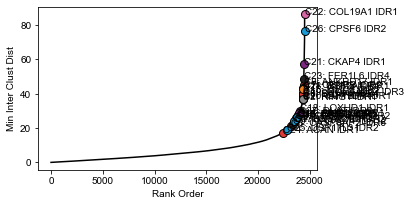

In [16]:
plt.figure(figsize=(5,3))
sortedfullmininterclustdist=sorted(fullmininterclustdist)
sortedidx=[i[0] for i in sorted(enumerate(fullmininterclustdist), key=lambda x:x[1])]
#print(sortedidx[1500])
#print(fullmininterclustdist[sortedidx[1500]])
plt.plot(sortedfullmininterclustdist,'-k')
#plt.plot([0,25000],[5,5],'-k')

colorhex=['#d865a6','#7c2880','#e23a36','#e23a36','#e23a36','#231f20','#1f8241','#e23a36','#e23a36','#231f20','#189bd7','#1f8241','#231f20','#e23a36','#189bd7','#1f8241','#1f8241','#189bd7','#231f20','#e23a36','#8c8c8c','#7c2880','#d865a6','#231f20','#e23a36','#189bd7','#189bd7','#7c2880','#f58220','#189bd7']


for c in range(0,30):
    pos=[i for i, x in enumerate(fullclusternum) if x==c]
    tmplist=[]
    for i in range(0,len(pos)):
        #print(pos[i])
        #print(fullmininterclustdist[pos[i]])
        #print(fullclusternum[pos[i]])
        #print(fullgeneswnums[pos[i]])
        tmplist.append(fullmininterclustdist[pos[i]])

    tmpidx=tmplist.index(max(tmplist))
    tmpsortidx=sortedidx.index(pos[tmpidx])
    print(max(tmplist))
    print(pos[tmpidx])
    print(fullmininterclustdist[pos[tmpidx]])
    print(sortedfullmininterclustdist[tmpsortidx])
    print(len(pos))

    plt.plot(tmpsortidx,sortedfullmininterclustdist[tmpsortidx],'o',markersize=8,markerfacecolor=colorhex[c],markeredgecolor='black')
    plt.text(tmpsortidx,sortedfullmininterclustdist[tmpsortidx],'C'+str(c)+': '+fullgeneswnums[pos[tmpidx]])
plt.ylabel('Min Inter Clust Dist')
plt.xlabel('Rank Order')

#plt.savefig('../Min_Inter_Clust_Dist_all_human_IDRs.pdf', transparent=False, bbox_inches = "tight")